# Preprocessing using Feature Extracted HR Data

Full preprocessing code, includes HR feature normalization per participant

In [2]:
'''import pandas as pd
import numpy as np
import os
import pickle
from enum import Enum
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor

# Define padding token for discrete data
class CatToken(Enum):
    PAD = 28

# Calculate heart rate features from raw data
def calculate_hr_features(df):
    if df.empty:
        return pd.Series({
            'mean_hr': 0, 'std_hr': 0, 'min_hr': 0, 'max_hr': 0,
            'rmssd': 0, 'cv_hr': 0, 'skewness': 0, 'kurtosis': 0, 'IQR': 0
        })
    return pd.Series({
        'mean_hr': df['Values'].mean(),
        'std_hr': df['Values'].std(),
        'min_hr': df['Values'].min(),
        'max_hr': df['Values'].max(),
        'rmssd': np.sqrt(np.mean(np.diff(df['Values'].dropna().values)**2)),
        'cv_hr': df['Values'].std() / df['Values'].mean() if df['Values'].mean() != 0 else 0,
        'skewness': df['Values'].skew(),
        'kurtosis': df['Values'].kurt(),
        'IQR': np.subtract(*np.percentile(df['Values'].dropna(), [75, 25]))
    })

def preprocess_day_data(pickle_file, counts_file, aggregated_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    df = data['hr_subj']
    df['lat'] = df['lat'].fillna(0)
    df['lon'] = df['lon'].fillna(0)

    # Define transport modes and activities with padding tokens
    transport_modes = {"train", "bicycle", "bus", "car/truck", "change travel mode/transfer", "foot", "metro", "ferry/boat"}
    mode_tokens = {mode: i + 20 for i, mode in enumerate(transport_modes)}
    mode_tokens['PAD'] = CatToken.PAD.value

    activities = {"home", "work related", "work", "exercise/play sports", "socialize", "education", "shopping", "idk", "expstart", "personal errands/tasks", "accompany/dropoff/pickup", "healthcare", "eat out/takeout", "entertainment", "community/religious", "summer cottage, allotment garden, holiday", "no information provided", "other", "-2"}
    activity_tokens = {act: i + 1 for i, act in enumerate(activities)}
    activity_tokens['PAD'] = CatToken.PAD.value

    # Read and process counts file
    counts_df = pd.read_csv(counts_file)
    counts_df['lat_lon'] = counts_df['Latitude'].astype(str) + "_" + counts_df['Longitude'].astype(str)
    counts_columns_to_use = [col for col in counts_df.columns if col not in ['Latitude', 'Longitude', 'Diversity_Index', 'Slope', 'lat_lon']]
    counts_dict = counts_df.groupby('lat_lon')[counts_columns_to_use].first().to_dict('index')

    # Read and process aggregated file
    aggregated_df = pd.read_csv(aggregated_file)
    aggregated_df['lat_lon'] = aggregated_df['Coordinate']
    aggregated_columns_to_use = [col for col in aggregated_df.columns if col != 'Coordinate']
    aggregated_dict = aggregated_df.groupby('lat_lon')[aggregated_columns_to_use].first().to_dict('index')

    results = []
    hr_features_list = []

    previous_activity = None
    activity_start_idx = 0
    previous_is_mode = False

    for i, row in df.iterrows():
        current_activity = row['Activity_concat'].lower().strip()
        current_is_mode = current_activity in transport_modes

        if current_activity != previous_activity:
            if previous_activity is not None:
                activity_segment = df.iloc[activity_start_idx:i]
                duration = i - activity_start_idx
                if duration > 0:
                    lat_lon_key = f"{activity_segment['lat'].iloc[0]}_{activity_segment['lon'].iloc[0]}"
                    counts = counts_dict.get(lat_lon_key, {col: 0 for col in counts_columns_to_use})
                    aggregated_data = aggregated_dict.get(lat_lon_key, {col: 0 for col in aggregated_columns_to_use})
                    results.append({
                        'initial_activity': previous_activity.split('_')[0],  # Remove the index part
                        'activity': activity_tokens.get(previous_activity.split('_')[0], CatToken.PAD.value),
                        'latitude': activity_segment['lat'].iloc[0],
                        'longitude': activity_segment['lon'].iloc[0],
                        'mode': mode_tokens.get(previous_activity.split('_')[0], CatToken.PAD.value),
                        'duration': duration,
                        **counts,
                        **aggregated_data
                    })
                    hr_features = calculate_hr_features(activity_segment)
                    hr_features_list.append(hr_features)

            activity_start_idx = i
            previous_activity = current_activity
            previous_is_mode = current_is_mode

    # Handle the last segment
    if previous_activity is not None and activity_start_idx < len(df):
        activity_segment = df.iloc[activity_start_idx:]
        duration = len(df) - activity_start_idx
        if duration > 0:
            lat_lon_key = f"{activity_segment['lat'].iloc[0]}_{activity_segment['lon'].iloc[0]}"
            counts = counts_dict.get(lat_lon_key, {col: 0 for col in counts_columns_to_use})
            aggregated_data = aggregated_dict.get(lat_lon_key, {col: 0 for col in aggregated_columns_to_use})
            results.append({
                'initial_activity': previous_activity.split('_')[0],  # Remove the index part
                'activity': activity_tokens.get(previous_activity.split('_')[0], CatToken.PAD.value),
                'latitude': activity_segment['lat'].iloc[0],
                'longitude': activity_segment['lon'].iloc[0],
                'mode': mode_tokens.get(previous_activity.split('_')[0], CatToken.PAD.value),
                'duration': duration,
                **counts,
                **aggregated_data
            })
            hr_features = calculate_hr_features(activity_segment)
            hr_features_list.append(hr_features)

    final_data_df = pd.DataFrame(results)
    hr_features_df = pd.DataFrame(hr_features_list)

    return final_data_df, hr_features_df

def process_participant_day(day_path, counts_file, aggregated_file, output_folder, participant_folder, day_folder):
    pickle_path = os.path.join(day_path, 'day_processed_data.pickle')
    if os.path.exists(pickle_path):
        print(f"Processing {pickle_path}...")
        try:
            final_data_df, hr_features_df = preprocess_day_data(pickle_path, counts_file, aggregated_file)
            return final_data_df, hr_features_df
        except Exception as e:
            print(f"Error processing {pickle_path}: {e}")
    else:
        print(f"No data file found for {day_folder}")
    return None, None

def normalize_hr_features(hr_features_df):
    # Initialize StandardScaler
    scaler = StandardScaler()

    # Standardize all features
    standardized_features = pd.DataFrame(
        scaler.fit_transform(hr_features_df),
        columns=hr_features_df.columns,
        index=hr_features_df.index
    )

    # Function to scale standardized values to 0-1 range
    def scale_to_01(x):
        return 1 / (1 + np.exp(-x))

    # Apply scaling to 0-1 range for all features except skewness and kurtosis
    for col in standardized_features.columns:
        if col not in ['skewness', 'kurtosis']:
            standardized_features[col] = scale_to_01(standardized_features[col])

    # Special handling for skewness and kurtosis
    for col in ['skewness', 'kurtosis']:
        # Shift and scale to 0-1 range with 0.5 as the new "zero" point
        standardized_features[col] = scale_to_01(standardized_features[col]) / 2 + 0.25

    return standardized_features, scaler

def process_all_days(base_folder, output_folder, counts_file, aggregated_file):
    aggregated_output_folder = os.path.join(output_folder, 'aggregated')
    os.makedirs(aggregated_output_folder, exist_ok=True)

    for participant_folder in os.listdir(base_folder):
        participant_path = os.path.join(base_folder, participant_folder)
        data_folder_path = os.path.join(participant_path, 'Data')
        if os.path.isdir(data_folder_path):
            participant_data = []
            participant_hr_features = []
            day_data_dict = {}

            participant_output_folder = os.path.join(output_folder, participant_folder)
            os.makedirs(participant_output_folder, exist_ok=True)

            # First pass: collect all data and HR features
            for day_folder in os.listdir(data_folder_path):
                day_path = os.path.join(data_folder_path, day_folder)
                if os.path.isdir(day_path):
                    final_data_df, hr_features_df = process_participant_day(
                        day_path, counts_file, aggregated_file,
                        output_folder, participant_folder, day_folder
                    )
                    if final_data_df is not None and hr_features_df is not None:
                        final_data_df['participant_id'] = participant_folder
                        final_data_df['day'] = day_folder
                        hr_features_df['participant_id'] = participant_folder
                        hr_features_df['day'] = day_folder

                        participant_data.append(final_data_df)
                        participant_hr_features.append(hr_features_df)
                        day_data_dict[day_folder] = final_data_df

            if participant_data and participant_hr_features:
                participant_data_df = pd.concat(participant_data, ignore_index=True)
                participant_hr_features_df = pd.concat(participant_hr_features, ignore_index=True)

                # Normalize HR features for this participant
                normalized_hr_features, scaler = normalize_hr_features(participant_hr_features_df.drop(['participant_id', 'day'], axis=1))
                
                # Add back participant_id and day columns
                normalized_hr_features['participant_id'] = participant_hr_features_df['participant_id']
                normalized_hr_features['day'] = participant_hr_features_df['day']

                # Second pass: create individual day files
                for day_folder, final_data_df in day_data_dict.items():
                    day_mask = normalized_hr_features['day'] == day_folder
                    day_normalized_hr = normalized_hr_features[day_mask].drop(['participant_id', 'day'], axis=1)
                    
                    # Save individual day file with normalized HR features only
                    day_output_path = os.path.join(participant_output_folder, f'{day_folder}_data_with_normalized_hr.csv')
                    day_normalized_hr.to_csv(day_output_path, index=False)
                    print(f"Saved normalized HR data for {participant_folder}, {day_folder} to {day_output_path}")

                    # Save individual day file without HR features
                    final_data_output_path = os.path.join(participant_output_folder, f'{day_folder}_final_data.csv')
                    final_data_df.to_csv(final_data_output_path, index=False)
                    print(f"Saved final data without HR for {participant_folder}, {day_folder} to {final_data_output_path}")

                # Save participant-specific combined data in the aggregated folder
                participant_all_data_path = os.path.join(aggregated_output_folder, f'{participant_folder}_all_data.csv')
                participant_data_df.to_csv(participant_all_data_path, index=False)
                print(f"Saved all data for {participant_folder} to {participant_all_data_path}")

                participant_normalized_hr_path = os.path.join(aggregated_output_folder, f'{participant_folder}_normalized_hr_features.csv')
                normalized_hr_features.to_csv(participant_normalized_hr_path, index=False)
                print(f"Saved normalized HR features for {participant_folder} to {participant_normalized_hr_path}")

    print("Processing completed. Data saved in the output folder.")

base_folder = '/run/user/1021/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/PUBLIC/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/E4/completed'
output_folder = 'preprocessed_by_activity_with_data_extraction_final'
counts_file = '/home/elygao/Data Extraction/counts_output/counts.csv/50_osm_tags_poi.csv'
aggregated_file = '/home/elygao/Data Extraction/segmentation_output/aggregated_results.csv'

process_all_days(base_folder, output_folder, counts_file, aggregated_file)'''

'import pandas as pd\nimport numpy as np\nimport os\nimport pickle\nfrom enum import Enum\nfrom sklearn.preprocessing import StandardScaler\nfrom concurrent.futures import ProcessPoolExecutor\n\n# Define padding token for discrete data\nclass CatToken(Enum):\n    PAD = 28\n\n# Calculate heart rate features from raw data\ndef calculate_hr_features(df):\n    if df.empty:\n        return pd.Series({\n            \'mean_hr\': 0, \'std_hr\': 0, \'min_hr\': 0, \'max_hr\': 0,\n            \'rmssd\': 0, \'cv_hr\': 0, \'skewness\': 0, \'kurtosis\': 0, \'IQR\': 0\n        })\n    return pd.Series({\n        \'mean_hr\': df[\'Values\'].mean(),\n        \'std_hr\': df[\'Values\'].std(),\n        \'min_hr\': df[\'Values\'].min(),\n        \'max_hr\': df[\'Values\'].max(),\n        \'rmssd\': np.sqrt(np.mean(np.diff(df[\'Values\'].dropna().values)**2)),\n        \'cv_hr\': df[\'Values\'].std() / df[\'Values\'].mean() if df[\'Values\'].mean() != 0 else 0,\n        \'skewness\': df[\'Values\'].skew(),

Checking activities and modes, tokens, counts 

In [3]:
import os
import pandas as pd

# Directories
base_input_dir = '/home/elygao/preprocessed_by_activity_with_data_extraction_final'

# Define transport modes and activities
transport_modes = {"train", "bicycle", "bus", "car/truck", "change travel mode/transfer", "foot", "metro", "ferry/boat"}
mode_tokens = {mode: i + 19 for i, mode in enumerate(transport_modes)}

activities = {"home", "work related", "work", "exercise/play sports", "socialize", "education", "shopping", "idk", "expstart", "personal errands/tasks", "accompany/dropoff/pickup", "healthcare", "eat out/takeout", "entertainment", "community/religious", "summer cottage, allotment garden, holiday", "no information provided", "other", "-2"}
activity_tokens = {act: i for i, act in enumerate(activities)}

# Initialize a set to collect all unique activities found in the CSV files
found_activities = set()

# Initialize dictionaries to count occurrences
mode_counts = {mode: 0 for mode in transport_modes}
activity_counts = {act: 0 for act in activities}

# Function to check activities in the CSV files
def check_activities(base_input_dir):
    for participant in os.listdir(base_input_dir):
        participant_dir = os.path.join(base_input_dir, participant)
        if os.path.isdir(participant_dir):
            for root, _, files in os.walk(participant_dir):
                for file in files:
                    if file.endswith('_final_data.csv'):
                        file_path = os.path.join(root, file)
                        df = pd.read_csv(file_path)
                        activities_in_file = df['initial_activity'].unique()
                        found_activities.update(activities_in_file)
                        
                        # Update counts
                        for activity in activities_in_file:
                            if activity in transport_modes:
                                mode_counts[activity] += 1
                            elif activity in activities:
                                activity_counts[activity] += 1

# Run the function
check_activities(base_input_dir)

print("Activities found in CSV files:")
print(found_activities)

# Check for missing activities
missing_activities = activities.difference(found_activities)
if missing_activities:
    print("Activities defined in the script but not found in any CSV files:")
    print(missing_activities)
else:
    print("All defined activities are found in the CSV files.")

# Check if all found activities are defined
undefined_activities = found_activities.difference(transport_modes).difference(activities)
if undefined_activities:
    print("Activities found in CSV files but not defined in the script:")
    print(undefined_activities)
else:
    print("All activities found in CSV files are defined in the script.")

# Print token lists
print("\nMode tokens:")
print(mode_tokens)

print("\nActivity tokens:")
print(activity_tokens)

# Print counts
print("\nMode counts:")
print(mode_counts)

print("\nActivity counts:")
print(activity_counts)

print("\nNumber of mode tokens:", len(mode_tokens))
print("Number of activity tokens:", len(activity_tokens))


Activities found in CSV files:
{'healthcare', 'metro', 'idk', 'no information provided', 'taxi', 'eat out/takeout', 'education', 'personal errands/tasks', 'home', 'other', 'bus', 'socialize', 'train', 'entertainment', 'car/truck', 'work', 'accompany/dropoff/pickup', 'bicycle', 'personal mobility device', 'summer cottage, allotment garden, holiday', 'foot', 'work related', 'change travel mode/transfer', 'air', 'shopping', 'ferry/boat', '-2', 'exercise/play sports', 'expstart', 'motorcycle', 'community/religious', -2}
All defined activities are found in the CSV files.
Activities found in CSV files but not defined in the script:
{'air', 'taxi', 'motorcycle', 'personal mobility device', -2}

Mode tokens:
{'foot': 19, 'metro': 20, 'train': 21, 'change travel mode/transfer': 22, 'bus': 23, 'car/truck': 24, 'ferry/boat': 25, 'bicycle': 26}

Activity tokens:
{'summer cottage, allotment garden, holiday': 0, 'healthcare': 1, 'idk': 2, 'no information provided': 3, 'work related': 4, 'eat out/tak

Obtaining all unique locations to utilize data extraction scripts

In [3]:
'''import os
import pandas as pd

def unique_locations(data_folder, output_file):
    unique_locs = set()  # Use a set to store unique latitude and longitude pairs

    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('_final_data.csv'):
                file_path = os.path.join(root, file)
                try:
                    # Load the CSV file
                    df = pd.read_csv(file_path)

                    # Filter out rows where latitude and longitude are both 0
                    filtered_df = df[(df['latitude'] != 0.0) & (df['longitude'] != 0.0)]

                    # Update the set with unique latitude and longitude pairs
                    unique_locs.update(zip(filtered_df['latitude'], filtered_df['longitude']))
                    
                except Exception as e:
                    print(f"Failed to process file {file_path}: {e}")

    # Convert the set to a DataFrame
    unique_locs_df = pd.DataFrame(list(unique_locs), columns=['Latitude', 'Longitude'])

    # Save the DataFrame to a CSV file in the specified output file
    unique_locs_df.to_csv(output_file, index=False)
    print(f"Unique locations saved to {output_file}")

data_folder = 'preprocessed_by_activity'  # Your directory containing CSV files
output_file = 'lat_lon.csv'  # Path where the output CSV will be saved
unique_locations(data_folder, output_file)
'''

'import os\nimport pandas as pd\n\ndef unique_locations(data_folder, output_file):\n    unique_locs = set()  # Use a set to store unique latitude and longitude pairs\n\n    for root, dirs, files in os.walk(data_folder):\n        for file in files:\n            if file.endswith(\'_final_data.csv\'):\n                file_path = os.path.join(root, file)\n                try:\n                    # Load the CSV file\n                    df = pd.read_csv(file_path)\n\n                    # Filter out rows where latitude and longitude are both 0\n                    filtered_df = df[(df[\'latitude\'] != 0.0) & (df[\'longitude\'] != 0.0)]\n\n                    # Update the set with unique latitude and longitude pairs\n                    unique_locs.update(zip(filtered_df[\'latitude\'], filtered_df[\'longitude\']))\n                    \n                except Exception as e:\n                    print(f"Failed to process file {file_path}: {e}")\n\n    # Convert the set to a DataFrame\n    

Checking variability of input data

In [4]:
'''import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load data from files
def load_data(base_dir):
    participants = os.listdir(base_dir)
    all_data = []
    
    for participant in participants:
        participant_dir = os.path.join(base_dir, participant)
        if os.path.isdir(participant_dir):
            for file in os.listdir(participant_dir):
                if file.endswith('_final_data.csv'):
                    file_path = os.path.join(participant_dir, file)
                    data = pd.read_csv(file_path)
                    data['participant'] = participant
                    all_data.append(data)
                elif file.endswith('_hr_features.csv'):
                    file_path = os.path.join(participant_dir, file)
                    data = pd.read_csv(file_path)
                    data['participant'] = participant
                    all_data.append(data)
    
    return pd.concat(all_data, ignore_index=True)

# Load data
base_dir = 'preprocessed_by_activity_counts'
data = load_data(base_dir)

# Display basic statistics
print(data.describe())

# Plotting function
def plot_data(data, column, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='participant', y=column, data=data)
    plt.title(f'Boxplot of {column} by Participant')
    plt.xticks(rotation=90)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()

# Plot diversity of key features
key_columns = ['mean_hr', 'std_hr', 'min_hr', 'max_hr', 'rmssd', 'cv_hr', 'skewness', 'kurtosis', 'IQR', 'latitude', 'longitude', 'duration']

for column in key_columns:
    if column in data.columns:
        plot_data(data, column, f'Diversity of {column}')

# Filter numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to see pairwise relationships
sns.pairplot(numeric_data)
plt.title('Pairplot of Key Features')
plt.show()

# Check standard deviation and IQR for diversity
diversity_measures = numeric_data.agg(['std', 'iqr']).T
print(diversity_measures)

# Summarize diversity measures
for column in key_columns:
    if column in numeric_data.columns:
        std_dev = numeric_data[column].std()
        iqr = numeric_data[column].quantile(0.75) - numeric_data[column].quantile(0.25)
        print(f'{column}: Standard Deviation = {std_dev:.2f}, IQR = {iqr:.2f}')
'''

"import os\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Function to load data from files\ndef load_data(base_dir):\n    participants = os.listdir(base_dir)\n    all_data = []\n    \n    for participant in participants:\n        participant_dir = os.path.join(base_dir, participant)\n        if os.path.isdir(participant_dir):\n            for file in os.listdir(participant_dir):\n                if file.endswith('_final_data.csv'):\n                    file_path = os.path.join(participant_dir, file)\n                    data = pd.read_csv(file_path)\n                    data['participant'] = participant\n                    all_data.append(data)\n                elif file.endswith('_hr_features.csv'):\n                    file_path = os.path.join(participant_dir, file)\n                    data = pd.read_csv(file_path)\n                    data['participant'] = participant\n                    all_data.append(data)\n    \n    retur

Graphing heat map of mean_hr onto copenhagen map

In [5]:
'''import pandas as pd
import folium
from folium.plugins import HeatMap
import os
import glob

def read_and_combine_data(folder_path):
    all_data = []
    
    # Iterate through participant folders
    for participant_folder in os.listdir(folder_path):
        participant_path = os.path.join(folder_path, participant_folder)
        if os.path.isdir(participant_path):
            # Find all final_data CSV files for this participant
            final_data_files = glob.glob(os.path.join(participant_path, '*_final_data.csv'))
            
            for final_data_file in final_data_files:
                # Read final_data CSV
                final_data = pd.read_csv(final_data_file)
                
                # Construct the corresponding normalized_hr CSV filename
                hr_file = final_data_file.replace('_final_data.csv', '_data_with_normalized_hr.csv')
                
                if os.path.exists(hr_file):
                    # Read normalized_hr CSV
                    hr_data = pd.read_csv(hr_file)
                    
                    # Ensure that both DataFrames have the same number of rows
                    if len(final_data) == len(hr_data):
                        # Combine the data horizontally (column-wise)
                        combined_data = pd.concat([final_data, hr_data], axis=1)
                        all_data.append(combined_data)
                        #print(f"Successfully combined data for participant {participant_folder}, file: {os.path.basename(final_data_file)}")
                    else:
                        print(f"Mismatch in row count for participant {participant_folder}, file: {os.path.basename(final_data_file)}. Skipping this file.")
                else:
                    print(f"Missing normalized HR data for participant {participant_folder}, file: {os.path.basename(final_data_file)}. Skipping this file.")
    
    # Concatenate all data into a single DataFrame
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print("No data was successfully combined.")
        return None

# Read and combine the data
folder_path = 'preprocessed_by_activity_with_data_extraction_final'
combined_data = read_and_combine_data(folder_path)

if combined_data is not None and not combined_data.empty:
    # Create a map centered on Copenhagen
    copenhagen_map = folium.Map(location=[55.6761, 12.5683], zoom_start=12)

    # Prepare data for the heatmap
    heat_data = combined_data[['latitude', 'longitude', 'mean_hr']].dropna().values.tolist()

    # Add the heatmap layer
    HeatMap(heat_data, radius=15, blur=10, max_zoom=1, gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'yellow', 1: 'red'}).add_to(copenhagen_map)

    # Save the map
    copenhagen_map.save("copenhagen_heart_rate_map.html")

    print("Map has been saved as copenhagen_heart_rate_map.html")
else:
    print("No data available to create the map.")'''

'import pandas as pd\nimport folium\nfrom folium.plugins import HeatMap\nimport os\nimport glob\n\ndef read_and_combine_data(folder_path):\n    all_data = []\n    \n    # Iterate through participant folders\n    for participant_folder in os.listdir(folder_path):\n        participant_path = os.path.join(folder_path, participant_folder)\n        if os.path.isdir(participant_path):\n            # Find all final_data CSV files for this participant\n            final_data_files = glob.glob(os.path.join(participant_path, \'*_final_data.csv\'))\n            \n            for final_data_file in final_data_files:\n                # Read final_data CSV\n                final_data = pd.read_csv(final_data_file)\n                \n                # Construct the corresponding normalized_hr CSV filename\n                hr_file = final_data_file.replace(\'_final_data.csv\', \'_data_with_normalized_hr.csv\')\n                \n                if os.path.exists(hr_file):\n                    # Read n

Creating single participant heatmap with location markers 

In [6]:
'''import pandas as pd
import folium
from folium.plugins import HeatMap
import os
import glob
import numpy as np

def interpolate_zero_coordinates(df):
    # Create a mask for rows with non-zero coordinates
    non_zero_mask = (df['latitude'] != 0) & (df['longitude'] != 0)
    
    # Get indices of non-zero coordinates
    non_zero_indices = np.where(non_zero_mask)[0]
    
    for i in range(len(non_zero_indices) - 1):
        start_idx = non_zero_indices[i]
        end_idx = non_zero_indices[i + 1]
        
        if end_idx - start_idx > 1:
            # Interpolate between start and end
            start_lat, start_lon = df.loc[start_idx, ['latitude', 'longitude']]
            end_lat, end_lon = df.loc[end_idx, ['latitude', 'longitude']]
            
            for j in range(start_idx + 1, end_idx):
                fraction = (j - start_idx) / (end_idx - start_idx)
                df.loc[j, 'latitude'] = start_lat + fraction * (end_lat - start_lat)
                df.loc[j, 'longitude'] = start_lon + fraction * (end_lon - start_lon)
    
    return df

def read_participant_data(folder_path, participant_id):
    all_data = []
    
    participant_path = os.path.join(folder_path, str(participant_id))
    if os.path.isdir(participant_path):
        final_data_files = glob.glob(os.path.join(participant_path, '*_final_data.csv'))
        
        for final_data_file in final_data_files:
            final_data = pd.read_csv(final_data_file)
            hr_file = final_data_file.replace('_final_data.csv', '_data_with_normalized_hr.csv')
            
            if os.path.exists(hr_file):
                hr_data = pd.read_csv(hr_file)
                
                if len(final_data) == len(hr_data):
                    combined_data = pd.concat([final_data, hr_data], axis=1)
                    combined_data = interpolate_zero_coordinates(combined_data)
                    all_data.append(combined_data)
                    print(f"Successfully combined and interpolated data for file: {os.path.basename(final_data_file)}")
                else:
                    print(f"Mismatch in row count for file: {os.path.basename(final_data_file)}. Skipping this file.")
            else:
                print(f"Missing normalized HR data for file: {os.path.basename(final_data_file)}. Skipping this file.")
    
    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        print("No data was successfully combined.")
        return None

# Define transport modes and activities
transport_modes = {"train", "bicycle", "bus", "car/truck", "change travel mode/transfer", "foot", "metro", "ferry/boat"}
mode_tokens = {mode: i + 19 for i, mode in enumerate(transport_modes)}

activities = {"home", "work related", "work", "exercise/play sports", "socialize", "education", "shopping", "idk", "expstart", "personal errands/tasks", "accompany/dropoff/pickup", "healthcare", "eat out/takeout", "entertainment", "community/religious", "summer cottage, allotment garden, holiday", "no information provided", "other", "-2"}
activity_tokens = {act: i for i, act in enumerate(activities)}

# Read data for participant 103
folder_path = 'preprocessed_by_activity_with_data_extraction_final'
participant_id = 103
combined_data = read_participant_data(folder_path, participant_id)

if combined_data is not None and not combined_data.empty:
    # Remove any remaining rows with 0.0, 0.0 coordinates
    combined_data = combined_data[(combined_data['latitude'] != 0) & (combined_data['longitude'] != 0)]
    
    # Create a map centered on the mean of all coordinates
    mean_lat = combined_data['latitude'].mean()
    mean_lon = combined_data['longitude'].mean()
    copenhagen_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

    # Prepare data for the heatmap
    heat_data = combined_data[['latitude', 'longitude', 'mean_hr']].values.tolist()

    # Create layers
    heatmap_layer = folium.FeatureGroup(name="Heart Rate Heatmap")
    marker_layer = folium.FeatureGroup(name="Activity Markers")

    # Add the heatmap to its layer
    HeatMap(heat_data, radius=15, blur=10, max_zoom=1, gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'yellow', 1: 'red'}).add_to(heatmap_layer)

    # Define color map for activities and modes
    color_map = {
        'home': 'blue',
        'work': 'red',
        'work related': 'darkred',
        'exercise/play sports': 'green',
        'socialize': 'purple',
        'education': 'orange',
        'shopping': 'pink',
        'personal errands/tasks': 'gray',
        'healthcare': 'white',
        'eat out/takeout': 'beige',
        'entertainment': 'lightblue',
        'community/religious': 'darkpurple',
        'summer cottage, allotment garden, holiday': 'lightgreen',
    }

    # Add markers for each activity/mode
    for idx, row in combined_data.iterrows():
        activity = row['initial_activity']
        lat, lon = row['latitude'], row['longitude']
        
        if activity in transport_modes:
            icon = folium.Icon(color='lightgray', icon='bus', prefix='fa')
        elif activity in activities:
            color = color_map.get(activity, 'cadetblue')  # default color if not in color_map
            icon = folium.Icon(color=color, icon='info-sign', prefix='fa')
        else:
            icon = folium.Icon(color='cadetblue', icon='question-sign', prefix='fa')

        folium.Marker([lat, lon], popup=activity, icon=icon).add_to(marker_layer)

    # Add layers to the map
    heatmap_layer.add_to(copenhagen_map)
    marker_layer.add_to(copenhagen_map)

    # Add layer control
    folium.LayerControl(collapsed=False).add_to(copenhagen_map)

    # Add a title and instructions to the map
    title_html = '' 
             <h3 align="center" style="font-size:16px"><b>Copenhagen Activity Map</b></h3>
             <div align="center" style="font-size:14px">
                Use the checkboxes in the top right corner to toggle layers on/off
             </div>
             ''
    copenhagen_map.get_root().html.add_child(folium.Element(title_html))

    # Save the map
    map_filename = f"copenhagen_activity_map_participant_{participant_id}.html"
    copenhagen_map.save(map_filename)

    print(f"Map has been saved as {map_filename}")
else:
    print("No data available to create the map.") '''

'import pandas as pd\nimport folium\nfrom folium.plugins import HeatMap\nimport os\nimport glob\nimport numpy as np\n\ndef interpolate_zero_coordinates(df):\n    # Create a mask for rows with non-zero coordinates\n    non_zero_mask = (df[\'latitude\'] != 0) & (df[\'longitude\'] != 0)\n    \n    # Get indices of non-zero coordinates\n    non_zero_indices = np.where(non_zero_mask)[0]\n    \n    for i in range(len(non_zero_indices) - 1):\n        start_idx = non_zero_indices[i]\n        end_idx = non_zero_indices[i + 1]\n        \n        if end_idx - start_idx > 1:\n            # Interpolate between start and end\n            start_lat, start_lon = df.loc[start_idx, [\'latitude\', \'longitude\']]\n            end_lat, end_lon = df.loc[end_idx, [\'latitude\', \'longitude\']]\n            \n            for j in range(start_idx + 1, end_idx):\n                fraction = (j - start_idx) / (end_idx - start_idx)\n                df.loc[j, \'latitude\'] = start_lat + fraction * (end_lat - start

Loading preprocessed files into tensors

In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

# Constants
MAX_SIMU_TOKENS = 43
N_TRACKS = 5  # Updated number of tracks to include duration as a separate track
N_BARS = 2
RESOLUTION = 8
REQUIRED_TIMESTEPS = N_BARS * 4 * RESOLUTION
stride = REQUIRED_TIMESTEPS // 3

# Define the padding values
EMOTION_PADDING_VALUE = 0
ACTIVITY_PADDING_VALUE = 28

def preprocess_day_data(hr_features_file, activity_file, scalers):
    hr_df = pd.read_csv(hr_features_file)
    activity_df = pd.read_csv(activity_file)
    emotions_features = ['mean_hr', 'std_hr', 'min_hr', 'max_hr', 'rmssd', 'cv_hr', 'skewness', 'kurtosis', 'IQR']
    emotions = hr_df[emotions_features].values

    # Zero out kurtosis and skewness
    emotions[:, emotions_features.index('skewness')] = 0
    emotions[:, emotions_features.index('kurtosis')] = 0

    latitudes = activity_df['latitude'].values
    longitudes = activity_df['longitude'].values
    
    durations = activity_df['duration'].values.reshape(-1, 1)
    activities = activity_df['activity'].values
    modes = activity_df['mode'].values
    
    additional_features = [
        'Motorcyclist', 'Fence', 'Utility Pole', 'Traffic Light', 'Bicyclist', 'Motorcycle', 'Sky',
        'Terrain', 'On Rails', 'Lane Marking - General', 'Pole', 'Car', 'Person', 'Sidewalk',
        'Vegetation', 'Traffic Sign (Front)', 'Bicycle', 'Road', 'Building', 'Other Rider',
        'Curb', 'Wall', 'Bus', 'Truck', 'Manhole'
    ]
    additional_counts = activity_df[additional_features].values
    
    poi_features = [
        'arts_entertainment_events', 'buildings_facilities', 'food_drink', 'public_services',
        'miscellaneous_services', 'roads_transportation', 'beauty_personal_health', 'greenery_natural',
        'tourism_leisure', 'water_body', 'poi_amenity', 'poi_transportation', 'poi_shop',
        'poi_leisure', 'poi_tourism', 'poi_natural', 'poi_buiding', 'poi_historic'
    ]
    poi_counts = activity_df[poi_features].values
    
    # Normalize the features
    durations = scalers['duration'].transform(durations)
    poi_counts = scalers['poi'].transform(poi_counts)
    
    # Ensure additional_counts add up to 1 (i.e., 100%)
    row_sums = additional_counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # To avoid division by zero
    additional_counts = additional_counts / row_sums
    
    return emotions, latitudes, longitudes, durations.flatten(), activities, modes, additional_counts, poi_counts, len(activity_df)

def fit_scalers(base_input_dir):
    duration_scaler = MinMaxScaler()
    poi_scaler = MinMaxScaler()

    duration_data = []
    poi_data = []

    participant_folders = os.listdir(base_input_dir)    
    for participant in participant_folders:
        participant_activity_dir = os.path.join(base_input_dir, participant)
        if not os.path.exists(participant_activity_dir):
            continue

        activity_files = sorted([f for f in os.listdir(participant_activity_dir) if f.endswith('_final_data.csv')])

        for activity_file in activity_files:
            activity_path = os.path.join(participant_activity_dir, activity_file)
            activity_df = pd.read_csv(activity_path)
            duration_data.append(activity_df['duration'].values.reshape(-1, 1))
            poi_data.append(activity_df[
                [
                    'arts_entertainment_events', 'buildings_facilities', 'food_drink', 'public_services',
                    'miscellaneous_services', 'roads_transportation', 'beauty_personal_health', 'greenery_natural',
                    'tourism_leisure', 'water_body', 'poi_amenity', 'poi_transportation', 'poi_shop',
                    'poi_leisure', 'poi_tourism', 'poi_natural', 'poi_buiding', 'poi_historic'
                ]
            ].values)

    # Fit the scalers on the aggregated data
    duration_data = np.concatenate(duration_data)
    poi_data = np.concatenate(poi_data)
    
    duration_scaler.fit(duration_data)
    poi_scaler.fit(poi_data)

    scalers = {
        'duration': duration_scaler,
        'poi': poi_scaler
    }
    return scalers

def segment_and_save(base_input_dir, output_dir):
    scalers = fit_scalers(base_input_dir)
    
    participant_folders = os.listdir(base_input_dir)    
    for participant in participant_folders:
        participant_hr_dir = os.path.join(base_input_dir, participant)
        participant_activity_dir = os.path.join(base_input_dir, participant)

        if not os.path.exists(participant_hr_dir) or not os.path.exists(participant_activity_dir):
            print(f"Missing directories for {participant}")
            continue

        hr_files = sorted([f for f in os.listdir(participant_hr_dir) if f.endswith('_normalized_hr.csv')])
        activity_files = sorted([f for f in os.listdir(participant_activity_dir) if f.endswith('_final_data.csv')])

        full_c_tensor = None
        full_s_tensor = None

        for hr_file, activity_file in zip(hr_files, activity_files):
            hr_path = os.path.join(participant_hr_dir, hr_file)
            activity_path = os.path.join(participant_activity_dir, activity_file)
            try:
                data = preprocess_day_data(hr_path, activity_path, scalers)
                emotions, latitudes, longitudes, durations, activities, modes, additional_counts, poi_counts, n_timesteps = data
                
                # Initialize current_c_tensor with appropriate padding values
                current_c_tensor = np.zeros((N_TRACKS, n_timesteps, MAX_SIMU_TOKENS, 2), dtype=np.float32)
                current_c_tensor[0, :, :, :] = EMOTION_PADDING_VALUE
                current_c_tensor[1, :, :, :] = EMOTION_PADDING_VALUE
                current_c_tensor[2, :, :, :] = EMOTION_PADDING_VALUE
                current_c_tensor[3, :, :, :] = EMOTION_PADDING_VALUE
                current_s_tensor = np.zeros((N_TRACKS, n_timesteps), dtype=np.int32)
                
                for t in range(n_timesteps):
                    # Emotions (HR descriptors)
                    for feature_idx in range(len(emotions[t])):
                        current_c_tensor[0, t, feature_idx, 0] = emotions[t, feature_idx]
                        current_c_tensor[0, t, feature_idx, 1] = 1 if emotions[t, feature_idx] != EMOTION_PADDING_VALUE else 0
                    
                    # Locations - counts
                    for i in range(len(additional_counts[t])):
                        current_c_tensor[1, t, i, 0] = additional_counts[t, i]
                        current_c_tensor[1, t, i, 1] = 1 if additional_counts[t, i] != EMOTION_PADDING_VALUE else 0
                    
                    # Locations - Add POI counts
                    for i in range(len(poi_counts[t])):
                        current_c_tensor[1, t, len(additional_counts[t]) + i, 0] = poi_counts[t, i]
                        current_c_tensor[1, t, len(additional_counts[t]) + i, 1] = 1 if poi_counts[t, i] != EMOTION_PADDING_VALUE else 0
                    
                    # Durations as a separate track
                    current_c_tensor[2, t, 0, 0] = durations[t]
                    current_c_tensor[2, t, 0, 1] = 1  # Duration is always valid

                    # Activity as tokens
                    current_c_tensor[3, t, 0, 0] = activities[t]
                    current_c_tensor[3, t, 0, 1] = 1 if activities[t] != ACTIVITY_PADDING_VALUE else 0
                    
                    # Modes as tokens
                    current_c_tensor[4, t, 0, 0] = modes[t]
                    current_c_tensor[4, t, 0, 1] = 1 if modes[t] != ACTIVITY_PADDING_VALUE else 0
                    
                    # Check for non-padding values in each track
                    for track in range(N_TRACKS):
                        if np.any(current_c_tensor[track, t, :, 1] == 1):
                            current_s_tensor[track, t] = 1
                        else:
                            current_s_tensor[track, t] = 0

                if full_c_tensor is None:
                    full_c_tensor = current_c_tensor
                    full_s_tensor = current_s_tensor
                else:
                    full_c_tensor = np.concatenate((full_c_tensor, current_c_tensor), axis=1)
                    full_s_tensor = np.concatenate((full_s_tensor, current_s_tensor), axis=1)
            except Exception as e:
                print(f"Error processing {hr_file} and {activity_file} for participant {participant}: {str(e)}")
                continue
        
        if full_c_tensor is None or full_s_tensor is None:
            print(f"No valid data processed for participant {participant}")
            continue

        # Output segmented data
        total_timesteps = full_c_tensor.shape[1]
        participant_output_dir = os.path.join(output_dir, participant)
        if not os.path.exists(participant_output_dir):
            os.makedirs(participant_output_dir)

        for start_idx in range(0, total_timesteps - REQUIRED_TIMESTEPS + 1, stride):
            c_tensor_segment = full_c_tensor[:, start_idx:start_idx + REQUIRED_TIMESTEPS, :, :]
            s_tensor_segment = full_s_tensor[:, start_idx:start_idx + REQUIRED_TIMESTEPS]
            sample_filepath = os.path.join(participant_output_dir, f"segment_{start_idx // stride}.npz")
            np.savez(sample_filepath, c_tensor=c_tensor_segment, s_tensor=s_tensor_segment)
            print(f"File saved: {sample_filepath}")
        
    print("Processing completed. Data saved in the output folder.")

base_input_dir = 'preprocessed_by_activity_with_data_extraction_final'  # Folder containing the participant folders with HR and activity data
output_dir = 'preprocessed_npz_vae'  # Folder where the output files should be saved
segment_and_save(base_input_dir, output_dir)


File saved: preprocessed_npz_vae/188/segment_0.npz
File saved: preprocessed_npz_vae/188/segment_1.npz
File saved: preprocessed_npz_vae/188/segment_2.npz
File saved: preprocessed_npz_vae/188/segment_3.npz
File saved: preprocessed_npz_vae/226/segment_0.npz
File saved: preprocessed_npz_vae/226/segment_1.npz
File saved: preprocessed_npz_vae/226/segment_2.npz
File saved: preprocessed_npz_vae/157/segment_0.npz
File saved: preprocessed_npz_vae/157/segment_1.npz
File saved: preprocessed_npz_vae/157/segment_2.npz
File saved: preprocessed_npz_vae/157/segment_3.npz
File saved: preprocessed_npz_vae/157/segment_4.npz
File saved: preprocessed_npz_vae/256/segment_0.npz
File saved: preprocessed_npz_vae/256/segment_1.npz
File saved: preprocessed_npz_vae/256/segment_2.npz
File saved: preprocessed_npz_vae/256/segment_3.npz
File saved: preprocessed_npz_vae/256/segment_4.npz
File saved: preprocessed_npz_vae/256/segment_5.npz
File saved: preprocessed_npz_vae/256/segment_6.npz
File saved: preprocessed_npz_va

Checking for missing values

In [5]:
import numpy as np
import os

def check_nans_in_npz(npz_file_path):
    with np.load(npz_file_path) as data:
        has_nans = False
        for key in data.files:
            array = data[key]
            if np.isnan(array).any():
                print(f"NaNs detected in {npz_file_path} for key '{key}'")
                print(f"Number of NaNs in {key}: {np.isnan(array).sum()}")
                has_nans = True
            if np.isinf(array).any():
                print(f"Infinities detected in {npz_file_path} for key '{key}'")
                print(f"Number of Infinities in {key}: {np.isinf(array).sum()}")
                has_nans = True
        return has_nans

def check_and_remove_nans_in_directory(directory_path):
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.npz'):
                npz_file_path = os.path.join(root, file)
                print(f"Checking file: {npz_file_path}")
                if check_nans_in_npz(npz_file_path):
                    print(f"Removing file with NaNs or Infinities: {npz_file_path}")
                    os.remove(npz_file_path)

directory_path = 'preprocessed_npz_vae'  # Directory containing the .npz files
check_and_remove_nans_in_directory(directory_path)


Checking file: preprocessed_npz_vae/188/segment_0.npz
Checking file: preprocessed_npz_vae/188/segment_3.npz
Checking file: preprocessed_npz_vae/188/segment_1.npz
Checking file: preprocessed_npz_vae/188/segment_2.npz
Checking file: preprocessed_npz_vae/226/segment_0.npz
Checking file: preprocessed_npz_vae/226/segment_1.npz
Checking file: preprocessed_npz_vae/226/segment_2.npz
Checking file: preprocessed_npz_vae/157/segment_0.npz
Checking file: preprocessed_npz_vae/157/segment_4.npz
Checking file: preprocessed_npz_vae/157/segment_3.npz
Checking file: preprocessed_npz_vae/157/segment_1.npz
Checking file: preprocessed_npz_vae/157/segment_2.npz
Checking file: preprocessed_npz_vae/256/segment_0.npz
Checking file: preprocessed_npz_vae/256/segment_4.npz
Checking file: preprocessed_npz_vae/256/segment_6.npz
Checking file: preprocessed_npz_vae/256/segment_3.npz
Checking file: preprocessed_npz_vae/256/segment_5.npz
Checking file: preprocessed_npz_vae/256/segment_1.npz
Checking file: preprocessed_

Preprocessing for "holdout" dataset - dataset used for regression network only

In [6]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

# Constants
MAX_SIMU_TOKENS = 43
N_TRACKS = 5  # Updated number of tracks to include duration as a separate track
N_BARS = 2
RESOLUTION = 8
REQUIRED_TIMESTEPS = N_BARS * 4 * RESOLUTION
stride = REQUIRED_TIMESTEPS // 3

# Define the padding values
EMOTION_PADDING_VALUE = 0
ACTIVITY_PADDING_VALUE = 28

def preprocess_day_data(hr_features_file, activity_file, scalers):
    hr_df = pd.read_csv(hr_features_file)
    activity_df = pd.read_csv(activity_file)
    emotions_features = ['mean_hr', 'std_hr', 'min_hr', 'max_hr', 'rmssd', 'cv_hr', 'skewness', 'kurtosis', 'IQR']
    emotions = hr_df[emotions_features].values

    # Zero out kurtosis and skewness
    emotions[:, emotions_features.index('skewness')] = 0
    emotions[:, emotions_features.index('kurtosis')] = 0

    latitudes = activity_df['latitude'].values
    longitudes = activity_df['longitude'].values
    
    durations = activity_df['duration'].values.reshape(-1, 1)
    activities = activity_df['activity'].values
    modes = activity_df['mode'].values
    
    additional_features = [
        'Motorcyclist', 'Fence', 'Utility Pole', 'Traffic Light', 'Bicyclist', 'Motorcycle', 'Sky',
        'Terrain', 'On Rails', 'Lane Marking - General', 'Pole', 'Car', 'Person', 'Sidewalk',
        'Vegetation', 'Traffic Sign (Front)', 'Bicycle', 'Road', 'Building', 'Other Rider',
        'Curb', 'Wall', 'Bus', 'Truck', 'Manhole'
    ]
    additional_counts = activity_df[additional_features].values
    
    poi_features = [
        'arts_entertainment_events', 'buildings_facilities', 'food_drink', 'public_services',
        'miscellaneous_services', 'roads_transportation', 'beauty_personal_health', 'greenery_natural',
        'tourism_leisure', 'water_body', 'poi_amenity', 'poi_transportation', 'poi_shop',
        'poi_leisure', 'poi_tourism', 'poi_natural', 'poi_buiding', 'poi_historic'
    ]
    poi_counts = activity_df[poi_features].values
    
    # Normalize the features
    durations = scalers['duration'].transform(durations)
    poi_counts = scalers['poi'].transform(poi_counts)
    
    # Ensure additional_counts add up to 1 (i.e., 100%)
    row_sums = additional_counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # To avoid division by zero
    additional_counts = additional_counts / row_sums
    
    return emotions, latitudes, longitudes, durations.flatten(), activities, modes, additional_counts, poi_counts, len(activity_df)

def fit_scalers(base_input_dir):
    duration_scaler = MinMaxScaler()
    poi_scaler = MinMaxScaler()

    duration_data = []
    poi_data = []

    participant_folders = os.listdir(base_input_dir)    
    for participant in participant_folders:
        participant_activity_dir = os.path.join(base_input_dir, participant)
        if not os.path.exists(participant_activity_dir):
            continue

        activity_files = sorted([f for f in os.listdir(participant_activity_dir) if f.endswith('_final_data.csv')])

        for activity_file in activity_files:
            activity_path = os.path.join(participant_activity_dir, activity_file)
            activity_df = pd.read_csv(activity_path)
            duration_data.append(activity_df['duration'].values.reshape(-1, 1))
            poi_data.append(activity_df[
                [
                    'arts_entertainment_events', 'buildings_facilities', 'food_drink', 'public_services',
                    'miscellaneous_services', 'roads_transportation', 'beauty_personal_health', 'greenery_natural',
                    'tourism_leisure', 'water_body', 'poi_amenity', 'poi_transportation', 'poi_shop',
                    'poi_leisure', 'poi_tourism', 'poi_natural', 'poi_buiding', 'poi_historic'
                ]
            ].values)

    # Fit the scalers on the aggregated data
    duration_data = np.concatenate(duration_data)
    poi_data = np.concatenate(poi_data)
    
    duration_scaler.fit(duration_data)
    poi_scaler.fit(poi_data)

    scalers = {
        'duration': duration_scaler,
        'poi': poi_scaler
    }
    return scalers

def segment_and_save(base_input_dir, output_dir):
    scalers = fit_scalers(base_input_dir)
    
    participant_folders = os.listdir(base_input_dir)    
    for participant in participant_folders:
        participant_hr_dir = os.path.join(base_input_dir, participant)
        participant_activity_dir = os.path.join(base_input_dir, participant)

        if not os.path.exists(participant_hr_dir) or not os.path.exists(participant_activity_dir):
            print(f"Missing directories for {participant}")
            continue

        hr_files = sorted([f for f in os.listdir(participant_hr_dir) if f.endswith('_normalized_hr.csv')])
        activity_files = sorted([f for f in os.listdir(participant_activity_dir) if f.endswith('_final_data.csv')])

        full_c_tensor = None
        full_s_tensor = None

        for hr_file, activity_file in zip(hr_files, activity_files):
            hr_path = os.path.join(participant_hr_dir, hr_file)
            activity_path = os.path.join(participant_activity_dir, activity_file)
            try:
                data = preprocess_day_data(hr_path, activity_path, scalers)
                emotions, latitudes, longitudes, durations, activities, modes, additional_counts, poi_counts, n_timesteps = data
                
                # Initialize current_c_tensor with appropriate padding values
                current_c_tensor = np.zeros((N_TRACKS, n_timesteps, MAX_SIMU_TOKENS, 2), dtype=np.float32)
                current_c_tensor[0, :, :, :] = EMOTION_PADDING_VALUE
                current_c_tensor[1, :, :, :] = EMOTION_PADDING_VALUE
                current_c_tensor[2, :, :, :] = EMOTION_PADDING_VALUE
                current_c_tensor[3, :, :, :] = EMOTION_PADDING_VALUE
                current_s_tensor = np.zeros((N_TRACKS, n_timesteps), dtype=np.int32)
                
                for t in range(n_timesteps):
                    # Emotions (HR descriptors)
                    for feature_idx in range(len(emotions[t])):
                        if feature_idx == 0: 
                            current_c_tensor[0, t, feature_idx, 0] = emotions[t, feature_idx]
                            current_c_tensor[0, t, feature_idx, 1] = 0
                        else:
                            current_c_tensor[0, t, feature_idx, 0] = EMOTION_PADDING_VALUE
                            current_c_tensor[0, t, feature_idx, 1] = 0
                    
                    # Locations - counts
                    for i in range(len(additional_counts[t])):
                        current_c_tensor[1, t, i, 0] = additional_counts[t, i]
                        current_c_tensor[1, t, i, 1] = 1 if additional_counts[t, i] != EMOTION_PADDING_VALUE else 0
                    
                    # Locations - Add POI counts
                    for i in range(len(poi_counts[t])):
                        current_c_tensor[1, t, len(additional_counts[t]) + i, 0] = poi_counts[t, i]
                        current_c_tensor[1, t, len(additional_counts[t]) + i, 1] = 1 if poi_counts[t, i] != EMOTION_PADDING_VALUE else 0
                    
                    # Durations as a separate track
                    current_c_tensor[2, t, 0, 0] = EMOTION_PADDING_VALUE
                    current_c_tensor[2, t, 0, 1] = 0

                    # Activity as tokens
                    current_c_tensor[3, t, 0, 0] = ACTIVITY_PADDING_VALUE
                    current_c_tensor[3, t, 0, 1] = 0
                    
                    # Modes as tokens
                    current_c_tensor[4, t, 0, 0] = ACTIVITY_PADDING_VALUE
                    current_c_tensor[4, t, 0, 1] = 0
                    
                    # Check for non-padding values in each track
                    for track in range(N_TRACKS):
                        if np.any(current_c_tensor[track, t, :, 1] == 1):
                            current_s_tensor[track, t] = 1
                        else:
                            current_s_tensor[track, t] = 0

                if full_c_tensor is None:
                    full_c_tensor = current_c_tensor
                    full_s_tensor = current_s_tensor
                else:
                    full_c_tensor = np.concatenate((full_c_tensor, current_c_tensor), axis=1)
                    full_s_tensor = np.concatenate((full_s_tensor, current_s_tensor), axis=1)
            except Exception as e:
                print(f"Error processing {hr_file} and {activity_file} for participant {participant}: {str(e)}")
                continue
        
        if full_c_tensor is None or full_s_tensor is None:
            print(f"No valid data processed for participant {participant}")
            continue

        # Output segmented data
        total_timesteps = full_c_tensor.shape[1]
        participant_output_dir = os.path.join(output_dir, participant)
        if not os.path.exists(participant_output_dir):
            os.makedirs(participant_output_dir)

        for start_idx in range(0, total_timesteps - REQUIRED_TIMESTEPS + 1, stride):
            c_tensor_segment = full_c_tensor[:, start_idx:start_idx + REQUIRED_TIMESTEPS, :, :]
            s_tensor_segment = full_s_tensor[:, start_idx:start_idx + REQUIRED_TIMESTEPS]
            sample_filepath = os.path.join(participant_output_dir, f"segment_{start_idx // stride}.npz")
            np.savez(sample_filepath, c_tensor=c_tensor_segment, s_tensor=s_tensor_segment)
            print(f"File saved: {sample_filepath}")
        
    print("Processing completed. Data saved in the output folder.")


base_input_dir = 'preprocessed_location_cond'  
output_dir = 'preprocessed_npz_final_holdout'  
segment_and_save(base_input_dir, output_dir)


File saved: preprocessed_npz_final_holdout/412/segment_0.npz
File saved: preprocessed_npz_final_holdout/412/segment_1.npz
File saved: preprocessed_npz_final_holdout/412/segment_2.npz
File saved: preprocessed_npz_final_holdout/412/segment_3.npz
File saved: preprocessed_npz_final_holdout/412/segment_4.npz
File saved: preprocessed_npz_final_holdout/412/segment_5.npz
File saved: preprocessed_npz_final_holdout/412/segment_6.npz
File saved: preprocessed_npz_final_holdout/266/segment_0.npz
File saved: preprocessed_npz_final_holdout/266/segment_1.npz
File saved: preprocessed_npz_final_holdout/266/segment_2.npz
File saved: preprocessed_npz_final_holdout/266/segment_3.npz
File saved: preprocessed_npz_final_holdout/266/segment_4.npz
File saved: preprocessed_npz_final_holdout/216/segment_0.npz
File saved: preprocessed_npz_final_holdout/216/segment_1.npz
File saved: preprocessed_npz_final_holdout/216/segment_2.npz
File saved: preprocessed_npz_final_holdout/216/segment_3.npz
File saved: preprocessed

In [7]:
import numpy as np
import os

def check_nans_in_npz(npz_file_path):
    with np.load(npz_file_path) as data:
        has_nans = False
        for key in data.files:
            array = data[key]
            if np.isnan(array).any():
                print(f"NaNs detected in {npz_file_path} for key '{key}'")
                print(f"Number of NaNs in {key}: {np.isnan(array).sum()}")
                has_nans = True
            if np.isinf(array).any():
                print(f"Infinities detected in {npz_file_path} for key '{key}'")
                print(f"Number of Infinities in {key}: {np.isinf(array).sum()}")
                has_nans = True
        return has_nans

def check_and_remove_nans_in_directory(directory_path):
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.npz'):
                npz_file_path = os.path.join(root, file)
                print(f"Checking file: {npz_file_path}")
                if check_nans_in_npz(npz_file_path):
                    print(f"Removing file with NaNs or Infinities: {npz_file_path}")
                    os.remove(npz_file_path)

directory_path = 'preprocessed_npz_final_holdout'  # Directory containing the .npz files
check_and_remove_nans_in_directory(directory_path)


Checking file: preprocessed_npz_final_holdout/412/segment_0.npz
Checking file: preprocessed_npz_final_holdout/412/segment_4.npz
Checking file: preprocessed_npz_final_holdout/412/segment_6.npz
Checking file: preprocessed_npz_final_holdout/412/segment_3.npz
Checking file: preprocessed_npz_final_holdout/412/segment_5.npz
Checking file: preprocessed_npz_final_holdout/412/segment_1.npz
Checking file: preprocessed_npz_final_holdout/412/segment_2.npz
Checking file: preprocessed_npz_final_holdout/266/segment_0.npz
Checking file: preprocessed_npz_final_holdout/266/segment_4.npz
Checking file: preprocessed_npz_final_holdout/266/segment_3.npz
Checking file: preprocessed_npz_final_holdout/266/segment_1.npz
Checking file: preprocessed_npz_final_holdout/266/segment_2.npz
Checking file: preprocessed_npz_final_holdout/216/segment_0.npz
Checking file: preprocessed_npz_final_holdout/216/segment_4.npz
Checking file: preprocessed_npz_final_holdout/216/segment_3.npz
Checking file: preprocessed_npz_final_ho

# Graph Construction

In [8]:
import itertools
import os
from enum import Enum
import torch
import numpy as np
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.data.collate import collate
from torch_geometric.data import Batch

class EdgeTypes(Enum):
    TRACK = 0
    ONSET = N_TRACKS
    NEXT = N_TRACKS + 1
    EMOTIONS_LATITUDES_TRACK = 7
    EMOTIONS_DURATIONS_TRACK = 8 
    EMOTIONS_ACTIVITIES_TRACK = 9
    EMOTIONS_MODES_TRACK = 10 
    LATITUDES_DURATIONS_TRACK = 11
    LATITUDES_ACTIVITIES_TRACK = 12
    LATITUDES_MODES_TRACK = 13
    DURATIONS_ACTIVITIES_TRACK = 14
    DURATIONS_MODES_TRACK = 15
    ACTIVITIES_MODES_TRACK = 16
    EMOTIONS_LATITUDES_ONSET = 17
    EMOTIONS_DURATIONS_ONSET = 18
    EMOTIONS_ACTIVITIES_ONSET = 19
    EMOTIONS_MODES_ONSET = 20 
    LATITUDES_DURATIONS_ONSET = 21
    LATITUDES_ACTIVITIES_ONSET = 22
    LATITUDES_MODES_ONSET = 23
    DURATIONS_ACTIVITIES_ONSET = 24
    DURATIONS_MODES_ONSET = 25
    ACTIVITIES_MODES_ONSET = 26
    
N_EDGE_TYPES = N_TRACKS + 15  # Update this to the number of distinct edge types

def get_node_labels(s_tensor, ones_idxs):
    # Build a tensor which has node labels in place of each activation in the
    # stucture tensor
    labels = torch.zeros_like(s_tensor, dtype=torch.long, 
                              device=s_tensor.device)
    n_nodes = len(ones_idxs[0])
    labels[ones_idxs] = torch.arange(n_nodes, device=s_tensor.device)
    return labels

def determine_edge_type_track(track1, track2):
    if track1 == 0 and track2 == 1:
        return EdgeTypes.EMOTIONS_LATITUDES_TRACK.value
    elif track1 == 0 and track2 == 2:
        return EdgeTypes.EMOTIONS_DURATIONS_TRACK.value
    elif track1 == 0 and track2 == 3:
        return EdgeTypes.EMOTIONS_ACTIVITIES_TRACK.value
    elif track1 == 0 and track2 == 4:
        return EdgeTypes.EMOTIONS_MODES_TRACK.value
    elif track1 == 1 and track2 == 2:
        return EdgeTypes.LATITUDES_DURATIONS_TRACK.value
    elif track1 == 1 and track2 == 3:
        return EdgeTypes.LATITUDES_ACTIVITIES_TRACK.value
    elif track1 == 1 and track2 == 4:
        return EdgeTypes.LATITUDES_MODES_TRACK.value
    elif track1 == 2 and track2 == 3:
        return EdgeTypes.DURATIONS_ACTIVITIES_TRACK.value
    elif track1 == 2 and track2 == 4:
        return EdgeTypes.DURATIONS_MODES_TRACK.value
    elif track1 == 3 and track2 == 4:
        return EdgeTypes.ACTIVITIES_MODES_TRACK.value
    else:
        return EdgeTypes.TRACK.value + track1  # Default to general TRACK if none of the above matches

def get_track_edges(s_tensor, ones_idxs=None, node_labels=None):
    track_edges = []

    if ones_idxs is None:
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    # For each track, add direct and inverse edges between consecutive nodes
    for track in range(s_tensor.size(0)):
        # List of active timesteps in the current track
        tss = list(ones_idxs[1][ones_idxs[0] == track])
        for t1, t2 in zip(tss[:-1], tss[1:]):
            edge_type = determine_edge_type_track(track, track)  # Using the same track for both parameters since it's within the same track
            track_edges.append((node_labels[track, t1], node_labels[track, t2], edge_type, t2 - t1))
            track_edges.append((node_labels[track, t2], node_labels[track, t1], edge_type, t2 - t1))  # Inverse edge

    return torch.tensor(track_edges, dtype=torch.long)

def determine_edge_type_onset(track1, track2):
    if track1 == 0 and track2 == 1:
        return EdgeTypes.EMOTIONS_LATITUDES_ONSET.value
    elif track1 == 0 and track2 == 2:
        return EdgeTypes.EMOTIONS_DURATIONS_ONSET.value
    elif track1 == 0 and track2 == 3:
        return EdgeTypes.EMOTIONS_ACTIVITIES_ONSET.value
    elif track1 == 0 and track2 == 4:
        return EdgeTypes.EMOTIONS_MODES_ONSET.value
    elif track1 == 1 and track2 == 2:
        return EdgeTypes.LATITUDES_DURATIONS_ONSET.value
    elif track1 == 1 and track2 == 3:
        return EdgeTypes.LATITUDES_ACTIVITIES_ONSET.value
    elif track1 == 1 and track2 == 4:
        return EdgeTypes.LATITUDES_MODES_ONSET.value
    elif track1 == 2 and track2 == 3:
        return EdgeTypes.DURATIONS_ACTIVITIES_ONSET.value
    elif track1 == 2 and track2 == 4:
        return EdgeTypes.DURATIONS_MODES_ONSET.value
    elif track1 == 3 and track2 == 4:
        return EdgeTypes.ACTIVITIES_MODES_ONSET.value
    else:
        return EdgeTypes.ONSET.value  # Default to general ONSET if none of the above matches



def get_onset_edges(s_tensor, ones_idxs=None, node_labels=None):
    onset_edges = []

    if ones_idxs is None:
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    for ts in range(s_tensor.size(1)):
        tracks = list(ones_idxs[0][ones_idxs[1] == ts])
        combinations = list(itertools.combinations(tracks, 2))
        for track1, track2 in combinations:
            edge_type = determine_edge_type_onset(track1, track2)
            onset_edges.append((node_labels[track1, ts], node_labels[track2, ts], edge_type, 0))
            # For inverse edges, you might need to determine the edge type again or use the same type
            inverse_edge_type = determine_edge_type_onset(track2, track1)  # This could just be 'edge_type' if the type is the same in both directions
            onset_edges.append((node_labels[track2, ts], node_labels[track1, ts], inverse_edge_type, 0))

    return torch.tensor(onset_edges, dtype=torch.long)


def get_next_edges(s_tensor, ones_idxs=None, node_labels=None):

    next_edges = []
    edge_type = EdgeTypes.NEXT.value

    if ones_idxs is None:
        # Indices where the binary structure tensor is active
        ones_idxs = torch.nonzero(s_tensor, as_tuple=True)

    if node_labels is None:
        node_labels = get_node_labels(s_tensor, ones_idxs)

    # List of active timesteps
    tss = torch.nonzero(torch.any(s_tensor.bool(), dim=0)).squeeze()
    if tss.dim() == 0:
        return torch.tensor([], dtype=torch.long)

    for i in range(tss.size(0)-1):
        # Get consecutive active timesteps
        t1, t2 = tss[i], tss[i+1]
        # Get all the active tracks in the two timesteps
        t1_tracks = ones_idxs[0][ones_idxs[1] == t1]
        t2_tracks = ones_idxs[0][ones_idxs[1] == t2]

        # Combine the source and destination tracks, removing combinations with
        # the same source and destination track (since these represent track
        # edges).
        tracks_product = list(itertools.product(t1_tracks, t2_tracks))
        tracks_product = [(track1, track2)
                          for (track1, track2) in tracks_product
                          if track1 != track2]
        # Edge tuple: (u, v, type, ts_distance).
        edges = [(node_labels[track1, t1], node_labels[track2, t2],
                  edge_type, t2 - t1)
                 for track1, track2 in tracks_product]

        next_edges.extend(edges)

    return torch.tensor(next_edges, dtype=torch.long)


def get_track_features(s_tensor):

    # Indices where the binary structure tensor is active
    ones_idxs = torch.nonzero(s_tensor)

    n_nodes = len(ones_idxs)
    tracks = ones_idxs[:, 0]
    n_tracks = s_tensor.size(0)

    # The feature n_nodes x n_tracks tensor contains one-hot tracks
    # representations for each node
    features = torch.zeros((n_nodes, n_tracks))
    features[torch.arange(n_nodes), tracks] = 1
    return features

def custom_collate(data_list):
    batch = Batch.from_data_list(data_list)
    if hasattr(batch, 'batch'):
        batch.bars = batch.batch.clone()  # Optionally clone to ensure no accidental modification
    return batch


def graph_from_tensor(s_tensor, continuous_track_ids=[0, 1]):

    bars = []

    # Iterate over bars and construct a graph for each bar
    for i in range(s_tensor.size(0)):

        bar = s_tensor[i]

        # If the bar contains no activations, add a fake one to avoid having 
        # to deal with empty graphs
        if not torch.any(bar):
            bar[0, 0] = 1

        # Get edges from boolean activations
        track_edges = get_track_edges(bar)
        onset_edges = get_onset_edges(bar)
        next_edges = get_next_edges(bar)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        is_edgeless = (len(track_edges) == 0 and
                       len(onset_edges) == 0 and
                       len(next_edges) == 0)
        if not is_edgeless:
            edge_list = torch.cat([x for x in edges
                                   if torch.numel(x) > 0])

        # Adapt tensor to torch_geometric's Data
        # If no edges, add fake self-edge
        # edge_list[:, :2] contains source and destination node labels
        # edge_list[:, 2:] contains edge types and timestep distances
        edge_index = (edge_list[:, :2].t().contiguous() if not is_edgeless else
                      torch.LongTensor([[0], [0]]))
        attrs = (edge_list[:, 2:] if not is_edgeless else
                 torch.Tensor([[0, 0]]))

        # Add one hot timestep distance to edge attributes
        edge_attr = torch.zeros(attrs.size(0), s_tensor.shape[-1] + 1)
        edge_attr[:, 0] = attrs[:, 0]
        edge_attr[torch.arange(edge_attr.size(0)),
                   attrs.long()[:, 1] + 1] = 1

        node_features = get_track_features(bar)
        num_nodes = torch.sum(bar, dtype=torch.long)

        # Create Data object for each bar
        bars.append(Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            num_nodes=bar.sum().item()
            #is_continuous=is_continuous
        ))

    # Merge the graphs corresponding to different bars into a single big graph
    graph, _, _ = collate(
        Data,
        data_list=bars,
        increment=True,
        add_batch=True
    )
    graph.bars = graph.batch

    return graph


In [9]:
import os
import numpy as np
import torch
from collections import defaultdict
from torch.utils.data import Dataset
from torch_geometric.data import Data
import json
import uuid
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

# Constants
N_CAT_TOKENS = 28  # Number of categorical tokens
CONT_DIM = 1  # Dimension for continuous values
PAD_DIM = 28  # Number of features in categorical data
MAX_SIMU_TOKENS = 43  # Maximum number of simulation tokens

class EmotionDataset(Dataset):
    def __init__(self, dir, n_bars=2, files=None):
        self.dir = dir
        self.files = files if files is not None else []
        self.participants = defaultdict(list)
        
        if not self.files:
            for participant in os.listdir(self.dir):
                participant_dir = os.path.join(self.dir, participant)
                if os.path.isdir(participant_dir):
                    for file in os.listdir(participant_dir):
                        if file.endswith('.npz'):
                            file_path = os.path.join(participant_dir, file)
                            self.participants[participant].append(file_path)
                            self.files.append(file_path)
        
        self.len = len(self.files)
        self.n_bars = n_bars

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample_path = self.files[idx]
        data = np.load(sample_path, allow_pickle=True)
        c_tensor = torch.tensor(data["c_tensor"], dtype=torch.float32)
        s_tensor = torch.tensor(data["s_tensor"], dtype=torch.bool)

        # Split continuous and categorical data
        continuous_data = c_tensor[0:3, :, :, :]  # First two tracks
        categorical_data = c_tensor[3:, :, :, :]  # Last two tracks

        # Verify for NaNs and Infs in continuous and categorical data
        if torch.isnan(continuous_data).any() or torch.isinf(continuous_data).any():
            print("NaNs or Infs in continuous_data")
        if torch.isnan(categorical_data).any() or torch.isinf(categorical_data).any():
            print("NaNs or Infs in categorical_data")

        n_timesteps_per_bar = c_tensor.shape[1] // self.n_bars

        # Reshape for `n_bars` alignment
        continuous_data = continuous_data.reshape(-1, self.n_bars, n_timesteps_per_bar, continuous_data.shape[2], continuous_data.shape[3])
        continuous_data = continuous_data.permute(1, 0, 2, 3, 4)

        categorical_data = categorical_data.reshape(-1, self.n_bars, n_timesteps_per_bar, categorical_data.shape[2], categorical_data.shape[3])
        categorical_data = categorical_data.permute(1, 0, 2, 3, 4)

        s_tensor = s_tensor.reshape(-1, self.n_bars, n_timesteps_per_bar)
        s_tensor = s_tensor.permute(1, 0, 2)
        
        # Drop the last index of the last dimension
        continuous_data = continuous_data[..., :-1]

        # Process categ as one-hot encoding (categorical data)
        categ = categorical_data[..., 0]
        
        # Adjust cat values to range from 0 to 27 for one-hot encoding, but not for 0
        categ = torch.where(categ != 0, categ - 1, categ)
        onehot_p = torch.zeros((categ.numel(), N_CAT_TOKENS), dtype=torch.float32)
        onehot_p[torch.arange(categ.numel()), categ.long().flatten()] = 1.
        onehot_p = onehot_p.view(*categ.shape, N_CAT_TOKENS)

        c_tensor_continuous = continuous_data
        c_tensor_categorical = onehot_p

        # Build graph structure from structure tensor
        graph = graph_from_tensor(s_tensor)

        s_tensor_continuous = s_tensor[:, 0:3, :]
        s_tensor_categorical = s_tensor[:, 3:, :]
        
        c_tensor_continuous = c_tensor_continuous.reshape(-1, c_tensor_continuous.shape[-2], c_tensor_continuous.shape[-1])
        c_tensor_categorical = c_tensor_categorical.reshape(-1, c_tensor_categorical.shape[-2], c_tensor_categorical.shape[-1])

        c_tensor_continuous = c_tensor_continuous[s_tensor_continuous.reshape(-1).bool()]
        c_tensor_categorical = c_tensor_categorical[s_tensor_categorical.reshape(-1).bool()]

        graph.c_tensor_continuous = c_tensor_continuous
        graph.c_tensor_categorical = c_tensor_categorical
        graph.s_tensor = s_tensor.float()

        return graph

In [10]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from collections import defaultdict

class LocationConditionDataset(Dataset):  
    def __init__(self, dir, n_bars=2, files=None):
        self.dir = dir
        self.files = files if files is not None else []
        self.participants = defaultdict(list)
        
        if not self.files:
            for participant in os.listdir(self.dir):
                participant_dir = os.path.join(self.dir, participant)
                if os.path.isdir(participant_dir):
                    for file in os.listdir(participant_dir):
                        if file.endswith('.npz'):
                            file_path = os.path.join(participant_dir, file)
                            self.participants[participant].append(file_path)
                            self.files.append(file_path)
        
        self.len = len(self.files)
        self.n_bars = n_bars

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample_path = self.files[idx]
        data = np.load(sample_path, allow_pickle=True)
        c_tensor = torch.tensor(data["c_tensor"], dtype=torch.float32)
        s_tensor = torch.tensor(data["s_tensor"], dtype=torch.bool)


        # Split continuous and categorical data
        continuous_data = c_tensor[0:3, :, :, :]  # First three tracks
        categorical_data = c_tensor[3:, :, :, :]  # Last two tracks
        heart_rate = c_tensor[0,:, 0, 0] # 1 x 64


        # Verify for NaNs and Infs in continuous and categorical data
        if torch.isnan(continuous_data).any() or torch.isinf(continuous_data).any():
            print("NaNs or Infs in continuous_data")
        if torch.isnan(categorical_data).any() or torch.isinf(categorical_data).any():
            print("NaNs or Infs in categorical_data")

        n_timesteps_per_bar = c_tensor.shape[1] // self.n_bars

        # Reshape for `n_bars` alignment
        continuous_data = continuous_data.reshape(-1, self.n_bars, n_timesteps_per_bar, continuous_data.shape[2], continuous_data.shape[3])
        continuous_data = continuous_data.permute(1, 0, 2, 3, 4)

        categorical_data = categorical_data.reshape(-1, self.n_bars, n_timesteps_per_bar, categorical_data.shape[2], categorical_data.shape[3])
        categorical_data = categorical_data.permute(1, 0, 2, 3, 4)

        s_tensor = s_tensor.reshape(-1, self.n_bars, n_timesteps_per_bar)
        s_tensor = s_tensor.permute(1, 0, 2)
        
        # Drop the last index of the last dimension
        continuous_data = continuous_data[..., :-1]


        # Process categ as one-hot encoding (categorical data)
        categ = categorical_data[..., 0]
        
        # Adjust cat values to range from 0 to 27 for one-hot encoding, but not for 0
        categ = torch.where(categ != 0, categ - 1, categ)
        onehot_p = torch.zeros((categ.numel(), N_CAT_TOKENS), dtype=torch.float32)
        onehot_p[torch.arange(categ.numel()), categ.long().flatten()] = 1.
        onehot_p = onehot_p.view(*categ.shape, N_CAT_TOKENS)

        c_tensor_continuous = continuous_data
        c_tensor_categorical = onehot_p

        # Build graph structure from structure tensor
        graph = graph_from_tensor(s_tensor)

        s_tensor_continuous = s_tensor[:, 0:3, :]
        s_tensor_categorical = s_tensor[:, 3:, :]
        
        c_tensor_continuous = c_tensor_continuous.reshape(-1, c_tensor_continuous.shape[-2], c_tensor_continuous.shape[-1])
        c_tensor_categorical = c_tensor_categorical.reshape(-1, c_tensor_categorical.shape[-2], c_tensor_categorical.shape[-1])

        c_tensor_continuous = c_tensor_continuous[s_tensor_continuous.reshape(-1).bool()]
        c_tensor_categorical = c_tensor_categorical[s_tensor_categorical.reshape(-1).bool()]

        graph.c_tensor_continuous = c_tensor_continuous
        graph.c_tensor_categorical = c_tensor_categorical
        graph.s_tensor = s_tensor.float()
        graph.heart_rate =  heart_rate

        return graph

# Model Architecture

In [11]:
D_TOKEN_PAIR = N_CAT_TOKENS

In [12]:
import torch
import torch.nn.functional as F
from typing import Union, Tuple
from torch import nn, Tensor
from torch_sparse import SparseTensor, masked_select_nnz
from torch_geometric.typing import OptTensor, Adj
from torch_geometric.nn.inits import reset
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Batch
from torch_geometric.nn.conv import RGCNConv

@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
# type: (Tensor, Tensor) -> Tensor
    pass

@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
# type: (SparseTensor, Tensor) -> SparseTensor
    pass

def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')

def masked_edge_attr(edge_attr, edge_mask):
    return edge_attr[edge_mask, :]

class GCL(RGCNConv):
    def __init__(self, in_channels, out_channels, num_relations, nn, dropout=0.1, **kwargs):
        super().__init__(in_channels=in_channels, out_channels=out_channels, num_relations=num_relations, **kwargs)
        self.nn = nn
        self.dropout = dropout
        self.reset_edge_nn()

    def reset_edge_nn(self):
        reset(self.nn)

    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]], edge_index: Adj, edge_type: OptTensor = None, edge_attr: OptTensor = None):
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device, requires_grad=True)
        weight = self.weight

        if self.num_bases is not None:
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:
            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)
        else:
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                attr = masked_edge_attr(edge_attr, edge_type == i)
                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size, edge_attr=attr)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        self.final_conv_acts = out
        out.requires_grad_()
        out.register_hook(self.save_gradients)
        
        return out

    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        weights = self.nn(edge_attr)
        weights = weights[..., :self.in_channels_l]
        weights = weights.view(-1, self.in_channels_l)

        out = x_j * weights
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        return out

    def save_gradients(self, grad):
        self.final_conv_grads = grad



class MLP(nn.Module):
    def __init__(self, input_dim=228, hidden_dim=228, output_dim=228,
                num_layers=2, activation=True, dropout=0.1):
        super().__init__()

        self.layers = nn.ModuleList()

        if num_layers == 1:
            self.layers.append(nn.Linear(input_dim, output_dim))
        else:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            for _ in range(num_layers - 2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Linear(hidden_dim, output_dim))

        self.activation = activation
        self.p = dropout

    def forward(self, x):
        for layer in self.layers:
            #print(layer)
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x)
            if self.activation:
                x = F.relu(x)
        return x

class GCN(nn.Module):
    def __init__(self, input_dim=228, hidden_dim=228, n_layers=3, num_relations=3, num_dists=32, batch_norm=False, dropout=0.1):
        super().__init__()

        self.layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        edge_nn = nn.Linear(num_dists, input_dim)
        self.batch_norm = batch_norm

        self.layers.append(GCL(input_dim, hidden_dim, num_relations, edge_nn))
        if self.batch_norm:
            self.norm_layers.append(BatchNorm(hidden_dim))

        for i in range(n_layers - 1):
            self.layers.append(GCL(hidden_dim, hidden_dim, num_relations, edge_nn))
            if self.batch_norm:
                self.norm_layers.append(BatchNorm(hidden_dim))

        self.p = dropout

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_type = edge_attr[:, 0]
        edge_attr = edge_attr[:, 1:]
        
        for i in range(len(self.layers)):
            residual = x
            x = F.dropout(x, p=self.p, training=self.training)
            x = self.layers[i](x, edge_index, edge_type, edge_attr)
            if self.batch_norm:
                x = self.norm_layers[i](x)
            x = F.relu(x)
            x = residual + x
        
        self.final_conv_acts = x
        x.requires_grad_()
        x.register_hook(self.layers[-1].save_gradients)
            
        return x

class ContentEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.dropout_layer = nn.Dropout(p=self.dropout)

        self.non_continuous_cat_emb = nn.Linear(N_CAT_TOKENS, self.d)
        self.continuous_cat_emb = nn.Linear(CONT_DIM, self.d)

        self.bn_non_continuous = nn.BatchNorm1d(num_features=self.d)
        self.bn_continuous = nn.BatchNorm1d(num_features=self.d)

        self.chord_encoder = nn.Linear(self.d * (MAX_SIMU_TOKENS), self.d)

        self.graph_encoder = GCN(
            dropout=self.dropout,
            input_dim=self.d,
            hidden_dim=self.d,
            n_layers=self.gnn_n_layers,
            num_relations=N_EDGE_TYPES,
            batch_norm=self.batch_norm
        )

        gate_nn = nn.Sequential(
            MLP(input_dim=self.d, output_dim=1, num_layers=1, activation=False, dropout=self.dropout),
            nn.BatchNorm1d(1)
        )
        self.graph_attention = GlobalAttention(gate_nn)

        self.bars_encoder = nn.Linear(self.n_bars * self.d, self.d)

    def forward(self, graph):
        c_tensor_continuous = graph.c_tensor_continuous
        c_tensor_categorical = graph.c_tensor_categorical

        if torch.isnan(c_tensor_continuous).any() or torch.isinf(c_tensor_continuous).any():
            print("NaNs or Infs in c_tensor_continuous")
        if torch.isnan(c_tensor_categorical).any() or torch.isinf(c_tensor_categorical).any():
            print("NaNs or Infs in c_tensor_categorical")

        # Compute continuous embeddings
        sz = c_tensor_continuous.size()
        continuous_cat= self.continuous_cat_emb(c_tensor_continuous)
        continuous_cat = self.bn_continuous(continuous_cat.view(-1, self.d))
        continuous_cat = continuous_cat.view(sz[0], sz[1], self.d)
        continuous = continuous_cat

        # Compute non-continuous embeddings
        sz = c_tensor_categorical.size()
        non_continuous_cat = self.non_continuous_cat_emb(c_tensor_categorical)
        non_continuous_cat = self.bn_non_continuous(non_continuous_cat.view(-1, self.d))
        non_continuous_cat = non_continuous_cat.view(sz[0], sz[1], self.d)
        non_continuous = non_continuous_cat

        # Compute chord embeddings (continuous and non-continuous)
        continuous = self.chord_encoder(continuous.view(-1, self.d * (MAX_SIMU_TOKENS)))
        non_continuous = self.chord_encoder(non_continuous.view(-1, self.d * (MAX_SIMU_TOKENS)))
        continuous = F.relu(continuous)
        non_continuous = F.relu(non_continuous)
        continuous = self.dropout_layer(continuous)
        non_continuous = self.dropout_layer(non_continuous)

        # Merge continuous and non-continuous
        out = torch.cat([continuous, non_continuous], dim=0)

        # Set initial graph node states to intermediate chord representations 
        # and pass through GCN
        graph.x = out
        graph.distinct_bars = graph.bars + self.n_bars * graph.batch
        out = self.graph_encoder(graph)

        # Aggregate final node states into bar encodings with soft attention
        with torch.cuda.amp.autocast(enabled=False):
            out = self.graph_attention(out, batch=graph.distinct_bars)
        
        out = out.view(-1, self.n_bars * self.d)
        z_c = self.bars_encoder(out)
                
        return z_c


class ContentDecoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.bars_decoder = nn.Linear(self.d, self.d * self.n_bars)

        self.graph_decoder = GCN(
            dropout=self.dropout,
            input_dim=self.d,
            hidden_dim=self.d,
            n_layers=self.gnn_n_layers,
            num_relations=N_EDGE_TYPES,
            batch_norm=self.batch_norm
        )

        self.chord_decoder_categorical = nn.Linear(self.d, self.d * (MAX_SIMU_TOKENS))
        self.chord_decoder_continuous = nn.Linear(self.d, self.d * (MAX_SIMU_TOKENS))

        self.continuous_cat_emb = nn.Linear(self.d, CONT_DIM)
        self.non_continuous_cat_emb = nn.Linear(self.d, N_CAT_TOKENS)

        self.dropout_layer = nn.Dropout(p=self.dropout)

    def forward(self, z_c, s):
        out = self.bars_decoder(z_c)

        s.distinct_bars = s.bars + self.n_bars * s.batch
        _, counts = torch.unique(s.distinct_bars, return_counts=True)
        out = out.view(-1, self.d)
        out = torch.repeat_interleave(out, counts, axis=0)
        s.x = out
        out = self.graph_decoder(s)

        # Get the number of nodes for categorical and continuous data
        num_nodes_categorical = s.c_tensor_categorical.size(0)
        num_nodes_continuous = s.c_tensor_continuous.size(0)

        # Split the output into categorical and continuous parts
        out_categorical = out[:num_nodes_categorical]
        out_continuous = out[num_nodes_categorical:]

        out_categorical = self.chord_decoder_categorical(out_categorical)
        out_categorical = out_categorical.view(-1, MAX_SIMU_TOKENS, self.d)
        out_categorical = self.dropout_layer(out_categorical)
        out_categorical = self.non_continuous_cat_emb(out_categorical[..., :self.d])

        out_continuous = self.chord_decoder_continuous(out_continuous)
        out_continuous = out_continuous.view(-1, MAX_SIMU_TOKENS, self.d)
        out_continuous = self.dropout_layer(out_continuous)
        out_continuous = self.continuous_cat_emb(out_continuous[..., :self.d])

        return out_categorical, out_continuous


    
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.c_encoder = ContentEncoder(**kwargs)

        self.dropout_layer = nn.Dropout(p=self.dropout)

        self.linear_merge = nn.Linear(self.d, self.d)
        self.bn_linear_merge = nn.BatchNorm1d(num_features=self.d)

        self.linear_mu = nn.Linear(self.d, self.d)
        self.linear_log_var = nn.Linear(self.d, self.d)

    def forward(self, graph):
        z_c = self.c_encoder(graph)
        
        z_g = self.dropout_layer(z_c)
        z_g = self.linear_merge(z_g)
        z_g = self.bn_linear_merge(z_g)
        z_g = F.relu(z_g)

        z_g = self.dropout_layer(z_g)
        mu = self.linear_mu(z_g)
        log_var = self.linear_log_var(z_g)
        
        return mu, log_var

    
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.c_decoder = ContentDecoder(**kwargs)

        self.sigmoid_thresh = 0.5

    def _structure_from_binary(self, s_tensor):
        s = []
        for i in range(s_tensor.size(0)):
            graph = graph_from_tensor(s_tensor[i])
            s.append(graph) 

        s = Batch.from_data_list(s, exclude_keys=['batch'])
        s = s.to(next(self.parameters()).device)

        return s

    def forward(self, z, s=None):

        c_logits_categorical, c_logits_continuous = self.c_decoder(z, s)
        
        return c_logits_categorical, c_logits_continuous

    
class VAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder = Encoder(**kwargs)
        self.decoder = Decoder(**kwargs)
        
        # Regression network
        self.regression_network = nn.Sequential(
            nn.Linear(kwargs['d'], 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, graph):
        mu, log_var = self.encoder(graph)
        z = self.reparameterize(mu, log_var)
        c_logits_categorical, c_logits_continuous = self.decoder(z, graph)
        return c_logits_categorical, c_logits_continuous, mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def predict_hr(self, z):
        return self.regression_network(z)

In [13]:
class CatToken(Enum):
    PAD = 27

N_CAT_TOKENS = 28
MAX_CAT_TOKEN = 26
    
def append_dict(dest_d, source_d):

    for k, v in source_d.items():
        dest_d[k].append(v)

def print_divider():
    print('—' * 40)

# Training

In [14]:
from prettytable import PrettyTable
import random
import argparse
import os
import json
import uuid
import torch
import os
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch.optim as optim
from statistics import mean
from collections import defaultdict
import numpy as np
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import pprint
import math


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def print_params(model):

    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0

    for name, parameter in model.named_parameters():

        if not parameter.requires_grad:
            continue

        param = parameter.numel()
        table.add_row([name, param])
        total_params += param

    print(table)
    print(f"Total Trainable Parameters: {total_params}")

    return total_params

In [15]:
import os
import numpy as np
import json
import uuid
from collections import defaultdict
import torch
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
import torch.nn.functional as F
from torch import nn, optim
from tqdm.auto import tqdm
import math
import time
import pprint
import pandas as pd  # For saving mismatches to CSV

# Constants
N_TRACK_TOKENS = 28  # Number of track tokens
PAD_DIM = 28 
MAX_SIMU_TOKENS = 43  

class StepBetaScheduler():
    def __init__(self, anneal_start, beta_max, step_size, anneal_end):
        self.anneal_start = anneal_start
        self.beta_max = beta_max
        self.step_size = step_size
        self.anneal_end = anneal_end

        self.update_steps = 0
        self.beta = 0
        n_steps = self.beta_max // self.step_size
        self.inc_every = (self.anneal_end - self.anneal_start) // n_steps

    def step(self):
        self.update_steps += 1

        if self.update_steps >= self.anneal_start or self.update_steps < self.anneal_end:
            # If we are annealing, update beta according to current step
            curr_step = (self.update_steps - self.anneal_start) // self.inc_every
            self.beta = self.step_size * (curr_step + 1)
            
        return self.beta


class ExpDecayLRScheduler():
    def __init__(self, optimizer, peak_lr, warmup_steps, final_lr_scale, decay_steps):
        self.optimizer = optimizer
        self.peak_lr = peak_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

        # Find the decay factor needed to reach the specified learning rate scale after decay_steps steps
        self.decay_factor = -math.log(final_lr_scale) / self.decay_steps
        self.update_steps = 0

    def set_lr(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    def step(self):
        self.update_steps += 1

        if self.update_steps <= self.warmup_steps:
            self.lr = self.peak_lr
        else:
            # Decay lr exponentially
            steps_after_warmup = self.update_steps - self.warmup_steps
            self.lr = self.peak_lr * math.exp(-self.decay_factor * steps_after_warmup)

        self.set_lr(self.optimizer, self.lr)
        return self.lr

class EmotionTrainer:
    def __init__(self, model_dir, model, optimizer_categorical, optimizer_continuous, optimizer_regression, init_lr=1e-4, l1_lambda=0.01, lr_scheduler=None, beta_scheduler=None, device=None, 
                 print_every=1, save_every=1, eval_every=100, iters_to_accumulate=1, continue_from_checkpoint=False, checkpoint_file='checkpoint.pth', patience=40, min_delta=0.001, **kwargs):
        self.__dict__.update(kwargs)
        self.model_dir = model_dir
        self.model = model
        self.optimizer_categorical = optimizer_categorical
        self.optimizer_continuous = optimizer_continuous
        self.optimizer_regression = optimizer_regression
        self.init_lr = init_lr
        self.lr_scheduler = lr_scheduler
        self.beta_scheduler = beta_scheduler
        self.device = device if device is not None else torch.device("cpu")
        self.cuda = True if self.device.type == 'cuda' else False
        self.print_every = print_every
        self.save_every = save_every
        self.eval_every = eval_every
        self.iters_to_accumulate = iters_to_accumulate
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.counter = 0
        self.l1_lambda = l1_lambda
        self.early_stop = False

        # Losses
        self.ce_t = nn.CrossEntropyLoss()
        self.mae_loss = nn.L1Loss()

        self.tr_losses = defaultdict(list)
        self.tr_accuracies = defaultdict(list)
        self.tr_error_metrics = defaultdict(list)
        self.val_losses = defaultdict(list)
        self.val_accuracies = defaultdict(list)
        self.val_error_metrics = defaultdict(list)
        self.lrs = []
        self.betas = []
        self.times = []
        self.mismatches = []
        self.val_mismatches = []

        if continue_from_checkpoint and os.path.exists(checkpoint_file):
            self.load_checkpoint(checkpoint_file)

    def _check_data(self, graph):
        if torch.isnan(graph.c_tensor_categorical).any() or torch.isinf(graph.c_tensor_categorical).any():
            print("NaNs or Infs detected in c_tensor_categorical.")
        if torch.isnan(graph.c_tensor_continuous).any() or torch.isinf(graph.c_tensor_continuous).any():
            print("NaNs or Infs detected in c_tensor_continuous.")
        if torch.isnan(graph.x).any():
            print("NaNs detected in node features.")
        if torch.isinf(graph.x).any():
            print("Infs detected in node features.")

    def train_vae(self, trainloader, validloader=None, epochs=100, early_exit=None):
        self.tot_batches = 0
        self.beta = 0
        self.min_val_loss = np.inf

        start = time.time()
        self.times.append(start)

        self.model.train()
        scaler = torch.cuda.amp.GradScaler() if self.cuda else None
        self.optimizer_categorical.zero_grad()
        self.optimizer_continuous.zero_grad()
        progress_bar = tqdm(range(len(trainloader)))

        for epoch in range(epochs):
            self.cur_epoch = epoch
            for batch_idx, graph in enumerate(trainloader):
                self.cur_batch_idx = batch_idx
                self._check_data(graph)
                graph = graph.to(self.device)
                c_tensor_categorical = graph.c_tensor_categorical
                c_tensor_continuous = graph.c_tensor_continuous
                graph.x.requires_grad_()  # Ensure input features require gradient

                with torch.cuda.amp.autocast(enabled=self.cuda):
                    c_logits_categorical, c_logits_continuous, mu, log_var = self.model(graph)
                    tot_loss, losses, categorical_loss, continuous_loss, kld_loss = self._losses(c_tensor_categorical, c_tensor_continuous, c_logits_categorical, c_logits_continuous, mu, log_var)

                    # Separate optimization steps
                    categorical_loss = categorical_loss / self.iters_to_accumulate
                    continuous_loss = continuous_loss / self.iters_to_accumulate

                if self.cuda:
                    scaler.scale(categorical_loss).backward(retain_graph=True)
                    scaler.scale(continuous_loss).backward()
                else:
                    categorical_loss.backward(retain_graph=True)
                    continuous_loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # Apply gradient clipping

                if (self.tot_batches + 1) % self.iters_to_accumulate == 0:
                    if self.cuda:
                        scaler.step(self.optimizer_categorical)
                        scaler.step(self.optimizer_continuous)
                        scaler.update()
                    else:
                        self.optimizer_categorical.step()
                        self.optimizer_continuous.step()
                    self.optimizer_categorical.zero_grad()
                    self.optimizer_continuous.zero_grad()
                    if self.lr_scheduler is not None:
                        self.lr_scheduler.step()
                    if self.beta_scheduler is not None:
                        self.beta = max(self.beta_scheduler.step(), 1e-3)

                metrics, error_metrics, mismatches = self._accuracies_and_mismatches(c_tensor_categorical, c_tensor_continuous, c_logits_categorical, c_logits_continuous)
                self._append_dict(self.tr_losses, {'categorical_loss': categorical_loss.item(), 'continuous_loss': continuous_loss.item(), 'total_loss': tot_loss.item()})
                self._append_dict(self.tr_accuracies, metrics)
                self._append_dict(self.tr_error_metrics, error_metrics)
                self.mismatches.extend(mismatches)
                last_lr = (self.lr_scheduler.lr if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                self.betas.append(self.beta)
                now = time.time()
                self.times.append(now)

                if (self.tot_batches + 1) % self.print_every == 0:
                    print(f"Training on batch {batch_idx+1}/{len(trainloader)} of epoch {epoch+1}/{epochs} complete.")
                    self._print_stats()
                    self._print_divider()

                if validloader is not None and (self.tot_batches + 1) % self.eval_every == 0:
                    print("\nEvaluating on validation set...\n")
                    val_losses, val_metrics, val_error_metrics, incorrect_reconstructions = self.evaluate_vae(validloader)
                    self._append_dict(self.val_losses, val_losses)
                    self._append_dict(self.val_accuracies, val_metrics)
                    self._append_dict(self.val_error_metrics, val_error_metrics)
                    self.val_mismatches.extend(incorrect_reconstructions)
                    print("Val losses:")
                    print(val_losses)
                    print("Val metrics:")
                    print(val_metrics)
                    print("Val error metrics:")
                    print(val_error_metrics)
                    print("Incorrect Reconstructions:")
                    for item in incorrect_reconstructions[:10]:  # Print first 10 incorrect reconstructions
                        print(f"Incorrect Reconstruction: {item}")
                    tot_loss = val_losses.get('total_loss', 0)
                    if tot_loss < self.best_val_loss - self.min_delta:
                        self.best_val_loss = tot_loss
                        self.counter = 0
                        print("\nValidation loss improved. Saving new best model to disk...\n")
                        self._save_model('best_model')
                    else:
                        self.counter += 1
                        if self.counter >= self.patience:
                            print(f"Early stopping triggered after {epoch+1} epochs")
                            self.early_stop = True
                            break  # This will break out of the batch loop
                
                    self.model.train()

                progress_bar.update(1)
                if self.save_every > 0 and (self.tot_batches + 1) % self.save_every == 0:
                    self._save_model('checkpoint')
                if early_exit is not None and (self.tot_batches + 1) > early_exit:
                    break
                self.tot_batches += 1

            if self.early_stop:
                break

        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Training completed in (h:m:s): {int(hours):0>2}:{int(minutes):0>2}:{seconds:05.2f}")
        self._save_model('checkpoint')

    def train_regression(self, train_loader, val_loader, epochs=100):
        self.model.encoder.eval()  # Freeze encoder
        for param in self.model.encoder.parameters():
            param.requires_grad = False
        
        self.model.regression_network.train()
        
        best_val_loss = float('inf')
        best_model = None
        
        for epoch in range(epochs):
            # Training
            self.model.regression_network.train()
            total_train_loss = 0
            for batch_idx, graph in enumerate(train_loader):
                if not hasattr(graph, 'heart_rate'):
                    print(f"Warning: Batch {batch_idx} in train_loader does not have heart_rate attribute. Skipping.")
                    continue
                
                graph = graph.to(self.device)

                with torch.no_grad():
                    mu, _ = self.model.encoder(graph)

                hr_pred = self.model.predict_hr(mu)
                loss = F.mse_loss(hr_pred, graph.heart_rate)
                total_train_loss += loss.item()

                self.optimizer_regression.zero_grad()
                loss.backward()
                self.optimizer_regression.step()

                if (batch_idx + 1) % self.print_every == 0:
                    print(f"Training regression on batch {batch_idx+1}/{len(train_loader)} of epoch {epoch+1}/{epochs}")
                    print(f"Loss: {loss.item():.4f}")

            avg_train_loss = total_train_loss / len(train_loader)

            # Validation
            self.model.regression_network.eval()
            total_val_loss = 0
            val_mae = 0
            valid_batches = 0
            with torch.no_grad():
                for graph in val_loader:
                    if not hasattr(graph, 'heart_rate'):
                        print(f"Warning: A batch in val_loader does not have heart_rate attribute. Skipping.")
                        continue
                    
                    graph = graph.to(self.device)
                    mu, _ = self.model.encoder(graph)
                    hr_pred = self.model.predict_hr(mu)
                    val_loss = F.mse_loss(hr_pred, graph.heart_rate)
                    total_val_loss += val_loss.item()
                    val_mae += F.l1_loss(hr_pred, graph.heart_rate).item()
                    valid_batches += 1

            if valid_batches > 0:
                avg_val_loss = total_val_loss / valid_batches
                avg_val_mae = val_mae / valid_batches
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss (RMSE): {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_model = self.model.regression_network.state_dict()
            else:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, No valid validation batches")

        print("Regression training completed")
        
        self._save_model('final_regression_model')
        
        
    def predict(self, graph):
        self.model.eval()
        with torch.no_grad():
            mu, _ = self.model.encoder(graph)
            hr_pred = self.model.predict_hr(mu)
        return hr_pred

    def evaluate_vae(self, loader):
        print(f"Starting evaluation with {len(loader)} batches...")
        losses = defaultdict(list)
        metrics = defaultdict(list)
        error_metrics = defaultdict(list)
        incorrect_reconstructions = []  # To store incorrect reconstructions
        continuous_mismatches = []  # To store continuous mismatches for saving to CSV
        self.model.eval()
        progress_bar = tqdm(range(len(loader)))

        with torch.no_grad():
            for _, graph in enumerate(loader):
                self._check_data(graph)
                graph = graph.to(self.device)
                graph.x.requires_grad_()  # Ensure input features require gradient
                c_tensor_categorical = graph.c_tensor_categorical
                c_tensor_continuous = graph.c_tensor_continuous
                with torch.cuda.amp.autocast():
                    c_logits_categorical, c_logits_continuous, mu, log_var = self.model(graph)
                    tot_loss, loss_values, categorical_loss, continuous_loss, kld_loss = self._losses(c_tensor_categorical, c_tensor_continuous, c_logits_categorical, c_logits_continuous, mu, log_var)
                metrics_b, error_metrics_b, incorrect_recon_b, continuous_mismatches_b = self._accuracies_and_mismatches(c_tensor_categorical, c_tensor_continuous, c_logits_categorical, c_logits_continuous, track_continuous=True)
                self._append_dict(losses, loss_values)
                self._append_dict(metrics, metrics_b)
                self._append_dict(error_metrics, error_metrics_b)
                incorrect_reconstructions.extend(incorrect_recon_b)
                continuous_mismatches.extend(continuous_mismatches_b)
                progress_bar.update(1)

        avg_losses = {k: np.mean(l) for k, l in losses.items()}
        avg_metrics = {k: np.mean(l) for k, l in metrics.items()}
        avg_error_metrics = {k: np.mean(l) for k, l in error_metrics.items()}
        
        # Save mismatches to CSV
        if incorrect_reconstructions:
            mismatches_df = pd.DataFrame(incorrect_reconstructions, columns=['Index', 'Token_Pos', 'Actual', 'Predicted'])
            mismatches_df.to_csv(os.path.join(self.model_dir, 'mismatches.csv'), index=False)

        # Save continuous mismatches to CSV
        if continuous_mismatches:
            continuous_mismatches_df = pd.DataFrame(continuous_mismatches, columns=['Index', 'Token_Pos', 'Actual', 'Predicted'])
            continuous_mismatches_df.to_csv(os.path.join(self.model_dir, 'continuous_mismatches.csv'), index=False)

        return avg_losses, avg_metrics, avg_error_metrics, incorrect_reconstructions

    def _losses(self, c_tensor_categorical, c_tensor_continuous, c_logits_categorical, c_logits_continuous, mu, log_var):

        def weighted_mae_loss(pred, target, zero_weight=0.1, non_zero_weight=1.0):
            mae = torch.abs(pred - target)
            weights = torch.where(target == 0, zero_weight, non_zero_weight)
            return (weights * mae).mean()

        epsilon = 1e-8  # Small constant for numerical stability

        # Categorical tracks loss (Cross-Entropy)
        categorical_track_logits = c_logits_categorical.view(-1, N_CAT_TOKENS)
        categorical_track_true = c_tensor_categorical.view(-1, N_CAT_TOKENS).argmax(dim=1)
        categorical_track_loss = self.ce_t(categorical_track_logits, categorical_track_true)

        # Continuous tracks loss (MSE)
        continuous_track_logits = c_logits_continuous.view(-1, CONT_DIM)
        continuous_track_true = c_tensor_continuous.view(-1, CONT_DIM)
        continuous_track_loss = weighted_mae_loss(continuous_track_logits, continuous_track_true)

        # Kullback-Leibler divergence loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp() + epsilon, dim=1).mean()

        # L1 regularization on the latent space
        #self.l1_lambda = 0.01  # Adjust this value as needed
        l1_reg = self.l1_lambda * torch.abs(mu).mean()

        # Total loss
        rec_loss = categorical_track_loss + continuous_track_loss
        tot_loss = rec_loss + self.beta * kld_loss + l1_reg

        if torch.isnan(tot_loss) or torch.isnan(rec_loss) or torch.isnan(kld_loss):
            print("NaNs detected in loss calculation:")
            print(f"tot_loss: {tot_loss}, rec_loss: {rec_loss}, kld_loss: {kld_loss}")
            print(f"mu: {mu}, log_var: {log_var}")

        losses = {
            'tot': tot_loss.item(),
            'track_categorical': categorical_track_loss.item(),
            'track_continuous': continuous_track_loss.item(),
            'reconstruction': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': (self.beta * kld_loss).item(),
            'l1_reg': l1_reg.item()  # Add this to track L1 regularization loss
        }
        return tot_loss, losses, categorical_track_loss, continuous_track_loss, kld_loss

    def _accuracies_and_mismatches(self, c_tensor_categorical, c_tensor_continuous, c_logits_categorical, c_logits_continuous, track_continuous=False):
        categorical_track_rec = c_logits_categorical.argmax(dim=-1)
        categorical_track_true = c_tensor_categorical.argmax(dim=-1)
        categorical_track_acc = (categorical_track_rec == categorical_track_true).float().mean()

        continuous_track_mae = torch.abs(c_logits_continuous - c_tensor_continuous).mean()

        metrics = {
            'categorical_accuracy': categorical_track_acc.item(),
        }

        error_metrics = {
            'continuous_mae': continuous_track_mae.item(),
        }

        mismatches = []
        for i in range(categorical_track_rec.size(0)):
            for j in range(categorical_track_rec.size(1)):
                if categorical_track_rec[i, j] != categorical_track_true[i, j]:
                    mismatches.append((i, j, categorical_track_true[i, j].item(), categorical_track_rec[i, j].item()))

        if track_continuous:
            continuous_mismatches = []
            for i in range(c_logits_continuous.size(0)):
                for j in range(c_logits_continuous.size(1)):
                    if not torch.allclose(c_logits_continuous[i, j], c_tensor_continuous[i, j], atol=1e-2):
                        continuous_mismatches.append((i, j, c_tensor_continuous[i, j].tolist(), c_logits_continuous[i, j].tolist()))
            return metrics, error_metrics, mismatches, continuous_mismatches
        else:
            return metrics, error_metrics, mismatches

    def _save_model(self, filename):
        path = os.path.join(self.model_dir, filename)
        print("Saving model to disk...")
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'tot_batches': self.tot_batches,
            'betas': self.betas,
            'min_val_loss': self.min_val_loss,
            'print_every': self.print_every,
            'save_every': self.save_every,
            'eval_every': self.eval_every,
            'lrs': self.lrs,
            'tr_losses': self.tr_losses,
            'tr_accuracies': self.tr_accuracies,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'mismatches': self.mismatches,
            'val_mismatches': self.val_mismatches,
            'model_state_dict': self.model.state_dict(),
            'optimizer_categorical_state_dict': self.optimizer_categorical.state_dict(),
            'optimizer_continuous_state_dict': self.optimizer_continuous.state_dict(), 
            'optimizer_regression_state_dict': self.optimizer_regression.state_dict()
        }, path)
        print("The model has been successfully saved.")

    def load_checkpoint(self, checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        self.cur_epoch = checkpoint['epoch']
        self.cur_batch_idx = checkpoint['batch']
        self.tot_batches = checkpoint['tot_batches']
        self.betas = checkpoint['betas']
        self.min_val_loss = checkpoint['min_val_loss']
        self.print_every = checkpoint['print_every']
        self.save_every = checkpoint['save_every']
        self.eval_every = checkpoint['eval_every']
        self.lrs = checkpoint['lrs']
        self.tr_losses = checkpoint['tr_losses']
        self.tr_accuracies = checkpoint['tr_accuracies']
        self.val_losses = checkpoint['val_losses']
        self.val_accuracies = checkpoint['val_accuracies']
        self.mismatches = checkpoint['mismatches']
        self.val_mismatches = checkpoint['val_mismatches']
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer_categorical.load_state_dict(checkpoint['optimizer_categorical_state_dict'])
        self.optimizer_continuous.load_state_dict(checkpoint['optimizer_continuous_state_dict'])
        if 'optimizer_regression_state_dict' in checkpoint:
            self.optimizer_regression.load_state_dict(checkpoint['optimizer_regression_state_dict'])
        print(f"Loaded checkpoint from epoch {self.cur_epoch} and batch {self.cur_batch_idx}.")

    def _print_stats(self):
        hours, rem = divmod(self.times[-1] - self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Elapsed time from start (h:m:s): {int(hours):0>2}:{int(minutes):0>2}:{seconds:05.2f}")
        avg_losses = {k: round(np.mean(l[-self.print_every:]), 2) for k, l in self.tr_losses.items()}
        avg_accs = {k: round(np.mean(l[-self.print_every:]), 2) for k, l in self.tr_accuracies.items()}
        print("Losses:")
        pprint.pprint(avg_losses, indent=2)
        print("Accuracies:")
        pprint.pprint(avg_accs, indent=2)

    def _append_dict(self, d, d_new):
        for k, v in d_new.items():
            d[k].append(v)

    def _print_divider(self):
        print("=" * 50)

    def predict(self, graph):
        self.model.eval()
        with torch.no_grad():
            mu, _ = self.model.encoder(graph)
            hr_pred = self.model.predict_hr(mu)
        return hr_pred



In [19]:
import os
import json
import uuid

import torch
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

# Training script setup
dataset_dir = "/home/elygao/preprocessed_npz_final"
regression_dataset_dir = "/home/elygao/preprocessed_npz_final_holdout"
output_dir = "/home/elygao/output"
config_file = "/home/elygao/training_test.json"
model_name = 'model_final_reg_metrics'
save_every = 1
print_every = 1
eval_flag = True
eval_every = 1
use_gpu = False
gpu_id = 0
num_workers = 15
tr_split = 0.8
vl_split = 0.2
vae_epochs = 100
regression_epochs = 200
seed = 42

if seed is not None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if use_gpu else "cpu")

print(f"Loading the configuration file {config_file}...")
with open(config_file, 'r') as f:
    training_config = json.load(f)

n_bars = training_config['model']['n_bars']
batch_size = training_config['batch_size']

print("Preparing datasets and dataloaders...")
dataset = EmotionDataset(dataset_dir, n_bars)

participants = list(dataset.participants.keys())
print(f"Total participants: {len(participants)}")

# Ensure at least one participant in each set
min_val_len = 1
min_train_len = 1

# Calculate split lengths
vae_train_len = int(tr_split * len(participants))
vae_val_len = int(vl_split * len(participants))
vae_ts_len = len(participants) - vae_train_len - vae_val_len

# Split participants
split = random_split(participants, [vae_train_len, vae_val_len, vae_ts_len])
vae_train_participants, vae_val_participants, vae_ts_participants = split

# Calculate split lengths
vae_train_len = int(tr_split * len(participants))
vae_val_len = int(vl_split * len(participants))

regression_len = int(tr_split * len(participants))
regression_val_len = int(vl_split * len(participants))
regression_ts_len = len(participants) - regression_len - regression_val_len

# Split participants
split = random_split(participants, [regression_len, regression_val_len, regression_ts_len])
regression_participants, regression_val_participants, regression_ts_particiapnts  = split

# Create file lists for each split
vae_train_files = [file for participant in vae_train_participants for file in dataset.participants[participant]]
vae_val_files = [file for participant in vae_val_participants for file in dataset.participants[participant]]
regression_files = [file for participant in regression_participants for file in dataset.participants[participant]]
regression_val_files = [file for participant in regression_val_participants for file in dataset.participants[participant]]

# Create datasets for each split
vae_train_dataset = EmotionDataset(dataset_dir, n_bars, files=vae_train_files)
vae_val_dataset = EmotionDataset(dataset_dir, n_bars, files=vae_val_files)
regression_dataset = LocationConditionDataset(regression_dataset_dir, n_bars, files=regression_files)
reg_val_dataset = LocationConditionDataset(regression_dataset_dir, n_bars, files=regression_val_files)

# Create data loaders
vae_trainloader = DataLoader(vae_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
vae_valloader = DataLoader(vae_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
regression_loader = DataLoader(regression_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
reg_valloader = DataLoader(reg_val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

model_dir = os.path.join(output_dir, model_name or str(uuid.uuid1()))

if os.path.exists(model_dir):
    print(f"Model directory {model_dir} already exists. Loading from checkpoint...")
    continue_from_checkpoint = True
else:
    print(f"Creating model directory {model_dir}...")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=False)
    continue_from_checkpoint = False

print(f"Creating the model and moving it to {device} device...")
vae = VAE(**training_config['model'], N_CAT_TOKENS=N_CAT_TOKENS, CONT_DIM=CONT_DIM, device=device).to(device)
print_params(vae)

optimizer_categorical = optim.Adam(vae.parameters(), **training_config['optimizer_categorical'])
optimizer_continuous = optim.Adam(vae.parameters(), **training_config['optimizer_continuous'])
optimizer_regression = optim.Adam(vae.regression_network.parameters(), **training_config['optimizer_regression'])
lr_scheduler = ExpDecayLRScheduler(optimizer=optimizer_continuous, **training_config['lr_scheduler'])
beta_scheduler = StepBetaScheduler(**training_config['beta_scheduler'])

config_path = os.path.join(model_dir, 'configuration.json')
if not continue_from_checkpoint:
    with open(config_path, 'w') as f:
        json.dump(training_config, f)

print("Starting training...")
trainer = EmotionTrainer(
    model_dir=model_dir,
    model=vae,
    optimizer_categorical=optimizer_categorical,
    optimizer_continuous=optimizer_continuous,
    optimizer_regression=optimizer_regression,
    lr_scheduler=lr_scheduler,
    beta_scheduler=beta_scheduler,
    save_every=save_every,
    print_every=print_every,
    eval_every=eval_every,
    device=device,
    continue_from_checkpoint=continue_from_checkpoint,
    checkpoint_file=os.path.join(model_dir, 'checkpoint.pth')
)

# Train VAE
print("Training VAE...")
trainer.train_vae(vae_trainloader, vae_valloader, epochs=vae_epochs)

# Train regression network
print("Training regression network...")
trainer.train_regression(regression_loader, reg_valloader, epochs=regression_epochs)

# Save the final model
trainer._save_model('final_model')

/home/elygao/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Loading the configuration file /home/elygao/training_test.json...
Preparing datasets and dataloaders...
Total participants: 91
Model directory /home/elygao/output/model_final_reg_metrics already exists. Loading from checkpoint...
Creating the model and moving it to cpu device...
+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|       encoder.c_encoder.non_continuous_cat_emb.weight       |    2240    |
|        encoder.c_encoder.non_continuous_cat_emb.bias        |     80     |
|         encoder.c_encoder.continuous_cat_emb.weight         |     80     |
|          encoder.c_encoder.continuous_cat_emb.bias          |     80     |
|          encoder.c_encoder.bn_non_continuous.weight         |     80     |
|           encoder.c_encoder.bn_non_continuous.bias          |     80     |
|            encoder.c_enco

  0%|          | 0/4 [00:00<?, ?it/s]

Training on batch 1/4 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:16.97
Losses:
{'categorical_loss': 3.95, 'continuous_loss': 0.21, 'total_loss': 4.16}
Accuracies:
{'categorical_accuracy': 0.03}

Evaluating on validation set...

Starting evaluation with 1 batches...


/home/elygao/.local/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1/1 [00:48<00:00, 48.09s/it]


Val losses:
{'tot': 3.680314779281616, 'track_categorical': 3.4997007846832275, 'track_continuous': 0.17737777531147003, 'reconstruction': 3.6770784854888916, 'kld': 1.9270492792129517, 'beta*kld': 0.0019270493648946285, 'l1_reg': 0.0013092141598463058}
Val metrics:
{'categorical_accuracy': 0.07688713073730469}
Val error metrics:
{'continuous_mae': 0.6195458769798279}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 26)
Incorrect Reconstruction: (0, 1, 0, 24)
Incorrect Reconstruction: (0, 2, 0, 5)
Incorrect Reconstruction: (0, 3, 0, 3)
Incorrect Reconstruction: (0, 4, 0, 14)
Incorrect Reconstruction: (0, 5, 0, 2)
Incorrect Reconstruction: (0, 6, 0, 20)
Incorrect Reconstruction: (0, 7, 0, 8)
Incorrect Reconstruction: (0, 8, 0, 19)
Incorrect Reconstruction: (0, 10, 0, 16)

Validation loss improved. Saving new best model to disk...

Saving model to disk...


 25%|██▌       | 1/4 [01:06<03:18, 66.20s/it]

The model has been successfully saved.
Saving model to disk...
The model has been successfully saved.
Training on batch 2/4 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:01:17.85
Losses:
{'categorical_loss': 3.51, 'continuous_loss': 0.17, 'total_loss': 3.69}
Accuracies:
{'categorical_accuracy': 0.07}

Evaluating on validation set...

Starting evaluation with 1 batches...


 50%|█████     | 2/4 [02:06<02:05, 62.74s/it]

Val losses:
{'tot': 3.062016010284424, 'track_categorical': 2.93483567237854, 'track_continuous': 0.12585675716400146, 'reconstruction': 3.060692310333252, 'kld': 0.5711119174957275, 'beta*kld': 0.0005711119156330824, 'l1_reg': 0.0007526595145463943}
Val metrics:
{'categorical_accuracy': 0.181363046169281}
Val error metrics:
{'continuous_mae': 0.46456533670425415}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 10)
Incorrect Reconstruction: (0, 1, 0, 21)
Incorrect Reconstruction: (0, 2, 0, 1)
Incorrect Reconstruction: (0, 4, 0, 14)
Incorrect Reconstruction: (0, 5, 0, 25)
Incorrect Reconstruction: (0, 6, 0, 23)
Incorrect Reconstruction: (0, 7, 0, 8)
Incorrect Reconstruction: (0, 8, 0, 22)
Incorrect Reconstruction: (0, 10, 0, 8)
Incorrect Reconstruction: (0, 11, 0, 25)
Saving model to disk...
The model has been successfully saved.
Training on batch 3/4 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:02:18.83
Losses:
{'categorical_loss': 3.0, 'continuous_loss':

 75%|███████▌  | 3/4 [03:05<01:01, 61.10s/it]

Val losses:
{'tot': 2.6170454025268555, 'track_categorical': 2.498004913330078, 'track_continuous': 0.11722966283559799, 'reconstruction': 2.615234613418579, 'kld': 0.8724093437194824, 'beta*kld': 0.000872409378644079, 'l1_reg': 0.0009383084252476692}
Val metrics:
{'categorical_accuracy': 0.3639734089374542}
Val error metrics:
{'continuous_mae': 0.46630334854125977}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 10)
Incorrect Reconstruction: (0, 1, 0, 13)
Incorrect Reconstruction: (0, 4, 0, 21)
Incorrect Reconstruction: (0, 5, 0, 2)
Incorrect Reconstruction: (0, 6, 0, 2)
Incorrect Reconstruction: (0, 7, 0, 24)
Incorrect Reconstruction: (0, 8, 0, 21)
Incorrect Reconstruction: (0, 9, 0, 10)
Incorrect Reconstruction: (0, 10, 0, 8)
Incorrect Reconstruction: (0, 12, 0, 4)
Saving model to disk...
The model has been successfully saved.
Training on batch 4/4 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:03:09.20
Losses:
{'categorical_loss': 2.51, 'continuous_loss

100%|██████████| 4/4 [03:55<00:00, 56.84s/it]

Val losses:
{'tot': 2.2436423301696777, 'track_categorical': 2.12422513961792, 'track_continuous': 0.116560198366642, 'reconstruction': 2.2407853603363037, 'kld': 1.5665912628173828, 'beta*kld': 0.0015665913233533502, 'l1_reg': 0.0012902148300781846}
Val metrics:
{'categorical_accuracy': 0.5498653054237366}
Val error metrics:
{'continuous_mae': 0.4688050448894501}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 26)
Incorrect Reconstruction: (0, 4, 0, 14)
Incorrect Reconstruction: (0, 6, 0, 6)
Incorrect Reconstruction: (0, 8, 0, 14)
Incorrect Reconstruction: (0, 10, 0, 8)
Incorrect Reconstruction: (0, 12, 0, 24)
Incorrect Reconstruction: (0, 15, 0, 24)
Incorrect Reconstruction: (0, 17, 0, 24)
Incorrect Reconstruction: (0, 18, 0, 22)
Incorrect Reconstruction: (0, 20, 0, 25)
Saving model to disk...
The model has been successfully saved.
Training on batch 1/4 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:04:23.23
Losses:
{'categorical_loss': 2.04, 'continuous_

100%|██████████| 1/1 [00:44<00:00, 44.69s/it]
5it [05:08, 62.32s/it]                       

Val losses:
{'tot': 1.9362415075302124, 'track_categorical': 1.8193351030349731, 'track_continuous': 0.11324209719896317, 'reconstruction': 1.9325772523880005, 'kld': 2.1279964447021484, 'beta*kld': 0.0021279966458678246, 'l1_reg': 0.001536227879114449}
Val metrics:
{'categorical_accuracy': 0.743931770324707}
Val error metrics:
{'continuous_mae': 0.45011433959007263}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 10)
Incorrect Reconstruction: (0, 6, 0, 4)
Incorrect Reconstruction: (0, 12, 0, 1)
Incorrect Reconstruction: (0, 15, 0, 22)
Incorrect Reconstruction: (0, 19, 0, 1)
Incorrect Reconstruction: (0, 20, 0, 25)
Incorrect Reconstruction: (0, 29, 0, 8)
Incorrect Reconstruction: (0, 33, 0, 27)
Incorrect Reconstruction: (0, 35, 0, 24)
Incorrect Reconstruction: (0, 36, 0, 11)
Saving model to disk...
The model has been successfully saved.
Training on batch 2/4 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:05:19.69
Losses:
{'categorical_loss': 1.58, 'continuo

100%|██████████| 1/1 [00:43<00:00, 43.73s/it]
6it [06:03, 60.00s/it]

Val losses:
{'tot': 1.581027626991272, 'track_categorical': 1.4729467630386353, 'track_continuous': 0.10375119000673294, 'reconstruction': 1.5766979455947876, 'kld': 2.6198954582214355, 'beta*kld': 0.0026198956184089184, 'l1_reg': 0.001709872274659574}
Val metrics:
{'categorical_accuracy': 0.8733987808227539}
Val error metrics:
{'continuous_mae': 0.4048181176185608}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 20)
Incorrect Reconstruction: (0, 6, 0, 15)
Incorrect Reconstruction: (0, 8, 0, 19)
Incorrect Reconstruction: (0, 12, 0, 1)
Incorrect Reconstruction: (0, 39, 0, 14)
Incorrect Reconstruction: (1, 0, 13, 20)
Incorrect Reconstruction: (1, 6, 0, 15)
Incorrect Reconstruction: (1, 8, 0, 19)
Incorrect Reconstruction: (1, 12, 0, 26)
Incorrect Reconstruction: (1, 39, 0, 14)
Saving model to disk...
The model has been successfully saved.
Training on batch 3/4 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:06:14.91
Losses:
{'categorical_loss': 1.23, 'continuou

100%|██████████| 1/1 [00:43<00:00, 43.68s/it]
7it [06:58, 58.42s/it]

Val losses:
{'tot': 1.3855352401733398, 'track_categorical': 1.284062147140503, 'track_continuous': 0.09648918360471725, 'reconstruction': 1.3805513381958008, 'kld': 3.1190881729125977, 'beta*kld': 0.0031190882436931133, 'l1_reg': 0.0018647537799552083}
Val metrics:
{'categorical_accuracy': 0.9305177330970764}
Val error metrics:
{'continuous_mae': 0.3751037120819092}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 19)
Incorrect Reconstruction: (0, 15, 0, 24)
Incorrect Reconstruction: (0, 39, 0, 14)
Incorrect Reconstruction: (1, 0, 13, 19)
Incorrect Reconstruction: (1, 15, 0, 24)
Incorrect Reconstruction: (1, 39, 0, 14)
Incorrect Reconstruction: (2, 0, 8, 19)
Incorrect Reconstruction: (2, 15, 0, 24)
Incorrect Reconstruction: (2, 39, 0, 14)
Incorrect Reconstruction: (3, 0, 13, 19)
Saving model to disk...
The model has been successfully saved.
Training on batch 4/4 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:07:02.88
Losses:
{'categorical_loss': 1.03, 'cont

100%|██████████| 1/1 [00:43<00:00, 43.25s/it]
8it [07:46, 54.96s/it]

Val losses:
{'tot': 1.119832992553711, 'track_categorical': 1.0276000499725342, 'track_continuous': 0.08655866980552673, 'reconstruction': 1.1141587495803833, 'kld': 3.6605000495910645, 'beta*kld': 0.003660500282421708, 'l1_reg': 0.002013715449720621}
Val metrics:
{'categorical_accuracy': 0.9618381857872009}
Val error metrics:
{'continuous_mae': 0.33826836943626404}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 25)
Incorrect Reconstruction: (0, 12, 0, 24)
Incorrect Reconstruction: (0, 15, 0, 24)
Incorrect Reconstruction: (0, 20, 0, 25)
Incorrect Reconstruction: (1, 0, 13, 25)
Incorrect Reconstruction: (1, 12, 0, 24)
Incorrect Reconstruction: (1, 15, 0, 24)
Incorrect Reconstruction: (1, 20, 0, 25)
Incorrect Reconstruction: (2, 0, 8, 25)
Incorrect Reconstruction: (2, 12, 0, 24)
Saving model to disk...
The model has been successfully saved.
Training on batch 1/4 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:08:12.11
Losses:
{'categorical_loss': 0.69, 'conti

100%|██████████| 1/1 [00:43<00:00, 43.85s/it]
9it [08:56, 59.60s/it]

Val losses:
{'tot': 0.9177289009094238, 'track_categorical': 0.8256391882896423, 'track_continuous': 0.08572723716497421, 'reconstruction': 0.9113664031028748, 'kld': 4.200987815856934, 'beta*kld': 0.004200987983494997, 'l1_reg': 0.0021614828146994114}
Val metrics:
{'categorical_accuracy': 0.9708718061447144}
Val error metrics:
{'continuous_mae': 0.33229193091392517}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 13)
Incorrect Reconstruction: (2, 0, 8, 13)
Incorrect Reconstruction: (5, 0, 3, 13)
Incorrect Reconstruction: (7, 0, 22, 13)
Incorrect Reconstruction: (8, 0, 25, 13)
Incorrect Reconstruction: (9, 0, 20, 13)
Incorrect Reconstruction: (10, 0, 25, 13)
Incorrect Reconstruction: (11, 0, 24, 13)
Incorrect Reconstruction: (12, 0, 24, 13)
Incorrect Reconstruction: (13, 0, 20, 13)
Saving model to disk...
The model has been successfully saved.
Training on batch 2/4 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:09:08.02
Losses:
{'categorical_loss': 0.45, 'c

100%|██████████| 1/1 [00:44<00:00, 44.58s/it]
10it [09:52, 58.69s/it]

Val losses:
{'tot': 0.7554922699928284, 'track_categorical': 0.6700114607810974, 'track_continuous': 0.07853688299655914, 'reconstruction': 0.7485483288764954, 'kld': 4.665433406829834, 'beta*kld': 0.004665433429181576, 'l1_reg': 0.0022785163018852472}
Val metrics:
{'categorical_accuracy': 0.9748886823654175}
Val error metrics:
{'continuous_mae': 0.29828155040740967}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 25)
Incorrect Reconstruction: (2, 0, 8, 13)
Incorrect Reconstruction: (5, 0, 3, 13)
Incorrect Reconstruction: (7, 0, 22, 13)
Incorrect Reconstruction: (8, 0, 25, 13)
Incorrect Reconstruction: (9, 0, 20, 13)
Incorrect Reconstruction: (10, 0, 25, 13)
Incorrect Reconstruction: (11, 0, 24, 13)
Incorrect Reconstruction: (12, 0, 24, 13)
Incorrect Reconstruction: (13, 0, 20, 13)
Saving model to disk...
The model has been successfully saved.
Training on batch 3/4 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:10:03.84
Losses:
{'categorical_loss': 0.31, 'c

100%|██████████| 1/1 [00:44<00:00, 44.81s/it]
11it [10:48, 57.88s/it]

Val losses:
{'tot': 0.6177476644515991, 'track_categorical': 0.5338022112846375, 'track_continuous': 0.07648620754480362, 'reconstruction': 0.6102884411811829, 'kld': 5.076416015625, 'beta*kld': 0.005076416302472353, 'l1_reg': 0.0023827902041375637}
Val metrics:
{'categorical_accuracy': 0.9793625473976135}
Val error metrics:
{'continuous_mae': 0.279691606760025}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 20)
Incorrect Reconstruction: (1, 0, 13, 20)
Incorrect Reconstruction: (2, 0, 8, 20)
Incorrect Reconstruction: (3, 0, 13, 20)
Incorrect Reconstruction: (4, 0, 13, 20)
Incorrect Reconstruction: (5, 0, 3, 20)
Incorrect Reconstruction: (6, 0, 13, 20)
Incorrect Reconstruction: (7, 0, 22, 20)
Incorrect Reconstruction: (8, 0, 25, 20)
Incorrect Reconstruction: (10, 0, 25, 20)
Saving model to disk...
The model has been successfully saved.
Training on batch 4/4 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:10:52.99
Losses:
{'categorical_loss': 0.2, 'continuous

100%|██████████| 1/1 [00:45<00:00, 45.16s/it]
12it [11:38, 55.33s/it]

Val losses:
{'tot': 0.4955127537250519, 'track_categorical': 0.4126826822757721, 'track_continuous': 0.07525448501110077, 'reconstruction': 0.48793715238571167, 'kld': 5.175078392028809, 'beta*kld': 0.0051750787533819675, 'l1_reg': 0.002400503493845463}
Val metrics:
{'categorical_accuracy': 0.9804380536079407}
Val error metrics:
{'continuous_mae': 0.2663348615169525}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 19)
Incorrect Reconstruction: (1, 0, 13, 19)
Incorrect Reconstruction: (2, 0, 8, 19)
Incorrect Reconstruction: (3, 0, 13, 19)
Incorrect Reconstruction: (4, 0, 13, 19)
Incorrect Reconstruction: (5, 0, 3, 19)
Incorrect Reconstruction: (6, 0, 13, 19)
Incorrect Reconstruction: (7, 0, 22, 19)
Incorrect Reconstruction: (8, 0, 25, 19)
Incorrect Reconstruction: (9, 0, 20, 19)
Saving model to disk...
The model has been successfully saved.
Training on batch 1/4 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:12:05.27
Losses:
{'categorical_loss': 0.16, 'conti

100%|██████████| 1/1 [00:45<00:00, 45.50s/it]
13it [12:50, 60.57s/it]

Val losses:
{'tot': 0.42520055174827576, 'track_categorical': 0.34477919340133667, 'track_continuous': 0.07256215065717697, 'reconstruction': 0.41734135150909424, 'kld': 5.407360076904297, 'beta*kld': 0.005407360382378101, 'l1_reg': 0.002451831940561533}
Val metrics:
{'categorical_accuracy': 0.9804002642631531}
Val error metrics:
{'continuous_mae': 0.25815799832344055}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 20)
Incorrect Reconstruction: (1, 0, 13, 20)
Incorrect Reconstruction: (2, 0, 8, 20)
Incorrect Reconstruction: (3, 0, 13, 20)
Incorrect Reconstruction: (4, 0, 13, 20)
Incorrect Reconstruction: (5, 0, 3, 20)
Incorrect Reconstruction: (6, 0, 13, 20)
Incorrect Reconstruction: (7, 0, 22, 20)
Incorrect Reconstruction: (8, 0, 25, 20)
Incorrect Reconstruction: (10, 0, 25, 20)
Saving model to disk...
The model has been successfully saved.
Training on batch 2/4 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:13:04.02
Losses:
{'categorical_loss': 0.12, 'co

100%|██████████| 1/1 [00:44<00:00, 44.90s/it]
14it [13:48, 59.84s/it]

Val losses:
{'tot': 0.34562426805496216, 'track_categorical': 0.26814040541648865, 'track_continuous': 0.06929304450750351, 'reconstruction': 0.33743345737457275, 'kld': 5.683133125305176, 'beta*kld': 0.005683133378624916, 'l1_reg': 0.0025076966267079115}
Val metrics:
{'categorical_accuracy': 0.9805548787117004}
Val error metrics:
{'continuous_mae': 0.2505826950073242}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 20)
Incorrect Reconstruction: (1, 0, 13, 20)
Incorrect Reconstruction: (2, 0, 8, 20)
Incorrect Reconstruction: (3, 0, 13, 20)
Incorrect Reconstruction: (4, 0, 13, 20)
Incorrect Reconstruction: (5, 0, 3, 20)
Incorrect Reconstruction: (6, 0, 13, 20)
Incorrect Reconstruction: (7, 0, 22, 20)
Incorrect Reconstruction: (8, 0, 25, 20)
Incorrect Reconstruction: (10, 0, 25, 20)
Saving model to disk...
The model has been successfully saved.
Training on batch 3/4 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:14:00.20
Losses:
{'categorical_loss': 0.1, 'con

100%|██████████| 1/1 [00:44<00:00, 44.70s/it]
15it [14:44, 58.68s/it]

Val losses:
{'tot': 0.3003515899181366, 'track_categorical': 0.22593653202056885, 'track_continuous': 0.06599804759025574, 'reconstruction': 0.2919345796108246, 'kld': 5.86747932434082, 'beta*kld': 0.005867479834705591, 'l1_reg': 0.002549527445808053}
Val metrics:
{'categorical_accuracy': 0.9806717038154602}
Val error metrics:
{'continuous_mae': 0.24515947699546814}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 13)
Incorrect Reconstruction: (2, 0, 8, 13)
Incorrect Reconstruction: (5, 0, 3, 13)
Incorrect Reconstruction: (7, 0, 22, 13)
Incorrect Reconstruction: (8, 0, 25, 13)
Incorrect Reconstruction: (9, 0, 20, 13)
Incorrect Reconstruction: (10, 0, 25, 13)
Incorrect Reconstruction: (11, 0, 24, 13)
Incorrect Reconstruction: (12, 0, 24, 13)
Incorrect Reconstruction: (13, 0, 20, 13)
Saving model to disk...
The model has been successfully saved.
Training on batch 4/4 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:14:49.36
Losses:
{'categorical_loss': 0.08, 'co

100%|██████████| 1/1 [00:44<00:00, 44.31s/it]
16it [15:33, 55.69s/it]

Val losses:
{'tot': 0.2499043196439743, 'track_categorical': 0.17601048946380615, 'track_continuous': 0.06535249948501587, 'reconstruction': 0.24136298894882202, 'kld': 5.9698486328125, 'beta*kld': 0.005969848949462175, 'l1_reg': 0.0025714768562465906}
Val metrics:
{'categorical_accuracy': 0.980383038520813}
Val error metrics:
{'continuous_mae': 0.24092915654182434}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 20)
Incorrect Reconstruction: (1, 0, 13, 20)
Incorrect Reconstruction: (2, 0, 8, 20)
Incorrect Reconstruction: (3, 0, 13, 20)
Incorrect Reconstruction: (4, 0, 13, 20)
Incorrect Reconstruction: (5, 0, 3, 20)
Incorrect Reconstruction: (6, 0, 13, 20)
Incorrect Reconstruction: (7, 0, 22, 20)
Incorrect Reconstruction: (8, 0, 25, 20)
Incorrect Reconstruction: (10, 0, 25, 20)
Saving model to disk...
The model has been successfully saved.
Training on batch 1/4 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:16:00.61
Losses:
{'categorical_loss': 0.08, 'conti

100%|██████████| 1/1 [00:44<00:00, 44.86s/it]
17it [16:45, 60.54s/it]

Val losses:
{'tot': 0.218645378947258, 'track_categorical': 0.1445467621088028, 'track_continuous': 0.06537099927663803, 'reconstruction': 0.20991775393486023, 'kld': 6.1316752433776855, 'beta*kld': 0.006131675560027361, 'l1_reg': 0.0025959410704672337}
Val metrics:
{'categorical_accuracy': 0.9807644486427307}
Val error metrics:
{'continuous_mae': 0.23770631849765778}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 20)
Incorrect Reconstruction: (1, 0, 13, 25)
Incorrect Reconstruction: (2, 0, 8, 25)
Incorrect Reconstruction: (3, 0, 13, 25)
Incorrect Reconstruction: (4, 0, 13, 25)
Incorrect Reconstruction: (5, 0, 3, 25)
Incorrect Reconstruction: (6, 0, 13, 25)
Incorrect Reconstruction: (7, 0, 22, 25)
Incorrect Reconstruction: (9, 0, 20, 25)
Incorrect Reconstruction: (11, 0, 24, 25)
Saving model to disk...
The model has been successfully saved.
Training on batch 2/4 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:16:56.96
Losses:
{'categorical_loss': 0.07, 'con

100%|██████████| 1/1 [00:45<00:00, 45.07s/it]
18it [17:42, 59.34s/it]

Val losses:
{'tot': 0.2038183957338333, 'track_categorical': 0.13293081521987915, 'track_continuous': 0.06198306754231453, 'reconstruction': 0.19491387903690338, 'kld': 6.292148590087891, 'beta*kld': 0.00629214895889163, 'l1_reg': 0.0026123649440705776}
Val metrics:
{'categorical_accuracy': 0.980383038520813}
Val error metrics:
{'continuous_mae': 0.2211935818195343}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 25)
Incorrect Reconstruction: (1, 0, 13, 19)
Incorrect Reconstruction: (2, 0, 8, 19)
Incorrect Reconstruction: (3, 0, 13, 19)
Incorrect Reconstruction: (4, 0, 13, 19)
Incorrect Reconstruction: (5, 0, 3, 19)
Incorrect Reconstruction: (6, 0, 13, 19)
Incorrect Reconstruction: (7, 0, 22, 19)
Incorrect Reconstruction: (8, 0, 25, 19)
Incorrect Reconstruction: (9, 0, 20, 19)
Saving model to disk...
The model has been successfully saved.
Training on batch 3/4 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:17:53.43
Losses:
{'categorical_loss': 0.07, 'contin

100%|██████████| 1/1 [00:44<00:00, 44.92s/it]
19it [18:38, 58.43s/it]

Val losses:
{'tot': 0.17444953322410583, 'track_categorical': 0.10446638613939285, 'track_continuous': 0.06094645336270332, 'reconstruction': 0.16541284322738647, 'kld': 6.4171576499938965, 'beta*kld': 0.006417158059775829, 'l1_reg': 0.0026195282116532326}
Val metrics:
{'categorical_accuracy': 0.9799501299858093}
Val error metrics:
{'continuous_mae': 0.21153266727924347}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 25)
Incorrect Reconstruction: (1, 0, 13, 25)
Incorrect Reconstruction: (2, 0, 8, 25)
Incorrect Reconstruction: (3, 0, 13, 25)
Incorrect Reconstruction: (4, 0, 13, 25)
Incorrect Reconstruction: (5, 0, 3, 25)
Incorrect Reconstruction: (6, 0, 13, 25)
Incorrect Reconstruction: (7, 0, 22, 25)
Incorrect Reconstruction: (9, 0, 20, 25)
Incorrect Reconstruction: (11, 0, 24, 25)
Saving model to disk...
The model has been successfully saved.
Training on batch 4/4 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:18:42.79
Losses:
{'categorical_loss': 0.07, '

100%|██████████| 1/1 [00:45<00:00, 45.24s/it]
20it [19:28, 55.81s/it]

Val losses:
{'tot': 0.16750673949718475, 'track_categorical': 0.09785360097885132, 'track_continuous': 0.06062038615345955, 'reconstruction': 0.15847398340702057, 'kld': 6.427831172943115, 'beta*kld': 0.00642783148214221, 'l1_reg': 0.00260493578389287}
Val metrics:
{'categorical_accuracy': 0.9800944328308105}
Val error metrics:
{'continuous_mae': 0.21018777787685394}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 19)
Incorrect Reconstruction: (1, 0, 13, 19)
Incorrect Reconstruction: (2, 0, 8, 19)
Incorrect Reconstruction: (3, 0, 13, 19)
Incorrect Reconstruction: (4, 0, 13, 19)
Incorrect Reconstruction: (5, 0, 3, 19)
Incorrect Reconstruction: (6, 0, 13, 19)
Incorrect Reconstruction: (7, 0, 22, 19)
Incorrect Reconstruction: (8, 0, 25, 19)
Incorrect Reconstruction: (9, 0, 20, 19)
Saving model to disk...
The model has been successfully saved.
Training on batch 1/4 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:19:55.17
Losses:
{'categorical_loss': 0.07, 'conti

100%|██████████| 1/1 [00:44<00:00, 44.79s/it]
21it [20:40, 60.65s/it]

Val losses:
{'tot': 0.16160538792610168, 'track_categorical': 0.09449021518230438, 'track_continuous': 0.05792985484004021, 'reconstruction': 0.1524200737476349, 'kld': 6.556901931762695, 'beta*kld': 0.006556902080774307, 'l1_reg': 0.002628419315442443}
Val metrics:
{'categorical_accuracy': 0.9800978899002075}
Val error metrics:
{'continuous_mae': 0.1998143196105957}
Incorrect Reconstructions:
Incorrect Reconstruction: (0, 0, 8, 13)
Incorrect Reconstruction: (2, 0, 8, 13)
Incorrect Reconstruction: (5, 0, 3, 13)
Incorrect Reconstruction: (7, 0, 22, 13)
Incorrect Reconstruction: (8, 0, 25, 13)
Incorrect Reconstruction: (9, 0, 20, 13)
Incorrect Reconstruction: (10, 0, 25, 13)
Incorrect Reconstruction: (11, 0, 24, 13)
Incorrect Reconstruction: (12, 0, 24, 13)
Incorrect Reconstruction: (13, 0, 20, 13)
Saving model to disk...
The model has been successfully saved.
Training on batch 2/4 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:20:52.92
Losses:
{'categorical_loss': 0.07, 'c

In [16]:
import os
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl

# Constants
TRACKS = ['Emotion', 'Locaton', 'Duration', 'Activity', 'Mode']  # Define track names

def plot_structure(s_tensor, save_dir=None, name='structure'):
    lines_linewidth = 1
    axes_linewidth = 1
    font_size = 14
    fformat = 'svg'
    dpi = 200

    n_bars = s_tensor.shape[0]
    figsize = (3 * n_bars, 3)

    n_timesteps = s_tensor.size(2)
    resolution = n_timesteps // 4
    s_tensor = s_tensor.permute(1, 0, 2)
    s_tensor = s_tensor.reshape(s_tensor.shape[0], -1)

    with mpl.rc_context({'lines.linewidth': lines_linewidth,
                         'axes.linewidth': axes_linewidth,
                         'font.size': font_size}):

        plt.figure(figsize=figsize)
        plt.pcolormesh(s_tensor, edgecolors='k', linewidth=1)
        ax = plt.gca()

        plt.xticks(range(0, s_tensor.shape[1], resolution),
                   range(1, 4 * n_bars + 1))
        plt.yticks(range(0, s_tensor.shape[0]), TRACKS)

        ax.invert_yaxis()

        if save_dir:
            plt.savefig(os.path.join(save_dir, name + "." + fformat),
                        format=fformat, dpi=dpi)
        plt.show()

def plot_stats(stat_names, stats_tr, stats_val=None, eval_every=None, labels=None, rx=None, ry=None):
    for i, stat in enumerate(stat_names):
        if stat in stats_tr:
            label = stat if not labels else labels[i]
            plt.plot(range(1, len(stats_tr[stat]) + 1), stats_tr[stat], label=label + ' (TR)')
            print(f"Plotting {label} (TR) with {len(stats_tr[stat])} points")  # Debugging print

            if stats_val and stat in stats_val:
                val_x = range(eval_every, eval_every * (len(stats_val[stat]) + 1), eval_every)
                val_y = stats_val[stat] + [stats_val[stat][-1]] * (len(val_x) - len(stats_val[stat]))
                plt.plot(val_x, val_y, '.', label=label + ' (VL)')
                print(f"Plotting {label} (VL) with {len(stats_val[stat])} points")  # Debugging print

    plt.grid()
    plt.ylim(ry) if ry else plt.ylim(0)
    plt.xlim(rx) if rx else plt.xlim(0)
    plt.legend()
    plt.show()

# Dictionary that maps loss statistic name to plot label 
loss_labels = {
    'tot': 'Total Loss',
    'track_continuous': 'Continuous Loss',
    'track_non_continuous': 'Non-Continuous Loss',
    'reconstruction': 'Reconstruction Loss',
    'kld': 'KLD Loss',
    'beta*kld': 'Beta * KLD Loss'
}

def plot_losses(model_dir, tr_losses, val_losses=None, plot_val=True):
    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    tr_losses_data = checkpoint.get('tr_losses', {})
    val_losses_data = checkpoint.get('val_losses', {}) if plot_val else None
    eval_every = checkpoint.get('eval_every', 1) if plot_val else None

    # Debugging prints
    print(f"Training losses: {tr_losses_data}")
    if plot_val:
        print(f"Validation losses: {val_losses_data}")

    for tr_loss, val_loss in zip(tr_losses, val_losses):
        tr_label = loss_labels.get(tr_loss, tr_loss)
        plt.plot(range(1, len(tr_losses_data[tr_loss]) + 1), tr_losses_data[tr_loss], label=tr_label + ' (TR)')
        print(f"Plotting {tr_label} (TR) with {len(tr_losses_data[tr_loss])} points")  # Debugging print

        if plot_val and val_loss in val_losses_data:
            val_label = loss_labels.get(val_loss, val_loss)
            val_x = range(eval_every, eval_every * (len(val_losses_data[val_loss]) + 1), eval_every)
            val_y = val_losses_data[val_loss] + [val_losses_data[val_loss][-1]] * (len(val_x) - len(val_losses_data[val_loss]))
            plt.plot(val_x, val_y, '.', label=val_label + ' (VL)')
            print(f"Plotting {val_label} (VL) with {len(val_losses_data[val_loss])} points")  # Debugging print

    plt.grid()
    plt.ylim(0)
    plt.xlim(0, len(next(iter(tr_losses_data.values()), [])))
    plt.legend()
    plt.show()

# Dictionary that maps accuracy statistic name to plot label 
accuracy_labels = {
    'categorical_accuracy': 'Categorical Track Accuracy'
}

def plot_accuracies(model_dir, accuracies, plot_val=False):
    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    labels = [accuracy_labels.get(accuracy, accuracy) for accuracy in accuracies]

    tr_accuracies = checkpoint.get('tr_accuracies', {})
    val_accuracies = checkpoint.get('val_accuracies', {}) if plot_val else None
    eval_every = checkpoint.get('eval_every', 1) if plot_val else None

    # Debugging prints
    print(f"Training accuracies: {tr_accuracies}")
    if plot_val:
        print(f"Validation accuracies: {val_accuracies}")

    plot_stats(accuracies, tr_accuracies, stats_val=val_accuracies, eval_every=eval_every, labels=labels, ry=(0, 1))


Training losses: defaultdict(<class 'list'>, {'categorical_loss': [3.94736909866333, 3.505197048187256, 3.0018210411071777, 2.5149688720703125, 2.0403127670288086, 1.5765635967254639, 1.2295924425125122, 1.0321311950683594, 0.6878940463066101, 0.45135021209716797, 0.3115890324115753, 0.20223329961299896, 0.15581673383712769, 0.12076181173324585, 0.1005283072590828, 0.07861978560686111, 0.07545299828052521, 0.07263222336769104, 0.06861909478902817, 0.0712493285536766, 0.06551216542720795, 0.06535322219133377, 0.06442291289567947, 0.06358510255813599, 0.06420435011386871, 0.06409306824207306, 0.06314399838447571, 0.062474507838487625, 0.06282348185777664, 0.06311864405870438, 0.06270842999219894, 0.06291624903678894, 0.0623285286128521, 0.06252708286046982, 0.06201748922467232, 0.06369016319513321, 0.0622623972594738, 0.0618254616856575, 0.06108293682336807, 0.06292928010225296, 0.06118778884410858], 'continuous_loss': [0.21259695291519165, 0.16528287529945374, 0.13618431985378265, 0.144

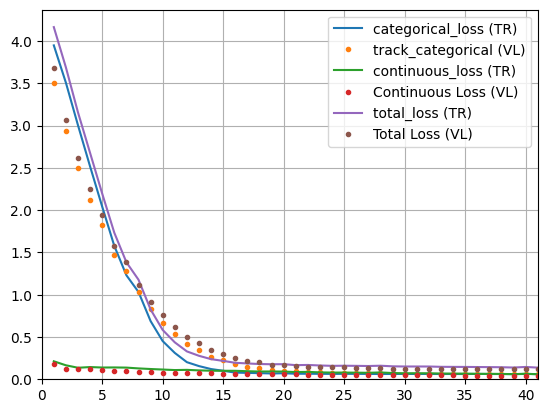

In [ ]:
model_dir = 'output/model_final_reg_metrics'

tr_losses = ['categorical_loss', 'continuous_loss', 'total_loss']
val_losses = ['track_categorical', 'track_continuous', 'tot']

plot_losses(model_dir, tr_losses, val_losses, plot_val=True)

Training accuracies: defaultdict(<class 'list'>, {'categorical_accuracy': [0.026701856404542923, 0.0663376972079277, 0.16446684300899506, 0.3310319781303406, 0.5414811372756958, 0.7290928959846497, 0.853156328201294, 0.9159883856773376, 0.9514431357383728, 0.9693018794059753, 0.9761080741882324, 0.9798691868782043, 0.9805363416671753, 0.9808872938156128, 0.9809513688087463, 0.9813590049743652, 0.9808179140090942, 0.9808006882667542, 0.9807820320129395, 0.9797965288162231, 0.9807531237602234, 0.980358898639679, 0.98050457239151, 0.9801235198974609, 0.9805107712745667, 0.9804747700691223, 0.9805510640144348, 0.9804927706718445, 0.9804421663284302, 0.980505108833313, 0.9808596968650818, 0.9808502793312073, 0.9808692336082458, 0.9805349707603455, 0.9807948470115662, 0.9805595874786377, 0.9806262850761414, 0.9808748960494995, 0.9809193015098572, 0.9807776212692261, 0.980778157711029]})
Validation accuracies: defaultdict(<class 'list'>, {'categorical_accuracy': [0.07688713073730469, 0.181363

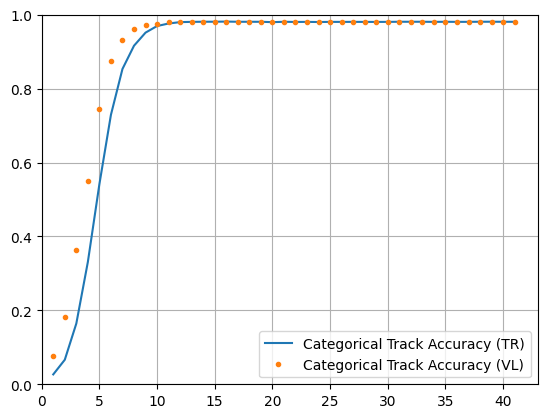

In [ ]:
plot_accuracies(model_dir, accuracies=['categorical_accuracy'], plot_val=True)

# Embedding Visualization

In [19]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.loader import DataLoader

# Configuration
data_dir = "/home/elygao/preprocessed_npz_vae"
model_path = '/home/elygao/output/model_final_reg_metrics/best_model'
output_dir = "/home/elygao/generate"

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the EmotionDataset
dataset = EmotionDataset(dir=data_dir, n_bars=2)

# Create a DataLoader
batch_size = 32  # Adjust this based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Load your trained VAE model
vae_params = {
    'd': 80,
    'n_bars': 2,
    'dropout': 0.1,
    'gnn_n_layers': 3,
    'batch_norm': False,
    'num_relations': 3,
    'num_dists': 32,
    'device': device
}
model = VAE(**vae_params).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()

def plot_3d_embeddings(embeddings, title, output_dir):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], 
                         c=embeddings[:, 2], cmap='viridis', alpha=0.6)

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.set_title(title)

    plt.colorbar(scatter)
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot
    plt.savefig(f"{output_dir}/{title.lower().replace(' ', '_')}.png")
    plt.close()

def visualize_embeddings(model, dataloader, device, output_dir):
    continuous_embeddings = []
    categorical_embeddings = []
    combined_embeddings = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            
            # Get embeddings from the content encoder
            z_c = model.encoder.c_encoder(batch)
            
            # Extract continuous and categorical embeddings
            continuous = model.encoder.c_encoder.continuous_cat_emb(batch.c_tensor_continuous)
            categorical = model.encoder.c_encoder.non_continuous_cat_emb(batch.c_tensor_categorical)
            
            # Flatten the embeddings
            continuous = continuous.view(continuous.size(0), -1)
            categorical = categorical.view(categorical.size(0), -1)
            
            continuous_embeddings.append(continuous.cpu().numpy())
            categorical_embeddings.append(categorical.cpu().numpy())
            combined_embeddings.append(z_c.cpu().numpy())

    # Concatenate all embeddings
    continuous_embeddings = np.concatenate(continuous_embeddings, axis=0)
    categorical_embeddings = np.concatenate(categorical_embeddings, axis=0)
    combined_embeddings = np.concatenate(combined_embeddings, axis=0)

    # Print final shapes
    print(f"Final continuous embeddings shape: {continuous_embeddings.shape}")
    print(f"Final categorical embeddings shape: {categorical_embeddings.shape}")
    print(f"Final combined embeddings shape: {combined_embeddings.shape}")
    
    # Reduce dimensionality to 3D using t-SNE
    tsne = TSNE(n_components=3, random_state=42)
    continuous_3d = tsne.fit_transform(continuous_embeddings)
    categorical_3d = tsne.fit_transform(categorical_embeddings)
    combined_3d = tsne.fit_transform(combined_embeddings)

    # Plot continuous embeddings
    plot_3d_embeddings(continuous_3d, "Continuous Embeddings", output_dir)

    # Plot categorical embeddings
    plot_3d_embeddings(categorical_3d, "Categorical Embeddings", output_dir)

    # Plot combined embeddings
    plot_3d_embeddings(combined_3d, "Combined Embeddings", output_dir)

# Run the visualization
visualize_embeddings(model, dataloader, device, output_dir)

# Baseline Model VAE

In [ ]:
class EmotionBaselineDataset(Dataset):
    def __init__(self, dir, n_bars):
        self.file_paths = []
        self.N_CAT_TOKENS = 28  # Assuming 28 cat tokens including 0
        for root, _, files in os.walk(dir):
            for file in files:
                if file.endswith('.npz'):
                    self.file_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = np.load(self.file_paths[idx])
        c_tensor = torch.tensor(data["c_tensor"], dtype=torch.float32)
        s_tensor = torch.tensor(data["s_tensor"], dtype=torch.bool)
        
        # Split continuous and categorical data
        continuous_data = c_tensor[0:3, :, :, :]  # First three tracks
        categorical_data = c_tensor[3:, :, :, :]  # Last two tracks

        # Process categ as one-hot encoding (categorical data)
        categ = categorical_data[..., 0]
        categ = torch.where(categ != 0, categ - 1, categ)
        onehot_p = torch.zeros((categ.numel(), self.N_CAT_TOKENS), dtype=torch.float32)
        onehot_p[torch.arange(categ.numel()), categ.long().flatten()] = 1.
        onehot_p = onehot_p.view(*categ.shape, self.N_CAT_TOKENS)

        c_tensor_continuous = continuous_data
        c_tensor_categorical = onehot_p

        return c_tensor_continuous, c_tensor_categorical, s_tensor

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SimpleVAE(nn.Module):
    def __init__(self, input_dim_continuous, input_dim_categorical, latent_dim, n_cat_tokens):
        super(SimpleVAE, self).__init__()
        self.input_dim_continuous = input_dim_continuous
        self.input_dim_categorical = input_dim_categorical
        self.latent_dim = latent_dim
        self.n_cat_tokens = n_cat_tokens

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim_continuous + input_dim_categorical, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )

        # Decoder
        self.decoder_shared = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU()
        )
        self.decoder_continuous = nn.Linear(2048, input_dim_continuous)
        self.decoder_categorical = nn.Linear(2048, input_dim_categorical)

    def encode(self, x_continuous, x_categorical):
        x = torch.cat([x_continuous, x_categorical], dim=-1)
        h = self.encoder(x)
        return h.chunk(2, dim=-1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_shared(z)
        return self.decoder_continuous(h), self.decoder_categorical(h)

    def forward(self, x_continuous, x_categorical):
        mu, log_var = self.encode(x_continuous, x_categorical)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def vae_loss(recon_x_continuous, recon_x_categorical, x_continuous, x_categorical, mu, log_var, n_cat_tokens):
    # MSE for continuous data
    MSE = F.mse_loss(recon_x_continuous, x_continuous, reduction='sum')
    
    # Cross-Entropy for categorical data
    CE = F.cross_entropy(recon_x_categorical.view(-1, n_cat_tokens), x_categorical.view(-1, n_cat_tokens).argmax(dim=1), reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return MSE + CE + KLD, MSE, CE, KLD

# The rest of your code remains the same
data_dir = "/home/elygao/preprocessed_npz_vae"
dataset = EmotionBaselineDataset(dir=data_dir, n_bars=2)

random.seed(42)
torch.manual_seed(42)

num_total = len(dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MAX_SIMU_TOKENS = 43
N_TRACKS = 5
N_CAT_TOKENS = 28

epochs = 500  # or whatever number you choose
model = SimpleVAE(input_dim_continuous=MAX_SIMU_TOKENS*3, 
                  input_dim_categorical=MAX_SIMU_TOKENS*N_CAT_TOKENS, 
                  latent_dim=128,
                  n_cat_tokens=N_CAT_TOKENS).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

def vae_loss(recon_x_continuous, recon_x_categorical, x_continuous, x_categorical, mu, log_var, n_cat_tokens, beta=0.1):
    MSE = F.mse_loss(recon_x_continuous, x_continuous, reduction='sum')
    CE = F.cross_entropy(recon_x_categorical.view(-1, n_cat_tokens), x_categorical.view(-1, n_cat_tokens).argmax(dim=1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + CE + beta * KLD, MSE, CE, KLD

for epoch in range(epochs):
    model.train()
    train_loss = 0
    mse_loss = 0
    ce_loss = 0
    kld_loss = 0
    for batch_idx, (c_tensor_continuous, c_tensor_categorical, _) in enumerate(train_loader):
        c_tensor_continuous = c_tensor_continuous.to(device).view(-1, MAX_SIMU_TOKENS*3)
        c_tensor_categorical = c_tensor_categorical.to(device).view(-1, MAX_SIMU_TOKENS*N_CAT_TOKENS)
        
        optimizer.zero_grad()
        (recon_continuous, recon_categorical), mu, log_var = model(c_tensor_continuous, c_tensor_categorical)
        loss, mse, ce, kld = vae_loss(recon_continuous, recon_categorical, c_tensor_continuous, c_tensor_categorical, mu, log_var, N_CAT_TOKENS)
        loss.backward()
        train_loss += loss.item()
        mse_loss += mse.item()
        ce_loss += ce.item()
        kld_loss += kld.item()
        optimizer.step()
        
    n_samples = len(train_loader.dataset)
    avg_loss = train_loss / n_samples
    scheduler.step(avg_loss)
    print(f'Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}, '
          f'MSE: {mse_loss / n_samples:.4f}, CE: {ce_loss / n_samples:.4f}, KLD: {kld_loss / n_samples:.4f}')


# Testing loop
model.eval()
test_loss = 0
with torch.no_grad():
    for c_tensor_continuous, c_tensor_categorical, _ in test_loader:
        c_tensor_continuous = c_tensor_continuous.to(device).view(-1, MAX_SIMU_TOKENS*3)
        c_tensor_categorical = c_tensor_categorical.to(device).view(-1, MAX_SIMU_TOKENS*N_CAT_TOKENS)
        (recon_continuous, recon_categorical), mu, log_var = model(c_tensor_continuous, c_tensor_categorical)
        test_loss += vae_loss(recon_continuous, recon_categorical, c_tensor_continuous, c_tensor_categorical, mu, log_var).item()

print(f'Test Loss: {test_loss / len(test_loader.dataset):.4f}')

In [ ]:
import os
import random
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt

def predict_emotion(model, location_data, device):
    model.eval()

    # Convert location_data to a PyTorch tensor and move it to the correct device
    location_data = torch.tensor(location_data, dtype=torch.float32, device=device)

    # Reshape input_continuous to match the model's expected input
    input_continuous = torch.zeros(64, MAX_SIMU_TOKENS * 3, device=device)
    input_continuous[:, MAX_SIMU_TOKENS:2*MAX_SIMU_TOKENS] = location_data

    # Reshape input_categorical to match the model's expected input
    input_categorical = torch.zeros(64, MAX_SIMU_TOKENS * N_PITCH_TOKENS, device=device)

    n_samples = 100
    emotion_predictions = []

    with torch.no_grad():
        for _ in range(n_samples):
            (recon_continuous, _), _, _ = model(input_continuous, input_categorical)
            # Extract the emotion prediction (first element of the first MAX_SIMU_TOKENS elements)
            emotion_pred = recon_continuous[:, 0].cpu().numpy()
            emotion_predictions.append(emotion_pred)

    emotion_mean = np.mean(emotion_predictions, axis=0)
    return emotion_mean

def process_and_predict(base_path, model, device):
    all_predictions = []
    all_true_emotions = []

    for participant_folder in tqdm(os.listdir(base_path), desc="Processing participants"):
        participant_path = os.path.join(base_path, participant_folder)
        if os.path.isdir(participant_path):
            for file in os.listdir(participant_path):
                if file.endswith('.npz'):
                    file_path = os.path.join(participant_path, file)
                    data = np.load(file_path)
                    c_tensor = data["c_tensor"]

                    # Extract location data (second channel, all samples, all time steps, first feature)
                    location_data = c_tensor[1, :, :, 0]  # This should be 64x43

                    # Make predictions
                    emotion_mean = predict_emotion(model, location_data, device)

                    # Store predictions and true emotions
                    all_predictions.extend(emotion_mean)
                    all_true_emotions.extend(c_tensor[0, :, 0, 0])  # Emotion is the first channel, all samples, first time step, first feature

    return np.array(all_predictions), np.array(all_true_emotions)

data_dir = "/home/elygao/preprocessed_npz_vae"
dataset = EmotionBaselineDataset(dir=data_dir, n_bars=2)

random.seed(42)
torch.manual_seed(42)

num_total = len(dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MAX_SIMU_TOKENS = 43
N_TRACKS = 5
N_PITCH_TOKENS = 28

epochs = 300
model = SimpleVAE(input_dim_continuous=MAX_SIMU_TOKENS*3, 
                    input_dim_categorical=MAX_SIMU_TOKENS*N_PITCH_TOKENS, 
                    latent_dim=128,
                    n_pitch_tokens=N_PITCH_TOKENS).to(device)
optimizer = optim.Adam(model.parameters(), lr=8e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

# Prediction and evaluation
predictions, true_emotions = process_and_predict(data_dir, model, device)

# Evaluate predictions
all_pred_means = predictions
all_true_emotions = true_emotions

# Calculate RMSE
rmse = sqrt(mean_squared_error(all_true_emotions, all_pred_means))

# Calculate MAE
mae = mean_absolute_error(all_true_emotions, all_pred_means)

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Emotions Predictions using Regressor Network

Create npz files for new locations from copenhgen coordinates data extraction 

In [ ]:
import pandas as pd
import os

def preprocess_location_data(counts_file, aggregated_file):
    # Read the CSV files
    counts_df = pd.read_csv(counts_file)
    aggregated_df = pd.read_csv(aggregated_file)

    # Create lat_lon column for counts_df
    counts_df['lat_lon'] = counts_df['Latitude'].astype(str) + "_" + counts_df['Longitude'].astype(str)

    # Rename 'Coordinate' column in aggregated_df to 'lat_lon'
    aggregated_df = aggregated_df.rename(columns={'Coordinate': 'lat_lon'})

    # Merge the dataframes using an inner join to keep only matching rows
    merged_df = pd.merge(counts_df, aggregated_df, on='lat_lon', how='inner')

    # Select only the required columns
    columns_to_keep = [
        'Latitude', 'Longitude', 'arts_entertainment_events', 'buildings_facilities', 'food_drink', 'public_services',
        'miscellaneous_services', 'roads_transportation', 'beauty_personal_health', 'greenery_natural',
        'tourism_leisure', 'water_body', 'poi_amenity', 'poi_transportation', 'poi_shop', 'poi_leisure',
        'poi_tourism', 'poi_natural', 'poi_buiding', 'poi_historic', 'Motorcyclist', 'Fence', 'Utility Pole',
        'Traffic Light', 'Bicyclist', 'Motorcycle', 'Sky', 'Terrain', 'On Rails', 'Lane Marking - General',
        'Pole', 'Car', 'Person', 'Sidewalk', 'Vegetation', 'Traffic Sign (Front)', 'Bicycle', 'Road',
        'Building', 'Other Rider', 'Curb', 'Wall', 'Bus', 'Truck', 'Manhole', 'lat_lon'
    ]

    final_df = merged_df[columns_to_keep].rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})

    return final_df

def process_all(output_folder, counts_file, aggregated_file):
    os.makedirs(output_folder, exist_ok=True)

    final_data_df = preprocess_location_data(counts_file, aggregated_file)

    # Save the combined data
    output_path = os.path.join(output_folder, 'combined_location_data.csv')
    final_data_df.to_csv(output_path, index=False)
    print(f"Saved combined location data to {output_path}")
    print(f"Number of rows in the combined data: {len(final_data_df)}")

    print("Processing completed. Data saved in the output folder.")

output_folder = 'preprocessed_new_locations'
counts_file = '/home/elygao/Data Extraction/copenhagen_generate/counts_output/counts.csv/50_osm_tags_poi.csv'
aggregated_file = '/home/elygao/Data Extraction/copenhagen_generate/segmentation_output/aggregated_results.csv'

process_all(output_folder, counts_file, aggregated_file)

Saved combined location data to preprocessed_new_locations/combined_location_data.csv
Number of rows in the combined data: 590
Processing completed. Data saved in the output folder.


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

# Constants
MAX_SIMU_TOKENS = 43
N_TRACKS = 5
N_BARS = 2
RESOLUTION = 8
REQUIRED_TIMESTEPS = N_BARS * 4 * RESOLUTION  # This should be 64
EMOTION_PADDING_VALUE = 0
ACTIVITY_PADDING_VALUE = 28

def segment_and_save(combined_location_data_path, output_dir):
    combined_location_data = pd.read_csv(combined_location_data_path)
    
    n_locations = len(combined_location_data)
    
    additional_features = [
        'Motorcyclist', 'Fence', 'Utility Pole', 'Traffic Light', 'Bicyclist', 'Motorcycle', 'Sky',
        'Terrain', 'On Rails', 'Lane Marking - General', 'Pole', 'Car', 'Person', 'Sidewalk',
        'Vegetation', 'Traffic Sign (Front)', 'Bicycle', 'Road', 'Building', 'Other Rider',
        'Curb', 'Wall', 'Bus', 'Truck', 'Manhole'
    ]
    
    poi_features = [
        'arts_entertainment_events', 'buildings_facilities', 'food_drink', 'public_services',
        'miscellaneous_services', 'roads_transportation', 'beauty_personal_health', 'greenery_natural',
        'tourism_leisure', 'water_body', 'poi_amenity', 'poi_transportation', 'poi_shop',
        'poi_leisure', 'poi_tourism', 'poi_natural', 'poi_buiding', 'poi_historic'
    ]
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for idx, row in combined_location_data.iterrows():
        # Initialize tensors for this location
        c_tensor = np.zeros((N_TRACKS, REQUIRED_TIMESTEPS, MAX_SIMU_TOKENS, 2), dtype=np.float32)
        s_tensor = np.zeros((N_TRACKS, REQUIRED_TIMESTEPS), dtype=np.int32)
        
        additional_counts = row[additional_features].values
        poi_counts = row[poi_features].values
        
        for t in range(REQUIRED_TIMESTEPS):
            # Emotions (HR descriptors) - set to padding value
            for feature_idx in range(9):  
                c_tensor[0, t, feature_idx, 0] = EMOTION_PADDING_VALUE
                c_tensor[0, t, feature_idx, 1] = 0
            
            # Locations - counts
            for i in range(len(additional_counts)):
                c_tensor[1, t, i, 0] = additional_counts[i]
                c_tensor[1, t, i, 1] = 1 if additional_counts[i] != EMOTION_PADDING_VALUE else 0
            
            # Locations - Add POI counts
            for i in range(len(poi_counts)):
                c_tensor[1, t, len(additional_counts) + i, 0] = poi_counts[i]
                c_tensor[1, t, len(additional_counts) + i, 1] = 1 if poi_counts[i] != EMOTION_PADDING_VALUE else 0
            
            # Durations as a separate track
            c_tensor[2, t, 0, 0] = EMOTION_PADDING_VALUE
            c_tensor[2, t, 0, 1] = 1

            # Activity as tokens (set to padding value)
            c_tensor[3, t, 0, 0] = ACTIVITY_PADDING_VALUE
            c_tensor[3, t, 0, 1] = 0
            
            # Modes as tokens (set to padding value)
            c_tensor[4, t, 0, 0] = ACTIVITY_PADDING_VALUE
            c_tensor[4, t, 0, 1] = 0
            
            # Set s_tensor
            for track in range(N_TRACKS):
                if np.any(c_tensor[track, t, :, 1] == 1):
                    s_tensor[track, t] = 1
                else:
                    s_tensor[track, t] = 0

        # Save NPZ file for this location
        sample_filepath = os.path.join(output_dir, f"location_{idx}.npz")
        np.savez(sample_filepath, c_tensor=c_tensor, s_tensor=s_tensor)
        print(f"File saved: {sample_filepath}")
    
    print(f"Processing completed. {n_locations} NPZ files saved in the output folder.")

combined_location_data_path = 'preprocessed_new_locations/combined_location_data.csv'
output_dir = 'preprocessed_npz_new_locations'
segment_and_save(combined_location_data_path, output_dir)

File saved: preprocessed_npz_new_locations/location_0.npz
File saved: preprocessed_npz_new_locations/location_1.npz
File saved: preprocessed_npz_new_locations/location_2.npz
File saved: preprocessed_npz_new_locations/location_3.npz
File saved: preprocessed_npz_new_locations/location_4.npz
File saved: preprocessed_npz_new_locations/location_5.npz
File saved: preprocessed_npz_new_locations/location_6.npz
File saved: preprocessed_npz_new_locations/location_7.npz
File saved: preprocessed_npz_new_locations/location_8.npz
File saved: preprocessed_npz_new_locations/location_9.npz
File saved: preprocessed_npz_new_locations/location_10.npz
File saved: preprocessed_npz_new_locations/location_11.npz
File saved: preprocessed_npz_new_locations/location_12.npz
File saved: preprocessed_npz_new_locations/location_13.npz
File saved: preprocessed_npz_new_locations/location_14.npz
File saved: preprocessed_npz_new_locations/location_15.npz
File saved: preprocessed_npz_new_locations/location_16.npz
File sa

File saved: preprocessed_npz_new_locations/location_48.npz
File saved: preprocessed_npz_new_locations/location_49.npz
File saved: preprocessed_npz_new_locations/location_50.npz
File saved: preprocessed_npz_new_locations/location_51.npz
File saved: preprocessed_npz_new_locations/location_52.npz
File saved: preprocessed_npz_new_locations/location_53.npz
File saved: preprocessed_npz_new_locations/location_54.npz
File saved: preprocessed_npz_new_locations/location_55.npz
File saved: preprocessed_npz_new_locations/location_56.npz
File saved: preprocessed_npz_new_locations/location_57.npz
File saved: preprocessed_npz_new_locations/location_58.npz
File saved: preprocessed_npz_new_locations/location_59.npz
File saved: preprocessed_npz_new_locations/location_60.npz
File saved: preprocessed_npz_new_locations/location_61.npz
File saved: preprocessed_npz_new_locations/location_62.npz
File saved: preprocessed_npz_new_locations/location_63.npz
File saved: preprocessed_npz_new_locations/location_64.n

In [ ]:
directory_path = 'preprocessed_npz_new_locations'

Creating LocationConditionDataset, Loading the Model, Making predictions 

In [ ]:
model_path = '/home/elygao/output/model_final_reg_metrics/final_model'
regressor_path = '/home/elygao/output/model_final_reg_metrics/final_regression_model'

def load_trained_models(vae_path, regressor_path, device, vae_params):
    # Load VAE
    model = VAE(**vae_params).to(device)
    vae_checkpoint = torch.load(vae_path, map_location=device)
    
    model.load_state_dict(vae_checkpoint['model_state_dict'], strict=False)
    model.eval()

    # Load regression model
    reg_checkpoint = torch.load(regressor_path, map_location=device)
    
    model.regression_network.load_state_dict(reg_checkpoint['model_state_dict'], strict=False)
    model.regression_network.eval()

    return model

# Load the trained models
try:
    model = load_trained_models(model_path, regressor_path, device, vae_params)
    print("Models loaded successfully")
except Exception as e:
    print(f"Error loading models: {str(e)}")
    print("Please check your model structure and saved checkpoints")

Models loaded successfully


In [ ]:
import torch
from torch_geometric.loader import DataLoader

# Paths
model_path = '/home/elygao/output/model_final_reg/final_model'
regressor_path = '/home/elygao/output/model_final_reg/final_regression_model'
directory_path = 'preprocessed_npz_new_locations'

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VAE parameters
vae_params = {
    'd': 80,
    'n_bars': 2,
    'dropout': 0.1,
    'gnn_n_layers': 3,
    'batch_norm': False,
    'num_relations': 3,
    'num_dists': 32,
    'device': device,
    'N_CAT_TOKENS': N_CAT_TOKENS,
    'CONT_DIM': CONT_DIM
}

def make_prediction(vae, graph, device):
    graph = graph.to(device)
    with torch.no_grad():
        mu, _ = vae.encoder(graph)
        hr_pred = vae.predict_hr(mu)
    return hr_pred.cpu().numpy()

# Load the trained models
try:
    model = load_trained_models(model_path, regressor_path, device, vae_params)
    print("Models loaded successfully")
except Exception as e:
    print(f"Error loading models: {str(e)}")
    print("Please check your model structure and saved checkpoints")

# Load the dataset
dataset = LocationConditionDataset(directory_path, n_bars=vae_params['n_bars'])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Make predictions
all_predictions = []
model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        predictions = make_prediction(model, batch, device)
        all_predictions.extend(predictions)

print(f"Made predictions for {len(all_predictions)} samples")
print("First few predictions:", all_predictions[:5])

# If you want to save the predictions
import numpy as np
np.savetxt("predictions.csv", all_predictions, delimiter=",")
print("Predictions saved to predictions.csv")

Error loading models: Error(s) in loading state_dict for VAE:
	size mismatch for regression_network.0.weight: copying a param with shape torch.Size([64, 80]) from checkpoint, the shape in current model is torch.Size([128, 80]).
	size mismatch for regression_network.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for regression_network.4.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for regression_network.4.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([64]).
Please check your model structure and saved checkpoints
Made predictions for 590 samples
First few predictions: [array([25.817568], dtype=float32), array([15.324547], dtype=float32), array([16.879333], dtype=float32), array([12.437971], dtype=float32), array([17.83514], dtype=float32)]
Prediction

/tmp/ipykernel_1642157/605701028.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_poi_impacts.index, y=sorted_poi_impacts.values, palette=colors)
/tmp/ipykernel_1642157/605701028.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_additional_impacts.index, y=sorted_additional_impacts.values, palette=colors)


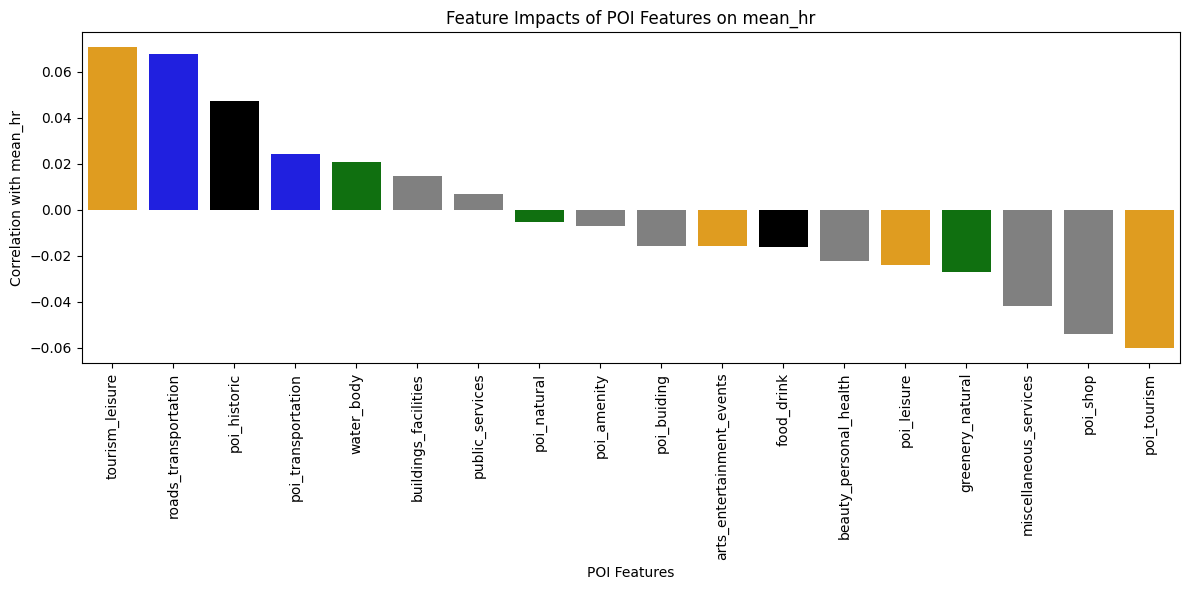

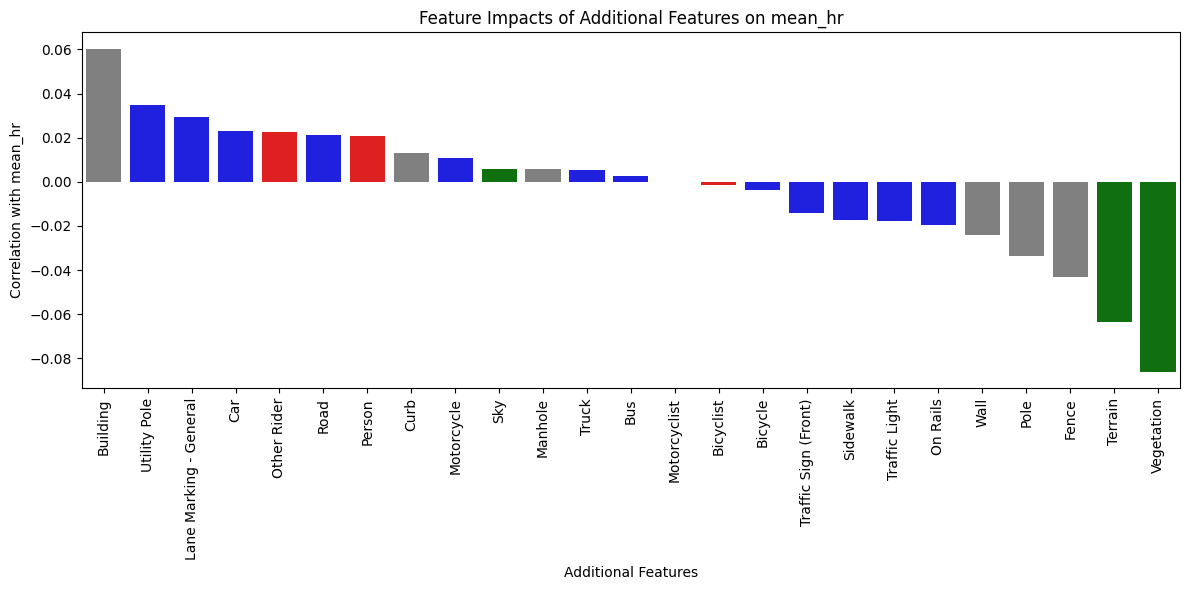

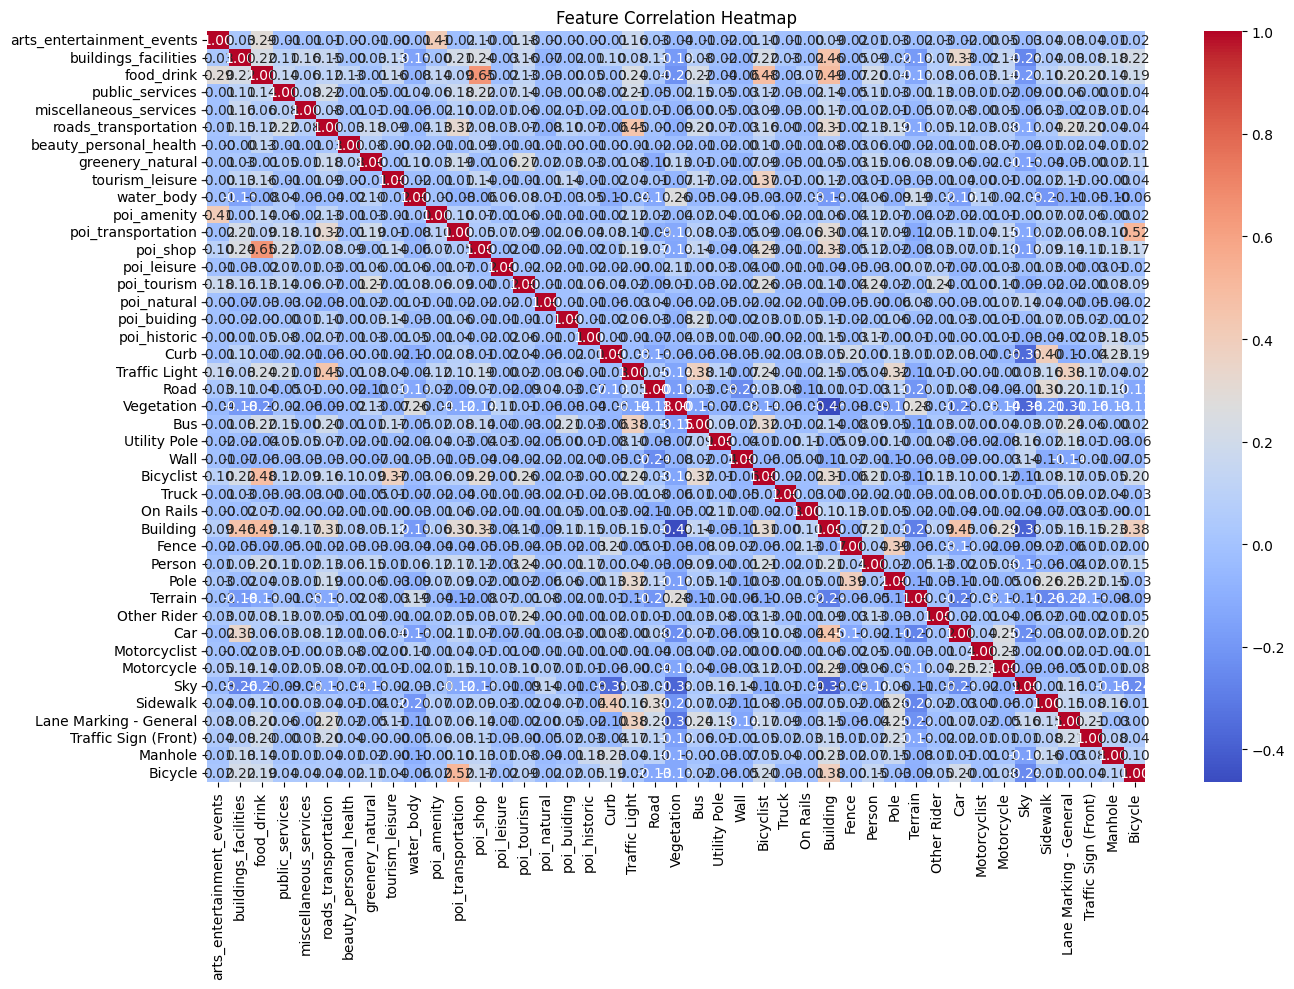

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the datasets
predictions = pd.read_csv('predictions.csv', header=None, names=['mean_hr'])
data = pd.read_csv('preprocessed_new_locations/combined_location_data.csv')

# Ensure predictions and data have matching rows
if len(predictions) != len(data):
    print(f"Number of rows in predictions: {len(predictions)}")
    print(f"Number of rows in data: {len(data)}")
    raise ValueError("The number of predictions and data rows do not match!")

# Combine the predictions with the data
data['mean_hr'] = predictions['mean_hr']

# Define features
poi_features = [
    'arts_entertainment_events', 'buildings_facilities', 'food_drink',
    'public_services', 'miscellaneous_services', 'roads_transportation',
    'beauty_personal_health', 'greenery_natural', 'tourism_leisure', 'water_body',
    'poi_amenity', 'poi_transportation', 'poi_shop', 'poi_leisure', 'poi_tourism',
    'poi_natural', 'poi_buiding', 'poi_historic'
]

additional_features = [
    'Curb', 'Traffic Light', 'Road', 'Vegetation', 'Bus', 'Utility Pole', 'Wall',
    'Bicyclist', 'Truck', 'On Rails', 'Building', 'Fence', 'Person', 'Pole',
    'Terrain', 'Other Rider', 'Car', 'Motorcyclist', 'Motorcycle', 'Sky',
    'Sidewalk', 'Lane Marking - General', 'Traffic Sign (Front)', 'Manhole',
    'Bicycle'
]

# Group features for color coding
green_features = ['greenery_natural', 'water_body', 'Sky', 'Terrain', 'poi_natural', 'Vegetation']
blue_features = ['Sidewalk', 'roads_transportation', 'poi_transportation', 'Traffic Light', 'Utility Pole', 'Truck', 'Bus', 'On Rails', 'Car', 'Motorcyclist', 'Motorcycle', 'Bicycle', 'Road', 'Traffic Sign (Front)', 'Lane Marking - General']
orange_features = ['tourism_leisure', 'poi_leisure', 'poi_tourism', 'arts_entertainment_events']
gray_features = ['buildings_facilities', 'public_services', 'miscellaneous_services', 'beauty_personal_health', 'poi_amenity', 'poi_shop', 'poi_buiding', 'Wall', 'Fence', 'Building', 'Manhole', 'Curb', 'Pole']
red_features = ['Person','Other Rider', 'Motorcyclist', 'Bicyclist']

# Calculate feature impacts
feature_impacts = data[poi_features + additional_features].corrwith(data['mean_hr'])

# Sort features by impact
sorted_poi_impacts = feature_impacts[poi_features].sort_values(ascending=False)
sorted_additional_impacts = feature_impacts[additional_features].sort_values(ascending=False)

# Define colors
def get_color(feature):
    if feature in green_features:
        return 'green'
    elif feature in blue_features:
        return 'blue'
    elif feature in orange_features:
        return 'orange'
    elif feature in gray_features:
        return 'gray'
    elif feature in red_features:
        return 'red'
    else:
        return 'black'

# Plot the most important feature impacts for POI features
plt.figure(figsize=(12, 6))
colors = [get_color(feature) for feature in sorted_poi_impacts.index]
sns.barplot(x=sorted_poi_impacts.index, y=sorted_poi_impacts.values, palette=colors)
plt.xticks(rotation=90)
plt.title('Feature Impacts of POI Features on mean_hr')
plt.xlabel('POI Features')
plt.ylabel('Correlation with mean_hr')
plt.tight_layout()
plt.savefig('/home/elygao/reg_model_plots/feature_impacts_poi_sorted.png')

# Plot the most important feature impacts for additional features
plt.figure(figsize=(12, 6))
colors = [get_color(feature) for feature in sorted_additional_impacts.index]
sns.barplot(x=sorted_additional_impacts.index, y=sorted_additional_impacts.values, palette=colors)
plt.xticks(rotation=90)
plt.title('Feature Impacts of Additional Features on mean_hr')
plt.xlabel('Additional Features')
plt.ylabel('Correlation with mean_hr')
plt.tight_layout()
plt.savefig('/home/elygao/reg_model_plots/feature_impacts_additional_sorted.png')

# Feature heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data[poi_features + additional_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('/home/elygao/reg_model_plots/feature_correlation_heatmap.png')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import folium
from folium.plugins import HeatMap

# Load the datasets
predictions = pd.read_csv('predictions.csv', header=None, names=['mean_hr'])
data = pd.read_csv('preprocessed_new_locations/combined_location_data.csv')

# Ensure predictions and data have matching rows
if len(predictions) != len(data):
    print(f"Number of rows in predictions: {len(predictions)}")
    print(f"Number of rows in data: {len(data)}")
    raise ValueError("The number of predictions and data rows do not match!")

# Combine the predictions with the data
data['mean_hr'] = predictions['mean_hr']

# Define features
poi_features = [
    'arts_entertainment_events', 'buildings_facilities', 'food_drink',
    'public_services', 'miscellaneous_services', 'roads_transportation',
    'beauty_personal_health', 'greenery_natural', 'tourism_leisure', 'water_body',
    'poi_amenity', 'poi_transportation', 'poi_shop', 'poi_leisure', 'poi_tourism',
    'poi_natural', 'poi_buiding', 'poi_historic'
]

additional_features = [
    'Curb', 'Traffic Light', 'Road', 'Vegetation', 'Bus', 'Utility Pole', 'Wall',
    'Bicyclist', 'Truck', 'On Rails', 'Building', 'Fence', 'Person', 'Pole',
    'Terrain', 'Other Rider', 'Car', 'Motorcyclist', 'Motorcycle', 'Sky',
    'Sidewalk', 'Lane Marking - General', 'Traffic Sign (Front)', 'Manhole',
    'Bicycle'
]

# Combine all features
all_features = poi_features + additional_features

# Prepare data for the model
X = data[all_features]
y = data['mean_hr']

# Create and fit the model
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X, y)

# Get feature importance (coefficients)
coefficients = model.named_steps['linearregression'].coef_
feature_importance = pd.Series(coefficients, index=all_features)

# Sort feature importance by absolute value, but keep the sign
sorted_feature_importance = feature_importance.reindex(feature_importance.abs().sort_values(ascending=False).index)

# Create a diverging colormap
cmap = plt.get_cmap('RdBu_r')
colors = cmap(np.linspace(0, 1, len(sorted_feature_importance)))

# Normalize the coefficients for color mapping
norm = plt.Normalize(sorted_feature_importance.min(), sorted_feature_importance.max())

# Plot feature importance with colorful bars
fig, ax = plt.subplots(figsize=(16, 12))
bars = ax.barh(sorted_feature_importance.index, sorted_feature_importance.values, 
               color=cmap(norm(sorted_feature_importance.values)))
ax.set_title('Feature Importance based on Linear Regression Coefficients', fontsize=16)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Coefficient Value', rotation=270, labelpad=25)

# Adjust layout and save
plt.tight_layout()
plt.savefig('/home/elygao/reg_model_plots/feature_importance_bar_chart_colorful_signed.png', dpi=300, bbox_inches='tight')
plt.close(fig)

# Display the relationship of the most important feature with mean_hr
most_important_feature = sorted_feature_importance.index[0]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data[most_important_feature], y=data['mean_hr'])
plt.title(f'Relationship between {most_important_feature} and mean_hr')
plt.xlabel(most_important_feature)
plt.ylabel('mean_hr')
plt.tight_layout()
plt.savefig(f'/home/elygao/reg_model_plots/relationship_{most_important_feature}_mean_hr.png')
plt.close()

# Create a heatmap
print("Creating heatmap...")
copenhagen_map = folium.Map(location=[55.6761, 12.5683], zoom_start=12)
heat_data = data[['latitude', 'longitude', 'mean_hr']].values.tolist()
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(copenhagen_map)

# Save the map
copenhagen_map.save("/home/elygao/reg_model_plots/copenhagen_heatmap.html")
print("Heatmap saved as copenhagen_heatmap.html")

print("Process completed.")

Creating heatmap...
Heatmap saved as copenhagen_heatmap.html
Process completed.


In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Load the datasets
predictions = pd.read_csv('predictions.csv', header=None, names=['mean_hr'])
data = pd.read_csv('preprocessed_new_locations/combined_location_data.csv')

# Ensure predictions and data have matching rows
if len(predictions) != len(data):
    print(f"Number of rows in predictions: {len(predictions)}")
    print(f"Number of rows in data: {len(data)}")
    raise ValueError("The number of predictions and data rows do not match!")

# Combine the predictions with the data
data['mean_hr'] = predictions['mean_hr']

# Define features
physical_features = ['Curb', 'Traffic Light', 'Road', 'Vegetation', 'Bus', 'Utility Pole', 'Wall',
                     'Bicyclist', 'Truck', 'On Rails', 'Building', 'Fence', 'Person', 'Pole',
                     'Terrain', 'Other Rider', 'Car', 'Motorcyclist', 'Motorcycle', 'Sky',
                     'Sidewalk', 'Lane Marking - General', 'Traffic Sign (Front)', 'Manhole',
                     'Bicycle']

poi_features = ['arts_entertainment_events', 'buildings_facilities', 'food_drink',
                'public_services', 'miscellaneous_services', 'roads_transportation',
                'beauty_personal_health', 'greenery_natural', 'tourism_leisure', 'water_body',
                'poi_amenity', 'poi_transportation', 'poi_shop', 'poi_leisure', 'poi_tourism',
                'poi_natural', 'poi_buiding', 'poi_historic']

# Custom color palette (darker colors from Tableau 20)
custom_colors = [
    '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', 
    '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF',
    '#AEC7E8', '#FFBB78', '#98DF8A', '#FF9896', '#C5B0D5',
    '#C49C94', '#F7B6D2', '#C7C7C7', '#DBDB8D', '#9EDAE5'
]

# Merge results_df with data
print("Merging results with feature data...")
merged_data = data

print("Available columns in merged_data:")
print(merged_data.columns.tolist())

# Update feature_columns based on available columns
feature_columns = physical_features + poi_features
feature_columns = [col for col in feature_columns if col in merged_data.columns]
print("Updated feature columns:")
print(feature_columns)

# Perform cluster analysis
print("Performing cluster analysis...")
n_clusters = 5  # You can adjust this number

# Prepare data for clustering
cluster_data = merged_data[['mean_hr'] + feature_columns]
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(cluster_data_scaled)
merged_data['cluster'] = cluster_labels

# Function to create a map for a specific feature
def create_feature_map(feature_name):
    feature_map = folium.Map(location=[55.6761, 12.5683], zoom_start=12)
    
    # Add heatmap
    heat_data = merged_data[['latitude', 'longitude', 'mean_hr']].values.tolist()
    HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(feature_map)
    
    # Add markers for each location
    marker_cluster = MarkerCluster().add_to(feature_map)
    for idx, row in merged_data.iterrows():
        inner_color = plt.cm.RdYlBu(1 - (row['mean_hr'] / merged_data['mean_hr'].max()))
        outer_color = plt.cm.viridis(row[feature_name] / merged_data[feature_name].max())
        
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=7,
            popup=f"Latitude: {row['latitude']:.5f}, Longitude: {row['longitude']:.5f}<br>Mean HR: {row['mean_hr']:.2f}<br>{feature_name}: {row[feature_name]:.2f}",
            color=outer_color,
            fill=True,
            fillColor=inner_color,
            fillOpacity=0.7
        ).add_to(marker_cluster)
    
    return feature_map

# Create and save maps for each feature
print("Creating feature maps...")
os.makedirs("feature_maps", exist_ok=True)
for feature in tqdm(feature_columns, desc="Creating feature maps"):
    try:
        feature_map = create_feature_map(feature)
        feature_map.save(f"reg_model_plots/feature_maps/{feature}_map.html")
    except KeyError as e:
        print(f"Error creating map for feature '{feature}': {e}")

def create_feature_importance_map(data, features, map_name):
    m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12)
    
    # Determine the most important feature for each location
    data['most_important_feature'] = data[features].idxmax(axis=1)
    
    feature_colors = {feature: color for feature, color in zip(features, custom_colors[:len(features)])}
    
    # Add markers for each location
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            popup=f"Most important feature: {row['most_important_feature']}<br>Value: {row[row['most_important_feature']]:.2f}<br>Mean HR: {row['mean_hr']:.2f}",
            color=feature_colors[row['most_important_feature']],
            fill=True,
            fillColor=feature_colors[row['most_important_feature']],
            fillOpacity=0.7
        ).add_to(m)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; right: 50px; width: 250px; max-height: 300px; 
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <strong>Most Important Feature</strong><br>
    '''
    for feature, color in feature_colors.items():
        legend_html += f'<span style="color:{color};">■</span> {feature}<br>'
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

def create_combined_map(data, features, map_name):
    combined_map = folium.Map(location=[55.6761, 12.5683], zoom_start=12)
    
    # Add heatmap
    heat_data = data[['latitude', 'longitude', 'mean_hr']].values.tolist()
    HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(combined_map)
    
    # Determine the most important feature for each location
    data['most_important_feature'] = data[features].idxmax(axis=1)
    
    feature_colors = {feature: color for feature, color in zip(features, custom_colors[:len(features)])}
    
    # Add markers for each location
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            popup=f"Most important feature: {row['most_important_feature']}<br>Value: {row[row['most_important_feature']]:.2f}<br>Mean HR: {row['mean_hr']:.2f}",
            color=feature_colors[row['most_important_feature']],
            fill=True,
            fillColor=feature_colors[row['most_important_feature']],
            fillOpacity=0.7
        ).add_to(combined_map)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; right: 50px; width: 250px; max-height: 300px; 
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <strong>Most Important Feature</strong><br>
    '''
    for feature, color in feature_colors.items():
        legend_html += f'<span style="color:{color};">■</span> {feature}<br>'
    legend_html += '</div>'
    combined_map.get_root().html.add_child(folium.Element(legend_html))
    
    # Save the combined map
    combined_map.save(f"reg_model_plots/{map_name}_combined.html")
    print(f"Combined map saved as {map_name}_combined.html")

    return combined_map

# Create combined maps for physical features and poi features
print("Creating combined maps...")
create_combined_map(merged_data, physical_features, "copenhagen_physical_features_importance")
create_combined_map(merged_data, poi_features, "copenhagen_poi_features_importance")

print("Process completed.")


Merging results with feature data...
Available columns in merged_data:
['latitude', 'longitude', 'arts_entertainment_events', 'buildings_facilities', 'food_drink', 'public_services', 'miscellaneous_services', 'roads_transportation', 'beauty_personal_health', 'greenery_natural', 'tourism_leisure', 'water_body', 'poi_amenity', 'poi_transportation', 'poi_shop', 'poi_leisure', 'poi_tourism', 'poi_natural', 'poi_buiding', 'poi_historic', 'Motorcyclist', 'Fence', 'Utility Pole', 'Traffic Light', 'Bicyclist', 'Motorcycle', 'Sky', 'Terrain', 'On Rails', 'Lane Marking - General', 'Pole', 'Car', 'Person', 'Sidewalk', 'Vegetation', 'Traffic Sign (Front)', 'Bicycle', 'Road', 'Building', 'Other Rider', 'Curb', 'Wall', 'Bus', 'Truck', 'Manhole', 'lat_lon', 'mean_hr']
Updated feature columns:
['Curb', 'Traffic Light', 'Road', 'Vegetation', 'Bus', 'Utility Pole', 'Wall', 'Bicyclist', 'Truck', 'On Rails', 'Building', 'Fence', 'Person', 'Pole', 'Terrain', 'Other Rider', 'Car', 'Motorcyclist', 'Motorcycl

Creating feature maps:   0%|          | 0/43 [00:00<?, ?it/s]

Creating feature maps: 100%|██████████| 43/43 [00:19<00:00,  2.17it/s]


Creating combined maps...
Combined map saved as copenhagen_physical_features_importance_combined.html
Combined map saved as copenhagen_poi_features_importance_combined.html
Process completed.


Creating DummyDataset for Intensity Plots

In [ ]:
import os
import random
import torch
import numpy as np
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch_geometric.data import Data

# Constants
N_CAT_TOKENS = 28
CONT_DIM = 1
MAX_SIMU_TOKENS = 43
N_TRACKS = 5
N_BARS = 2
RESOLUTION = 8
REQUIRED_TIMESTEPS = N_BARS * 4 * RESOLUTION  # This should be 64

# Configuration
data_dir = "/home/elygao/preprocessed_npz_vae"
model_path = '/home/elygao/output/model_final_reg_metrics/final_model'
regressor_path = '/home/elygao/output/model_final_reg_metrics/final_regression_model'
output_dir = "/home/elygao/reg_model_plots/intensity"

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# VAE parameters
vae_params = {
    'd': 80,
    'n_bars': 2,
    'dropout': 0.1,
    'gnn_n_layers': 3,
    'batch_norm': False,
    'num_relations': 3,
    'num_dists': 32,
    'device': device,
    'N_CAT_TOKENS': N_CAT_TOKENS,
    'CONT_DIM': CONT_DIM
}

def load_trained_models(vae_path, regressor_path, device, vae_params):
    # Load VAE
    model = VAE(**vae_params).to(device)
    vae_checkpoint = torch.load(vae_path, map_location=device)
    model.load_state_dict(vae_checkpoint['model_state_dict'], strict=False)
    model.eval()

    # Load regression model
    reg_checkpoint = torch.load(regressor_path, map_location=device)
    model.regression_network.load_state_dict(reg_checkpoint['model_state_dict'], strict=False)
    model.regression_network.eval()

    return model

def make_prediction(vae, graph, device):
    graph = graph.to(device)
    with torch.no_grad():
        mu, _ = vae.encoder(graph)
        hr_pred = vae.predict_hr(mu)
    return hr_pred.cpu().numpy()

# Load the trained models
try:
    model = load_trained_models(model_path, regressor_path, device, vae_params)
    print("Models loaded successfully")
except Exception as e:
    print(f"Error loading models: {str(e)}")
    print("Please check your model structure and saved checkpoints")

# Define features
poi_features = ['arts_entertainment_events', 'buildings_facilities', 'food_drink',
                'public_services', 'miscellaneous_services', 'roads_transportation',
                'beauty_personal_health', 'greenery_natural', 'tourism_leisure', 'water_body',
                'poi_amenity', 'poi_transportation', 'poi_shop', 'poi_leisure', 'poi_tourism',
                'poi_natural', 'poi_buiding', 'poi_historic']

additional_features = ['Curb', 'Traffic Light', 'Road', 'Vegetation', 'Bus', 'Utility Pole', 'Wall',
                     'Bicyclist', 'Truck', 'On Rails', 'Building', 'Fence', 'Person', 'Pole',
                     'Terrain', 'Other Rider', 'Car', 'Motorcyclist', 'Motorcycle', 'Sky',
                     'Sidewalk', 'Lane Marking - General', 'Traffic Sign (Front)', 'Manhole',
                     'Bicycle']

def generate_location_tensor(feature_name, intensity=0.5):
    location_tensor = torch.zeros(MAX_SIMU_TOKENS)
    if feature_name in poi_features:
        index = poi_features.index(feature_name)
        location_tensor[index] = intensity
    elif feature_name in additional_features:
        index = len(poi_features) + additional_features.index(feature_name)
        location_tensor[index] = intensity
    return location_tensor

def create_dummy_npz(location_tensor):
    c_tensor = np.zeros((N_TRACKS, REQUIRED_TIMESTEPS, MAX_SIMU_TOKENS, 2), dtype=np.float32)
    s_tensor = np.zeros((N_TRACKS, REQUIRED_TIMESTEPS), dtype=np.int32)
    
    # Fill the location track (track 1) with the location_tensor
    for t in range(REQUIRED_TIMESTEPS):
        c_tensor[1, t, :, 0] = location_tensor
        c_tensor[1, t, :, 1] = 1  # Set all features as present
    
    # Set s_tensor for the location track
    s_tensor[1, :] = 1
    
    return {'c_tensor': c_tensor, 's_tensor': s_tensor}

class DummyDataset(LocationConditionDataset):
    def __init__(self, dummy_npz):
        self.dummy_npz = dummy_npz
    
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        return self.process_npz(self.dummy_npz)
    
    def process_npz(self, npz_data):
        c_tensor = torch.tensor(npz_data['c_tensor'], dtype=torch.float32)
        s_tensor = torch.tensor(npz_data['s_tensor'], dtype=torch.bool)

        continuous_data = c_tensor[0:3, :, :, :]
        categorical_data = c_tensor[3:, :, :, :]

        n_timesteps_per_bar = c_tensor.shape[1] // N_BARS

        continuous_data = continuous_data.reshape(-1, N_BARS, n_timesteps_per_bar, continuous_data.shape[2], continuous_data.shape[3])
        continuous_data = continuous_data.permute(1, 0, 2, 3, 4)

        categorical_data = categorical_data.reshape(-1, N_BARS, n_timesteps_per_bar, categorical_data.shape[2], categorical_data.shape[3])
        categorical_data = categorical_data.permute(1, 0, 2, 3, 4)

        s_tensor = s_tensor.reshape(-1, N_BARS, n_timesteps_per_bar)
        s_tensor = s_tensor.permute(1, 0, 2)

        continuous_data = continuous_data[..., :-1]

        categ = categorical_data[..., 0]
        categ = torch.where(categ != 0, categ - 1, categ)
        onehot_p = torch.zeros((categ.numel(), N_CAT_TOKENS), dtype=torch.float32)
        onehot_p[torch.arange(categ.numel()), categ.long().flatten()] = 1.
        onehot_p = onehot_p.view(*categ.shape, N_CAT_TOKENS)

        c_tensor_continuous = continuous_data
        c_tensor_categorical = onehot_p

        # Build graph structure from structure tensor
        graph = graph_from_tensor(s_tensor)

        s_tensor_continuous = s_tensor[:, 0:3, :]
        s_tensor_categorical = s_tensor[:, 3:, :]
        
        c_tensor_continuous = c_tensor_continuous.reshape(-1, c_tensor_continuous.shape[-2], c_tensor_continuous.shape[-1])
        c_tensor_categorical = c_tensor_categorical.reshape(-1, c_tensor_categorical.shape[-2], c_tensor_categorical.shape[-1])

        c_tensor_continuous = c_tensor_continuous[s_tensor_continuous.reshape(-1).bool()]
        c_tensor_categorical = c_tensor_categorical[s_tensor_categorical.reshape(-1).bool()]


        graph.c_tensor_continuous = c_tensor_continuous
        graph.c_tensor_categorical = c_tensor_categorical
        graph.s_tensor = s_tensor.float()
    

        return graph

def analyze_feature_impact(model, feature_name, device, intensities=np.linspace(0, 1, 11)):
    results = []
    for intensity in tqdm(intensities, desc=f"Analyzing {feature_name}", leave=False):
        location_tensor = generate_location_tensor(feature_name, intensity)
        dummy_npz = create_dummy_npz(location_tensor)
        dummy_dataset = DummyDataset(dummy_npz)
        dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False)
        
        for graph in dummy_loader:
            hr_pred = make_prediction(model, graph, device)
            results.append((intensity, hr_pred.item()))
    return results

def plot_feature_impacts_grid(feature_comparisons, output_dir, n_cols=5):
    n_features = len(feature_comparisons)
    n_rows = math.ceil(n_features / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle('Impact of Features on Predicted Heart Rate', fontsize=16)
    
    for idx, (feature, impacts) in enumerate(feature_comparisons.items()):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        intensities = [impact[0] for impact in impacts]
        mean_hr = [impact[1] for impact in impacts]
        
        ax.plot(intensities, mean_hr, marker='o')
        ax.set_title(feature, fontsize=10)
        ax.set_xlabel('Intensity', fontsize=8)
        ax.set_ylabel('Predicted HR', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.grid(True, linestyle='--', alpha=0.7)
    
    # Remove any unused subplots
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])
    
    plt.tight_layout()
    filename = "feature_impacts_grid.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved feature impacts grid to {filename}")

def compare_features(model, feature_list, device):
    all_impacts = {}
    for feature in tqdm(feature_list, desc="Comparing features"):
        all_impacts[feature] = analyze_feature_impact(model, feature, device)
    return all_impacts

def analyze_all_features(model, device):
    all_features = additional_features + poi_features
    results = {}
    for feature in tqdm(all_features, desc="Analyzing all features"):
        impacts = analyze_feature_impact(model, feature, device)
        results[feature] = impacts
    return results

def plot_feature_heatmap(all_impacts, output_dir):
    features = list(all_impacts.keys())
    intensities = [impact[0] for impact in all_impacts[features[0]]]
    
    mean_hr_data = np.array([[impact[1] for impact in all_impacts[feature]] for feature in features])
    
    plt.figure(figsize=(20, 10))
    sns.heatmap(mean_hr_data, xticklabels=intensities, yticklabels=features, cmap="YlOrRd")
    plt.xlabel('Feature Intensity')
    plt.ylabel('Features')
    plt.title('Impact of Feature Intensities on Predicted Heart Rate')
    plt.tight_layout()
    
    filename = "feature_heatmap.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()
    print(f"Saved feature heatmap to {filename}")

# Analyze and visualize individual features
features_to_compare = poi_features + additional_features
feature_comparisons = compare_features(model, features_to_compare, device)

plot_feature_impacts_grid(feature_comparisons, output_dir)

# Analyze all features
all_feature_impacts = analyze_all_features(model, device)

# Create heatmap visualization
plot_feature_heatmap(all_feature_impacts, output_dir)

# Optional: Save the results
torch.save(all_feature_impacts, os.path.join(output_dir, "all_feature_impacts.pt"))
print(f"All feature impacts saved to {os.path.join(output_dir, 'all_feature_impacts.pt')}")

/home/elygao/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Models loaded successfully


Comparing features: 100%|██████████| 43/43 [00:09<00:00,  4.71it/s]


Saved feature impacts grid to feature_impacts_grid.png


Analyzing all features: 100%|██████████| 43/43 [00:08<00:00,  4.83it/s]


Saved feature heatmap to feature_heatmap.png
All feature impacts saved to /home/elygao/reg_model_plots/intensity/all_feature_impacts.pt


# Emotion Predictions using resampling VAE 

In [ ]:
import os
import pandas as pd
import torch
from tqdm import tqdm

def load_and_process_data(base_path):
    all_data = []
    features = ['arts_entertainment_events', 'buildings_facilities', 'food_drink', 'public_services', 
                'miscellaneous_services', 'roads_transportation', 'beauty_personal_health', 
                'greenery_natural', 'tourism_leisure', 'water_body', 'poi_amenity', 'poi_transportation', 
                'poi_shop', 'poi_leisure', 'poi_tourism', 'poi_natural', 'poi_buiding', 'poi_historic', 
                'Motorcyclist', 'Fence', 'Utility Pole', 'Traffic Light', 'Bicyclist', 'Motorcycle', 
                'Sky', 'Terrain', 'On Rails', 'Lane Marking - General', 'Pole', 'Car', 'Person', 
                'Sidewalk', 'Vegetation', 'Traffic Sign (Front)', 'Bicycle', 'Road', 'Building', 
                'Other Rider', 'Curb', 'Wall', 'Bus', 'Truck', 'Manhole']

    for participant_folder in tqdm(os.listdir(base_path), desc="Processing participants"):
        participant_path = os.path.join(base_path, participant_folder)
        if os.path.isdir(participant_path):
            for file in os.listdir(participant_path):
                if file.endswith('_final_data.csv'):
                    file_path = os.path.join(participant_path, file)
                    df = pd.read_csv(file_path)
                    all_data.append(df[features])

    return pd.concat(all_data, ignore_index=True)

def predict_emotions_from_locations(model, location_condition, device, n_bars=2, n_timesteps=32):
    # Create a sample graph structure for n_bars and n_timesteps
    s_tensor = torch.zeros((n_bars, 5, n_timesteps), dtype=torch.bool)
    s_tensor[:, 1, :] = 1  # Mark all locations as known

    # Prepare graph input
    graph = graph_from_tensor(s_tensor)
    #print(graph)

    # Count active nodes for continuous and categorical data
    continuous_nodes = s_tensor[:, :3, :].sum().item()
    categorical_nodes = s_tensor[:, 3:, :].sum().item()

    # Create input tensors with correct shapes
    c_tensor_continuous = torch.zeros((continuous_nodes, MAX_SIMU_TOKENS, CONT_DIM))
    #print("c_tensor_continuous shape:", c_tensor_continuous.shape)
    c_tensor_categorical = torch.zeros((categorical_nodes, MAX_SIMU_TOKENS, N_PITCH_TOKENS))
    #print("c_tensor_categorical shape:", c_tensor_categorical.shape)

    # Fill in the location data
    location_tensor = torch.tensor(location_condition).clone().detach().unsqueeze(0)  # Shape: [1, 34]
    locations_active = s_tensor[:, 1, :].sum().item()
    c_tensor_continuous[:locations_active, :, 0] = location_tensor.repeat(locations_active, 1)

    graph.c_tensor_continuous = c_tensor_continuous
    graph.c_tensor_categorical = c_tensor_categorical
    graph.s_tensor = s_tensor.float()

    # Set distinct_bars correctly
    graph.distinct_bars = torch.arange(n_bars).repeat_interleave(graph.num_nodes // n_bars)
    graph.bars = graph.distinct_bars % n_bars
    graph.batch = torch.zeros(graph.num_nodes, dtype=torch.long)

    graph = graph.to(device)

    # Encode
    mu, log_var = model.encoder(graph)
    
    # Reparameterization trick
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std
    
    # Decode
    try:
        c_logits_categorical, c_logits_continuous = model.decoder(z, graph)
    except RuntimeError as e:
        print(f"RuntimeError in decoder: {e}")
        print(f"z shape: {z.shape}")
        print(f"graph.num_nodes: {graph.num_nodes}")
        print(f"graph.num_edges: {graph.num_edges}")
        print(f"graph.c_tensor_continuous shape: {graph.c_tensor_continuous.shape}")
        print(f"graph.c_tensor_categorical shape: {graph.c_tensor_categorical.shape}")
        print(f"graph.s_tensor shape: {graph.s_tensor.shape}")
        print(f"graph.distinct_bars shape: {graph.distinct_bars.shape}")
        print(f"graph.distinct_bars unique values: {torch.unique(graph.distinct_bars)}")
        print(f"graph.bars shape: {graph.bars.shape}")
        print(f"graph.batch shape: {graph.batch.shape}")
        raise
    
    # Extract emotion predictions (first track)
    #emotions_active = s_tensor[:, 0, :].sum().item()
    #print(emotions_active)
    emotions = c_logits_continuous[:, :, 0]
    
    return emotions.view(n_bars, n_timesteps, MAX_SIMU_TOKENS)

def predict_and_aggregate_emotions(model, location_condition, device, n_bars=2, n_timesteps=32, n_samples=10):
    mean_hr_predictions = []
    std_hr_predictions = []
    
    for _ in range(n_samples):
        predicted_emotions = predict_emotions_from_locations(model, location_condition, device, n_bars, n_timesteps)
        
        # Extract mean_HR and std_HR from each prediction
        mean_hr = predicted_emotions[:, :, 0].flatten()  # First value in each prediction
        std_hr = predicted_emotions[:, :, 1].flatten()   # Second value in each prediction
        
        # Remove zeros and add to lists
        mean_hr_predictions.extend(mean_hr[mean_hr > 0].tolist())
        std_hr_predictions.extend(std_hr[std_hr > 0].tolist())
    
    # Convert lists to tensors
    mean_hr_tensor = torch.tensor(mean_hr_predictions)
    std_hr_tensor = torch.tensor(std_hr_predictions)
    
    # Calculate aggregated statistics
    aggregated_mean_hr = torch.mean(mean_hr_tensor)
    aggregated_std_hr = torch.mean(std_hr_tensor)
    
    # Calculate standard deviation of the predictions
    std_of_mean_hr = torch.std(mean_hr_tensor)
    std_of_std_hr = torch.std(std_hr_tensor)
    
    return aggregated_mean_hr, aggregated_std_hr, std_of_mean_hr, std_of_std_hr

# Constants
N_PITCH_TOKENS = 28
CONT_DIM = 1
MAX_SIMU_TOKENS = 43

# Configuration
data_dir = "/home/elygao/preprocessed_npz_vae"
model_path = '/home/elygao/output/model_final/best_model'
output_dir = "/home/elygao/generate"

# Set random seed for reproducibility
#random.seed(42)
#torch.manual_seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the PolyphemusDataset
dataset = PolyphemusDataset(dir=data_dir, n_bars=2)

# Load your trained VAE model
vae_params = {
    'd': 80,
    'n_bars': 2,
    'dropout': 0.1,
    'gnn_n_layers': 3,
    'batch_norm': False,
    'num_relations': 3,
    'num_dists': 32,
    'device': device
}
model = VAE(**vae_params).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()


In [ ]:
base_path = '/home/elygao/preprocessed_location_cond'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and process all data
all_data = load_and_process_data(base_path)

# Predict for each location condition
all_agg_mean_hr = []
for _, row in tqdm(all_data.iterrows(), total=len(all_data), desc="Predicting"):
    location_condition = row.values.tolist()
    agg_mean_hr, _, _, _ = predict_and_aggregate_emotions(model, location_condition, device)
    all_agg_mean_hr.append(agg_mean_hr.item())

# Convert to tensor
all_agg_mean_hr_tensor = torch.tensor(all_agg_mean_hr)

# Save the tensor
torch.save(all_agg_mean_hr_tensor, 'all_agg_mean_hr.pt')
print(f"Saved tensor of shape {all_agg_mean_hr_tensor.shape} to all_agg_mean_hr.pt")


In [ ]:
import os
import pandas as pd
from tqdm import tqdm

def load_mean_hr(base_path):
    all_data = []
    
    for participant_folder in tqdm(os.listdir(base_path), desc="Processing participants"):
        participant_path = os.path.join(base_path, participant_folder)
        if os.path.isdir(participant_path):
            for file in os.listdir(participant_path):
                if file.endswith('data_with_normalized_hr.csv'):
                    file_path = os.path.join(participant_path, file)
                    df = pd.read_csv(file_path)
                    all_data.append(df)
    
    # Concatenate all dataframes
    combined_data = pd.concat(all_data, ignore_index=True)
    
    # Return only the first column
    return combined_data.iloc[:, 0]

# Usage
base_path = '/home/elygao/preprocessed_location_cond'
first_column_data = load_mean_hr(base_path)
print(first_column_data.shape)

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_metrics(predictions, ground_truth):
    # Convert both to numpy arrays for consistent processing
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.numpy()
    if isinstance(ground_truth, pd.Series):
        ground_truth = ground_truth.values
    elif isinstance(ground_truth, list):
        ground_truth = np.array(ground_truth)
    
    # Ensure both are 1D arrays
    predictions = predictions.flatten()
    ground_truth = ground_truth.flatten()
    
    # Check if sizes match
    if predictions.shape != ground_truth.shape:
        raise ValueError(f"Shapes do not match: predictions {predictions.shape}, ground truth {ground_truth.shape}")
    
    # Remove NaN values
    mask = ~np.isnan(predictions) & ~np.isnan(ground_truth)
    predictions = predictions[mask]
    ground_truth = ground_truth[mask]
    
    # Check if we have any non-NaN values left
    if len(predictions) == 0:
        raise ValueError("All values are NaN after filtering")
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
    
    # Compute MAE
    mae = mean_absolute_error(ground_truth, predictions)
    
    return rmse, mae

# Compute metrics
try:
    rmse, mae = compute_metrics(all_agg_mean_hr_tensor, first_column_data)
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
except ValueError as e:
    print(f"Error: {str(e)}")

Emotion Predictions on Copenhagen Map

In [ ]:
import numpy as np
import pandas as pd

def generate_copenhagen_coordinates(num_points=1000):
    # Define the boundaries of Copenhagen
    lat_min, lat_max = 55.61, 55.73
    lon_min, lon_max = 12.45, 12.65
    
    # Generate random coordinates within these boundaries
    latitudes = np.random.uniform(lat_min, lat_max, num_points)
    longitudes = np.random.uniform(lon_min, lon_max, num_points)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'Latitude': latitudes,
        'Longitude': longitudes
    })
    
    return df

# Generate coordinates
copenhagen_coords = generate_copenhagen_coordinates()

# Save to CSV
csv_filename = 'copenhagen_coordinates.csv'
copenhagen_coords.to_csv(csv_filename, index=False)
print(f"Saved {len(copenhagen_coords)} coordinates to {csv_filename}")

# Display the first few rows
print(copenhagen_coords.head())

Saved 1000 coordinates to copenhagen_coordinates.csv
    Latitude  Longitude
0  55.654945  12.487027
1  55.724086  12.558380
2  55.697839  12.624589
3  55.681839  12.596445
4  55.628722  12.611312


In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

def load_copenhagen_coordinates(csv_file):
    return pd.read_csv(csv_file)

def plot_copenhagen_coordinates(coordinates_df):
    # Calculate the center of Copenhagen based on the data
    center_lat = coordinates_df['Latitude'].mean()
    center_lon = coordinates_df['Longitude'].mean()

    # Create a map centered on Copenhagen
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # Add markers for each coordinate
    marker_cluster = MarkerCluster().add_to(m)

    for idx, row in coordinates_df.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=2,
            popup=f"Point {idx}: {row['Latitude']:.4f}, {row['Longitude']:.4f}",
            color="#3186cc",
            fill=True,
            fillColor="#3186cc"
        ).add_to(marker_cluster)

    # Save the map
    m.save("copenhagen_coordinates_map.html")
    print("Map saved as copenhagen_coordinates_map.html")

# Load coordinates from CSV
csv_file = 'copenhagen_coordinates.csv'
coordinates_df = load_copenhagen_coordinates(csv_file)

# Plot coordinates on the map
plot_copenhagen_coordinates(coordinates_df)

Map saved as copenhagen_coordinates_map.html


In [ ]:
import pandas as pd
import numpy as np
import torch
import folium
from folium.plugins import HeatMap
import os
from tqdm import tqdm

# Load the CSV files
print("Loading data...")
aggregated_results = pd.read_csv('/home/elygao/Data Extraction/copenhagen_generate/segmentation_output/aggregated_results.csv')
osm_tags = pd.read_csv('/home/elygao/Data Extraction/copenhagen_generate/counts_output/counts.csv/50_osm_tags_poi.csv')

# Merge the dataframes
print("Merging data...")
osm_tags['Coordinate'] = osm_tags['Latitude'].astype(str) + '_' + osm_tags['Longitude'].astype(str)
combined_data = pd.merge(aggregated_results, osm_tags, on='Coordinate', how='inner')

# Prepare location conditions
print("Preparing location conditions...")
feature_columns = ['Curb', 'Traffic Light', 'Road', 'Vegetation', 'Bus', 'Utility Pole', 'Wall',
                   'Bicyclist', 'Truck', 'On Rails', 'Building', 'Fence', 'Person', 'Pole',
                   'Terrain', 'Other Rider', 'Car', 'Motorcyclist', 'Motorcycle', 'Sky',
                   'Sidewalk', 'Lane Marking - General', 'Traffic Sign (Front)', 'Manhole',
                   'Bicycle', 'arts_entertainment_events', 'buildings_facilities', 'food_drink',
                   'public_services', 'miscellaneous_services', 'roads_transportation',
                   'beauty_personal_health', 'greenery_natural', 'tourism_leisure', 'water_body',
                   'poi_amenity', 'poi_transportation', 'poi_shop', 'poi_leisure', 'poi_tourism',
                   'poi_natural', 'poi_buiding', 'poi_historic']

location_conditions = combined_data[feature_columns].values

# Make predictions
print("Making predictions...")
# Use tqdm to create a progress bar
temp_file = 'temp_copenhagen_predictions.csv'
results = []

for i, location_condition in enumerate(tqdm(location_conditions, desc="Processing locations", unit="location")):
    agg_mean_hr, agg_std_hr, std_of_mean_hr, std_of_std_hr = predict_and_aggregate_emotions(model, location_condition, device)
    results.append({
        'Latitude': combined_data.iloc[i]['Latitude'],
        'Longitude': combined_data.iloc[i]['Longitude'],
        'mean_hr': agg_mean_hr.item(),
        'std_hr': agg_std_hr.item()
    })
    
    # Save progress every 100 locations
    if (i + 1) % 10 == 0:
        temp_df = pd.DataFrame(results)
        temp_df.to_csv(temp_file, index=False)
        print(f"Progress saved. Processed {i + 1}/{len(location_conditions)} locations.")

# Save final results
final_df = pd.DataFrame(results)
final_df.to_csv('copenhagen_predictions.csv', index=False)
print("All predictions saved to copenhagen_predictions.csv")

# Remove temporary file
if os.path.exists(temp_file):
    os.remove(temp_file)

# Create a heatmap
print("Creating heatmap...")
copenhagen_map = folium.Map(location=[55.6761, 12.5683], zoom_start=12)
heat_data = final_df[['Latitude', 'Longitude', 'mean_hr']].values.tolist()
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(copenhagen_map)

# Save the map
copenhagen_map.save("copenhagen_heatmap.html")
print("Heatmap saved as copenhagen_heatmap.html")

print("Process completed.")

Loading data...
Merging data...
Preparing location conditions...
Making predictions...


Processing locations:   0%|          | 0/590 [00:00<?, ?location/s]

Processing locations:   2%|▏         | 10/590 [00:35<34:05,  3.53s/location]

Progress saved. Processed 10/590 locations.


Processing locations:   3%|▎         | 20/590 [01:11<33:51,  3.56s/location]

Progress saved. Processed 20/590 locations.


Processing locations:   5%|▌         | 30/590 [01:46<33:32,  3.59s/location]

Progress saved. Processed 30/590 locations.


Processing locations:   7%|▋         | 40/590 [02:22<32:43,  3.57s/location]

Progress saved. Processed 40/590 locations.


Processing locations:   8%|▊         | 50/590 [02:57<31:44,  3.53s/location]

Progress saved. Processed 50/590 locations.


Processing locations:  10%|█         | 60/590 [03:32<31:15,  3.54s/location]

Progress saved. Processed 60/590 locations.


Processing locations:  12%|█▏        | 70/590 [05:13<2:35:50, 17.98s/location]

Progress saved. Processed 70/590 locations.


Processing locations:  14%|█▎        | 80/590 [05:48<33:25,  3.93s/location]  

Progress saved. Processed 80/590 locations.


Processing locations:  15%|█▌        | 90/590 [06:24<30:08,  3.62s/location]

Progress saved. Processed 90/590 locations.


Processing locations:  17%|█▋        | 100/590 [14:04<8:47:39, 64.61s/location] 

Progress saved. Processed 100/590 locations.


Processing locations:  19%|█▊        | 110/590 [14:54<43:33,  5.44s/location]  

Progress saved. Processed 110/590 locations.


Processing locations:  20%|██        | 120/590 [15:29<28:10,  3.60s/location]

Progress saved. Processed 120/590 locations.


Processing locations:  22%|██▏       | 130/590 [16:05<27:18,  3.56s/location]

Progress saved. Processed 130/590 locations.


Processing locations:  24%|██▎       | 140/590 [16:40<26:22,  3.52s/location]

Progress saved. Processed 140/590 locations.


Processing locations:  25%|██▌       | 150/590 [17:15<25:57,  3.54s/location]

Progress saved. Processed 150/590 locations.


Processing locations:  27%|██▋       | 160/590 [17:51<25:24,  3.54s/location]

Progress saved. Processed 160/590 locations.


Processing locations:  29%|██▉       | 170/590 [18:26<25:04,  3.58s/location]

Progress saved. Processed 170/590 locations.


Processing locations:  31%|███       | 180/590 [19:02<24:04,  3.52s/location]

Progress saved. Processed 180/590 locations.


Processing locations:  32%|███▏      | 190/590 [19:37<24:03,  3.61s/location]

Progress saved. Processed 190/590 locations.


Processing locations:  34%|███▍      | 200/590 [20:13<23:19,  3.59s/location]

Progress saved. Processed 200/590 locations.


Processing locations:  36%|███▌      | 210/590 [22:30<2:36:51, 24.77s/location]

Progress saved. Processed 210/590 locations.


Processing locations:  37%|███▋      | 220/590 [23:06<25:42,  4.17s/location]  

Progress saved. Processed 220/590 locations.


Processing locations:  39%|███▉      | 230/590 [23:42<22:13,  3.70s/location]

Progress saved. Processed 230/590 locations.


Processing locations:  41%|████      | 240/590 [24:18<20:51,  3.58s/location]

Progress saved. Processed 240/590 locations.


Processing locations:  42%|████▏     | 250/590 [24:54<20:01,  3.53s/location]

Progress saved. Processed 250/590 locations.


Processing locations:  44%|████▍     | 260/590 [25:29<19:30,  3.55s/location]

Progress saved. Processed 260/590 locations.


Processing locations:  46%|████▌     | 270/590 [26:05<18:51,  3.54s/location]

Progress saved. Processed 270/590 locations.


Processing locations:  47%|████▋     | 280/590 [26:40<18:08,  3.51s/location]

Progress saved. Processed 280/590 locations.


Processing locations:  49%|████▉     | 290/590 [27:15<17:38,  3.53s/location]

Progress saved. Processed 290/590 locations.


Processing locations:  51%|█████     | 300/590 [27:51<17:13,  3.57s/location]

Progress saved. Processed 300/590 locations.


Processing locations:  53%|█████▎    | 310/590 [28:26<16:23,  3.51s/location]

Progress saved. Processed 310/590 locations.


Processing locations:  54%|█████▍    | 320/590 [29:01<15:49,  3.52s/location]

Progress saved. Processed 320/590 locations.


Processing locations:  56%|█████▌    | 330/590 [29:37<15:20,  3.54s/location]

Progress saved. Processed 330/590 locations.


Processing locations:  58%|█████▊    | 340/590 [30:12<14:48,  3.56s/location]

Progress saved. Processed 340/590 locations.


Processing locations:  59%|█████▉    | 350/590 [30:47<14:07,  3.53s/location]

Progress saved. Processed 350/590 locations.


Processing locations:  61%|██████    | 360/590 [31:23<13:34,  3.54s/location]

Progress saved. Processed 360/590 locations.


Processing locations:  63%|██████▎   | 370/590 [31:58<13:07,  3.58s/location]

Progress saved. Processed 370/590 locations.


Processing locations:  64%|██████▍   | 380/590 [32:34<12:32,  3.58s/location]

Progress saved. Processed 380/590 locations.


Processing locations:  66%|██████▌   | 390/590 [33:11<12:10,  3.65s/location]

Progress saved. Processed 390/590 locations.


Processing locations:  68%|██████▊   | 400/590 [33:47<11:23,  3.60s/location]

Progress saved. Processed 400/590 locations.


Processing locations:  69%|██████▉   | 410/590 [34:22<10:39,  3.55s/location]

Progress saved. Processed 410/590 locations.


Processing locations:  71%|███████   | 420/590 [34:58<10:06,  3.57s/location]

Progress saved. Processed 420/590 locations.


Processing locations:  73%|███████▎  | 430/590 [35:34<09:30,  3.57s/location]

Progress saved. Processed 430/590 locations.


Processing locations:  75%|███████▍  | 440/590 [36:09<08:50,  3.54s/location]

Progress saved. Processed 440/590 locations.


Processing locations:  76%|███████▋  | 450/590 [36:45<08:17,  3.55s/location]

Progress saved. Processed 450/590 locations.


Processing locations:  78%|███████▊  | 460/590 [37:20<07:43,  3.57s/location]

Progress saved. Processed 460/590 locations.


Processing locations:  80%|███████▉  | 470/590 [37:56<07:09,  3.58s/location]

Progress saved. Processed 470/590 locations.


Processing locations:  81%|████████▏ | 480/590 [38:32<06:30,  3.55s/location]

Progress saved. Processed 480/590 locations.


Processing locations:  83%|████████▎ | 490/590 [39:07<05:55,  3.55s/location]

Progress saved. Processed 490/590 locations.


Processing locations:  85%|████████▍ | 500/590 [39:43<05:21,  3.57s/location]

Progress saved. Processed 500/590 locations.


Processing locations:  86%|████████▋ | 510/590 [40:18<04:45,  3.57s/location]

Progress saved. Processed 510/590 locations.


Processing locations:  88%|████████▊ | 520/590 [40:54<04:08,  3.55s/location]

Progress saved. Processed 520/590 locations.


Processing locations:  90%|████████▉ | 530/590 [41:30<03:31,  3.53s/location]

Progress saved. Processed 530/590 locations.


Processing locations:  92%|█████████▏| 540/590 [42:05<02:56,  3.53s/location]

Progress saved. Processed 540/590 locations.


Processing locations:  93%|█████████▎| 550/590 [42:40<02:20,  3.52s/location]

Progress saved. Processed 550/590 locations.


Processing locations:  95%|█████████▍| 560/590 [43:15<01:47,  3.57s/location]

Progress saved. Processed 560/590 locations.


Processing locations:  97%|█████████▋| 570/590 [43:51<01:10,  3.55s/location]

Progress saved. Processed 570/590 locations.


Processing locations:  98%|█████████▊| 580/590 [44:26<00:35,  3.53s/location]

Progress saved. Processed 580/590 locations.


Processing locations: 100%|██████████| 590/590 [45:02<00:00,  4.58s/location]

Progress saved. Processed 590/590 locations.
All predictions saved to copenhagen_predictions.csv
Creating heatmap...
Heatmap saved as copenhagen_heatmap.html
Process completed.


In [ ]:
import pandas as pd
import numpy as np
import torch
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# Define the two sets of features
physical_features = ['Curb', 'Traffic Light', 'Road', 'Vegetation', 'Bus', 'Utility Pole', 'Wall',
                     'Bicyclist', 'Truck', 'On Rails', 'Building', 'Fence', 'Person', 'Pole',
                     'Terrain', 'Other Rider', 'Car', 'Motorcyclist', 'Motorcycle', 'Sky',
                     'Sidewalk', 'Lane Marking - General', 'Traffic Sign (Front)', 'Manhole',
                     'Bicycle']

poi_features = ['arts_entertainment_events', 'buildings_facilities', 'food_drink',
                'public_services', 'miscellaneous_services', 'roads_transportation',
                'beauty_personal_health', 'greenery_natural', 'tourism_leisure', 'water_body',
                'poi_amenity', 'poi_transportation', 'poi_shop', 'poi_leisure', 'poi_tourism',
                'poi_natural', 'poi_buiding', 'poi_historic']

# Custom color palette (darker colors from Tableau 20)
custom_colors = [
    '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', 
    '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF',
    '#AEC7E8', '#FFBB78', '#98DF8A', '#FF9896', '#C5B0D5',
    '#C49C94', '#F7B6D2', '#C7C7C7', '#DBDB8D', '#9EDAE5'
]

def create_feature_importance_map(data, features, map_name):
    m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()], zoom_start=12)
    
    # Determine the most important feature for each location
    data['most_important_feature'] = data[features].idxmax(axis=1)
    
    feature_colors = {feature: color for feature, color in zip(features, custom_colors[:len(features)])}
    
    # Add markers for each location
    for _, row in data.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            popup=f"Most important feature: {row['most_important_feature']}<br>Value: {row[row['most_important_feature']]:.2f}<br>Mean HR: {row['mean_hr']:.2f}",
            color=feature_colors[row['most_important_feature']],
            fill=True,
            fillColor=feature_colors[row['most_important_feature']],
            fillOpacity=0.7
        ).add_to(m)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; right: 50px; width: 250px; max-height: 300px; 
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <strong>Most Important Feature</strong><br>
    '''
    for feature, color in feature_colors.items():
        legend_html += f'<span style="color:{color};">■</span> {feature}<br>'
    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Save the map
    m.save(f"{map_name}.html")
    print(f"Feature importance map saved as {map_name}.html")

# Create feature importance maps
create_feature_importance_map(merged_data, physical_features, "copenhagen_physical_features_importance")
create_feature_importance_map(merged_data, poi_features, "copenhagen_poi_features_importance")

# Create bar plots for feature importance
def plot_feature_importance(data, features, plot_name):
    importance = data[features].max()
    colors_to_use = custom_colors[:len(features)]  # Use the same custom colors as in the map
    plt.figure(figsize=(15, 10))
    bars = importance.sort_values().plot(kind='barh', color=colors_to_use)
    plt.title(f'Maximum Impact of Each Feature on Heart Rate')
    plt.xlabel('Maximum Feature Value')
    plt.tight_layout()
    
    # Add value labels to the end of each bar
    for i, v in enumerate(importance.sort_values()):
        bars.text(v, i, f' {v:.2f}', va='center')
    
    plt.savefig(f"{plot_name}.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Feature importance plot saved as {plot_name}.png")

plot_feature_importance(merged_data, physical_features, "physical_features_importance")
plot_feature_importance(merged_data, poi_features, "poi_features_importance")

print("Process completed.")

Feature importance map saved as copenhagen_physical_features_importance.html
Feature importance map saved as copenhagen_poi_features_importance.html
Feature importance plot saved as physical_features_importance.png


Feature importance plot saved as poi_features_importance.png
Process completed.
